# August 12

In this notebook, we implement the functionality to parse and generate the primal and dual mesh objects required for DEC-QED in Python.

Theory comments:
- circumcentral duals result in the desired orthogonality between primal and dual elements
    - https://www.sciencedirect.com/science/article/pii/S0021999117306496#br0010

Programming comments:
- our choice of numpy arrays in many occasions is because they are generally much faster than list objects, especially for element-wise manipulatons; however, they are much slower for appending than lists (as numpy arrays are appended by creating a new object, while lists are appended in place). 
- possible to visualize voronoi/circumcentral dual mesh in Gmsh, but cannot export it
    - https://gmsh.geuz.narkive.com/wLAglbca/about-outputting-voronoi-tessellations

#### Insall the third party software gmshparser, to make sure our portion of the code responsible for reading in the .msh file representing the primal mesh works as expected

In [1]:
# pip install gmshparser (run in shell)

# source: https://github.com/ahojukka5/gmshparser

#### Import necessary dependencies to be used throughout the notebook. Other section-specific dependencies are imported as needed.

In [2]:
import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib notebook

import gmshparser
import itertools

#### Creating the mesh object using gmshparser, to benchmark our code.

In [3]:
from pathlib import Path
parent_string = str(Path(Path.cwd()).parent)
relative_path = "\\meshes\\transfinite_test.msh"

# replace file name here, e.g.
# "pyramid.msh"
# "cube_transfinite_3.msh"
# "cube_transfinite_dense.msh"

In [4]:
file_name = parent_string + relative_path
mesh = gmshparser.parse(file_name) 

# mesh object contains all info about primal mesh
print(mesh)

Mesh name: C:\Users\8J3021897\Desktop\qurip_code\meshes\transfinite_test.msh
Mesh version: 4.1
Number of nodes: 45
Minimum node tag: 1
Maximum node tag: 45
Number of node entities: 27
Number of elements: 216
Minimum element tag: 1
Maximum element tag: 216
Number of element entities: 27


# Primal mesh

The mesh generated by Gmsh consist only of nodes and elements (the latter of which are tetrahedra). In this section, we read in precisely these nodes and elements as represented in the .msh file, and store them in dictionary form to be manipulated later (i.e. for generating the rest of the primal mesh representation and for creating the dual mesh).

#### Parsing the nodes

In [5]:
node_dict = {}

"""
key: node_id (int)
value: node_coords (array of floats)
"""

# read .msh file as python file object
fileHandler = open(file_name, "r")

current_line = "None"

# Get next line from file, until line Nodes section reached
while not current_line.startswith("$Nodes"):
    current_line = fileHandler.readline()

# 1st line of Nodes section after "$Nodes" 
# contains meta-data about section
current_line = fileHandler.readline() 

# e.g. " 1 2 3 \n" -> [1, 2, 3]
nodes_data = list(map(int, current_line.strip().split(" ")))        
number_of_node_entities = nodes_data[0]        
number_of_nodes = nodes_data[1]

for _ in range(number_of_node_entities):
    
    # 1st line of each block contains meta-data about entity
    current_line = fileHandler.readline() 
    entity_data = list(map(int, current_line.strip().split(" ")))  
    entity_number_of_nodes = entity_data[3]
    
    current_tags = [] # list of all node tags in this entity
    for _ in range(entity_number_of_nodes):
        
        # if entity has x nodes, first x lines after 
        # entity meta-data contains all node tags in this entity
        current_line = fileHandler.readline()
        tag = int(current_line)
        current_tags.append(tag)
    
    # dict of all nodes in this entity:
    # key = node id; value = coordinates
    current_node_dict = {} 
    
    for node_tag in current_tags:
        
        current_line = fileHandler.readline()
        node_coords = np.array(list(map(float, current_line.strip().split(" ")))) 
        current_node_dict[node_tag] = node_coords
    
    # update node_dict by extending it with the current sub-dictionary of nodes in this entity
    node_dict.update(current_node_dict)

fileHandler.close()

# display dict
node_dict

{1: array([-0.5, -0.5,  0.5]),
 2: array([ 0.5, -0.5,  0.5]),
 3: array([ 0.5, -0.5, -0.5]),
 4: array([-0.5, -0.5, -0.5]),
 5: array([-0.5,  0.5,  0.5]),
 6: array([0.5, 0.5, 0.5]),
 7: array([ 0.5,  0.5, -0.5]),
 8: array([-0.5,  0.5, -0.5]),
 9: array([-1.37512224e-12, -5.00000000e-01,  5.00000000e-01]),
 10: array([ 5.00000000e-01, -5.00000000e-01,  1.37512224e-12]),
 11: array([ 1.37512224e-12, -5.00000000e-01, -5.00000000e-01]),
 12: array([-5.00000000e-01, -5.00000000e-01, -1.37512224e-12]),
 13: array([-1.37512224e-12,  5.00000000e-01,  5.00000000e-01]),
 14: array([5.00000000e-01, 5.00000000e-01, 1.37512224e-12]),
 15: array([ 1.37512224e-12,  5.00000000e-01, -5.00000000e-01]),
 16: array([-5.00000000e-01,  5.00000000e-01, -1.37512224e-12]),
 17: array([-5.00000000e-01, -1.37512224e-12,  5.00000000e-01]),
 18: array([-5.00000000e-01, -1.37512224e-12, -5.00000000e-01]),
 19: array([ 5.00000000e-01, -1.37512224e-12,  5.00000000e-01]),
 20: array([ 5.00000000e-01, -1.37512224e-12

#### Parsing the tetrahedra

In [6]:
tetrahedron_dict = {}

"""
key: tetrahedron_id (int)
value: nodes forming the tetrahedron (array of int)
"""

fileHandler = open(file_name, "r")

current_line = "None"

while not current_line.startswith("$Elements"):
    
    # Get next line from file, until line Elements section reached
    current_line = fileHandler.readline()

# 1st line of Elements section after "$Elements" 
# contains meta-data about section
current_line = fileHandler.readline() 

elements_data = list(map(int, current_line.strip().split(" ")))        
number_of_element_entities = elements_data[0]        
number_of_elements = nodes_data[1]

for _ in range(number_of_element_entities):
    
    # 1st line of each block contains meta-data about entity
    current_line = fileHandler.readline() 
    entity_data = list(map(int, current_line.strip().split(" ")))  
    entity_element_type = entity_data[2]
    entity_number_of_elements = entity_data[3]
    
    # if the current entity contains tetrahedra, update tetrahedron_dict 
    if entity_element_type == 4:
        
        # dict of all tets in this entity:
        # key = element id; value = nodes that make up the tet (connectivity)
        current_tetrahedron_dict = {} 
        for _ in range(entity_number_of_elements):
            
            # if entity has x elements, first x lines after entity meta-data contains
            # all elements of the entity, with the first number in each line being the element id
            # and the remaining numbers in that line being the nodes which make up that tetrahedron
            current_line = fileHandler.readline()
            current_line_parsed = list(map(int, current_line.strip().split(" ")))
            element_tag = current_line_parsed[0]
            element_nodes = current_line_parsed[1:]
            current_tetrahedron_dict[element_tag] = np.array(element_nodes)
        
        # update tetrahedron_dict
        tetrahedron_dict.update(current_tetrahedron_dict)
    
    # if current entity does not contain tetrahedra, skip the lines in that entity
    else:
        for _ in range(entity_number_of_elements):
            current_line = fileHandler.readline()

fileHandler.close()

# display dict
tetrahedron_dict

{109: array([21, 40, 24, 45]),
 110: array([42, 23, 44, 45]),
 111: array([27, 29, 31, 45]),
 112: array([33, 26, 25, 45]),
 113: array([44, 23, 30, 45]),
 114: array([21, 34, 40, 45]),
 115: array([27, 43, 29, 45]),
 116: array([33, 25, 39, 45]),
 117: array([38, 24, 40, 45]),
 118: array([26, 33, 35, 45]),
 119: array([42, 23, 45, 22]),
 120: array([42, 35, 36, 45]),
 121: array([41, 35, 42, 45]),
 122: array([27, 31, 28, 45]),
 123: array([24, 30, 23, 45]),
 124: array([12, 21, 40, 24]),
 125: array([36, 22, 42, 45]),
 126: array([29, 31, 13, 27]),
 127: array([33, 25, 26, 15]),
 128: array([41, 26, 35, 45]),
 129: array([26, 41, 43, 45]),
 130: array([42, 23, 22, 10]),
 131: array([43, 44, 30, 45]),
 132: array([36, 34, 22, 45]),
 133: array([21, 22, 34, 45]),
 134: array([32, 30, 24, 45]),
 135: array([39, 34, 33, 45]),
 136: array([39, 40, 34, 45]),
 137: array([29, 43, 30, 45]),
 138: array([28, 37, 39, 45]),
 139: array([28, 39, 25, 45]),
 140: array([32, 24, 38, 45]),
 141: ar

#### Checking parsing for nodes and tetrahedra

Above, we implemented functionality to read in the file and make node_dict and tetrahedron_dict. Now, we use gmshparser to check that the above code works as desired. Some of the syntax here relies on methods defined in gmshparser and Deepdiff, the latter of which is a package which allows us to easily compare two dictionaries whose dict values are np arrays (and hence cannot be compared simply with "=="). 

In [7]:
node_dict_check = {}

"""
key: node_id (int)
value: node_coords (array of floats)
"""

for entity in mesh.get_node_entities():
    for node in entity.get_nodes():
        node_id = node.get_tag()
        node_coords = node.get_coordinates()
        node_dict_check[node_id] = np.array(node_coords) # create dict of nodes: key is id, value is coordinate

# compare our dictionary with the gmsh dictionary (The set difference should be the empty set)
from deepdiff import DeepDiff
print("Difference between node_dict and node_dict_check:", DeepDiff(node_dict, node_dict_check))

Difference between node_dict and node_dict_check: {}


In [8]:
tetrahedron_dict_check = {}

"""
key: tetrahedron_id (int)
value: node_ids (array of ints)
"""

for entity in mesh.get_element_entities():
    el_type = entity.get_element_type()
    if el_type == 4:
        for element in entity.get_elements():
            el_id = element.get_tag()
            el_con = element.get_connectivity()
            tetrahedron_dict_check[el_id] = np.array(el_con)

# compare our dictionary with the gmsh dictionary
from deepdiff import DeepDiff
print("Difference between tetrahedron_dict and tetrahedron_dict_check:", DeepDiff(tetrahedron_dict, tetrahedron_dict_check))

Difference between tetrahedron_dict and tetrahedron_dict_check: {}


#### Creating dictionary of tetrahedra volumes

In [9]:
tetrahedron_volume_dict = {}

"""
key: tetrahedron_id (int)
value: volume of tetrahedron (float)
"""

def get_tetrahedron_volume(tetrahedron_id):
    
    # get coordinates of nodes
    nodes = tetrahedron_dict[tetrahedron_id]
    x1 = node_dict[nodes[0]][0] 
    y1 = node_dict[nodes[0]][1] # e.g. this is the y coordinate of 1st node of the input tet
    z1 = node_dict[nodes[0]][2]
    x2 = node_dict[nodes[1]][0]
    y2 = node_dict[nodes[1]][1]
    z2 = node_dict[nodes[1]][2]
    x3 = node_dict[nodes[3]][0]
    y3 = node_dict[nodes[3]][1]
    z3 = node_dict[nodes[3]][2]
    x4 = node_dict[nodes[2]][0]
    y4 = node_dict[nodes[2]][1]
    z4 = node_dict[nodes[2]][2]
    
    # use cross-product formula to get volume
    """
    https://keisan.casio.com/has10/SpecExec.cgi?path=05000000.Mathematics/01000600.Space%2520geometry/10000300.Volume%
    2520of%2520a%2520tetrahedron%2520and%2520a%2520parallelepiped/default.xml&charset=utf-8
    """
    volume = 1/6 * (
        (x4-x1)*((y2-y1)*(z3-z1)-(z2-z1)*(y3-y1)) +
        (y4-y1)*((z2-z1)*(x3-x1)-(x2-x1)*(z3-z1)) +
        (z4-z1)*((x2-x1)*(y3-y1)-(y2-y1)*(x3-x1))
    )
    
    return abs(volume)

# populate dict
for tetrahedron_id in tetrahedron_dict:
    tetrahedron_volume_dict[tetrahedron_id] = get_tetrahedron_volume(tetrahedron_id)

# display dict
tetrahedron_volume_dict

{109: 0.012359275268061225,
 110: 0.010895996217847544,
 111: 0.011402778230058795,
 112: 0.01060252490141576,
 113: 0.014361348313459015,
 114: 0.013835114065446826,
 115: 0.01335409300265088,
 116: 0.012684922589251458,
 117: 0.014199896696366312,
 118: 0.015258756192942017,
 119: 0.014527994957123026,
 120: 0.013369737714920582,
 121: 0.012602365169728225,
 122: 0.014257640795448178,
 123: 0.013512413147290743,
 124: 0.005859375000009848,
 125: 0.016545100976204583,
 126: 0.005670575289262075,
 127: 0.005445593415951523,
 128: 0.01532858487623712,
 129: 0.013297142776109072,
 130: 0.007324218749986573,
 131: 0.013110445549930601,
 132: 0.012511542700944237,
 133: 0.013389093793037044,
 134: 0.01185233528070532,
 135: 0.012391587681733452,
 136: 0.01319811564808833,
 137: 0.012397325746675333,
 138: 0.012647985387768512,
 139: 0.01344625454433455,
 140: 0.015579774435355687,
 141: 0.011888371398457373,
 142: 0.01441950394204738,
 143: 0.011790838040179951,
 144: 0.012938823483098345,

In [10]:
sum(tetrahedron_volume_dict.values())

0.9999999999999993

Sanity check: this value is close enough to the value of the volume of the entire mesh, which is 1.

#### The mesh object created by gmsh does not contain any faces or edges. Now, we create dictionaries which contain the information on these objects.

#### Creating dictionary of faces

In [11]:
face_dict = {}

"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the face in ascending order of node id, with 
    - the ordering defining an orientation (e.g. according to right hand rule)
value: [tetrahedron_id 1, tetrahedron_id 2] (array of int)
    - all tetrahedrons that share this face. If the face is shared, len of array is 2, 
    - and face corresponds uniquely to a dual edge whose endpoints are both circumcenters.
    - Otherwise, if face is not shared (i.e. it is on the boundary of primal mesh), then len of array of 1,
    - and the dual edge has the circumcenter of the primal face as one of its endpoints.
"""

for tetrahedron_id in tetrahedron_dict:
    
    # get nodes that make up tetrahedron
    tetrahedron_nodes = tetrahedron_dict[tetrahedron_id]
    
    # for a tetrahedron, any subset of 3 nodes of 4 form a valid face
    faces = list(itertools.combinations(tetrahedron_nodes, 3)) 
    
    value = tetrahedron_id
    
    for face in faces:
        
        key = list(face) # tuple is immutable, so need to first convert to list, sort, then convert back
        key.sort() # sorts in place, by ascending order
        key = tuple(key)
        
        # if face exists in dict
        if key in face_dict:
            face_dict[key] = np.append(face_dict[key], value) #Note, here we use np.append, which is much slower than list append  
        # otherwise, start a new array 
        else: 
            face_dict[key] = np.array([value])

# display dict
face_dict

{(21, 24, 40): array([109, 124]),
 (21, 40, 45): array([109, 114]),
 (21, 24, 45): array([109, 141]),
 (24, 40, 45): array([109, 117]),
 (23, 42, 44): array([110, 158]),
 (23, 42, 45): array([110, 119]),
 (42, 44, 45): array([110, 153]),
 (23, 44, 45): array([110, 113]),
 (27, 29, 31): array([111, 126]),
 (27, 29, 45): array([111, 115]),
 (27, 31, 45): array([111, 122]),
 (29, 31, 45): array([111, 156]),
 (25, 26, 33): array([112, 127]),
 (26, 33, 45): array([112, 118]),
 (25, 33, 45): array([112, 116]),
 (25, 26, 45): array([112, 154]),
 (23, 30, 44): array([113, 178]),
 (30, 44, 45): array([113, 131]),
 (23, 30, 45): array([113, 123]),
 (21, 34, 40): array([114, 183]),
 (21, 34, 45): array([114, 133]),
 (34, 40, 45): array([114, 136]),
 (27, 29, 43): array([115, 182]),
 (27, 43, 45): array([115, 143]),
 (29, 43, 45): array([115, 137]),
 (25, 33, 39): array([116, 185]),
 (33, 39, 45): array([116, 135]),
 (25, 39, 45): array([116, 139]),
 (24, 38, 40): array([117, 152]),
 (24, 38, 45):

#### Creating dictionary of face areas

In [12]:
face_area_dict = {}

"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the face in ascending order of node id, with 
    - the ordering defining an orientation according to right hand rule
value: face_area (array of int)
    - area of face (float)
"""

def get_triangle_area(face_id):
    node1 = node_dict[(face_id)[0]]
    node2 = node_dict[(face_id)[1]]
    node3 = node_dict[(face_id)[2]]
    side1 = node2 - node1
    side2 = node3 - node1
    side1x = side1[0]
    side1y = side1[1]
    side1z = side1[2]
    side2x = side2[0]
    side2y = side2[1]
    side2z = side2[2]
    area = 0.5 * np.sqrt(
        (side1y*side2z - side1z*side2y)**2 +
        (side1z*side2x - side1x*side2z)**2 +
        (side1x*side2y - side1y*side2x)**2
    )
    return area

for face in face_dict:
    face_area_dict[face] =  get_triangle_area(face)

# display dict
face_area_dict

{(21, 24, 40): 0.0782362324892647,
 (21, 40, 45): 0.10832302796331464,
 (21, 24, 45): 0.11248440541912431,
 (24, 40, 45): 0.14266177258275187,
 (23, 42, 44): 0.06962246858385905,
 (23, 42, 45): 0.141071996842358,
 (42, 44, 45): 0.09463105240816312,
 (23, 44, 45): 0.11161404628493209,
 (27, 29, 31): 0.07484307147335824,
 (27, 29, 45): 0.10657812129872364,
 (27, 31, 45): 0.1362906430074793,
 (29, 31, 45): 0.10207324633326922,
 (25, 26, 33): 0.0702382057217055,
 (26, 33, 45): 0.1390522329829904,
 (25, 33, 45): 0.10407599354577833,
 (25, 26, 45): 0.10204504456397168,
 (23, 30, 44): 0.08645060554502257,
 (30, 44, 45): 0.12027403868195927,
 (23, 30, 45): 0.1205435216668292,
 (21, 34, 40): 0.0818217190065023,
 (21, 34, 45): 0.12194820383781824,
 (34, 40, 45): 0.12128039246135945,
 (27, 29, 43): 0.07904758959307145,
 (27, 43, 45): 0.11617506180705064,
 (29, 43, 45): 0.11698494646600512,
 (25, 33, 39): 0.07411902000012734,
 (33, 39, 45): 0.11656437739487549,
 (25, 39, 45): 0.1150423886829727,
 

#### Creating dictionary of edges

In [13]:
edge_dict = {}

"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the edge in ascending order of node id, with the ordering defining a direction
value: [tetrahedron_id 1, tetrahedron_id 2, ...] (array of int)
    - all tetrahedrons that share the edge. Note, in general, it is possible for an edge to belong to more than 2 tets.
    - Note: an edge may belong to just one tet, but it always belongs to at least two faces.
"""

for face_id in face_dict:
    
    """
    any subset of 2 vertices of 3 nodes of a triangle form a valid edge
    """
    
    edges = list(itertools.combinations(face_id, 2)) 
    
    values = face_dict[face_id] # all tetrahedrons that share this face
        
    for edge in edges:
        
        key = list(edge) # tuple is immutable, so need to convert to list first and sort, then convert back
        key.sort() # sorts in place, puts nodes of edge in ascending order
        # Note: it may be more efficient to reverse the order if not already sorted
        key = tuple(key)
        
        for value in values:
            if key in edge_dict:
                if value not in edge_dict[key]:
                    edge_dict[key] = np.append(edge_dict[key], value)
                # if a tet is already in the array of tets which an edge belongs to, don't need to do anything
            else: 
                edge_dict[key] = np.array([value]) 

# display dict
edge_dict

{(21, 24): array([109, 124, 141]),
 (21, 40): array([109, 124, 114, 183, 208]),
 (24, 40): array([109, 124, 117, 152]),
 (21, 45): array([109, 114, 141, 133]),
 (40, 45): array([109, 114, 117, 136, 169]),
 (24, 45): array([109, 141, 117, 140, 123, 134, 147]),
 (23, 42): array([110, 158, 119, 130]),
 (23, 44): array([110, 158, 113, 178, 206]),
 (42, 44): array([110, 158, 153]),
 (23, 45): array([110, 119, 113, 123, 147]),
 (42, 45): array([110, 119, 153, 125, 120, 121, 146]),
 (44, 45): array([110, 153, 113, 131]),
 (27, 29): array([111, 126, 115, 182, 204]),
 (27, 31): array([111, 126, 122, 150]),
 (29, 31): array([111, 126, 156]),
 (27, 45): array([111, 115, 122, 143, 177]),
 (29, 45): array([111, 115, 156, 137]),
 (31, 45): array([111, 122, 156, 142, 145, 144, 176]),
 (25, 26): array([112, 127, 154]),
 (25, 33): array([112, 127, 116, 185, 207]),
 (26, 33): array([112, 127, 118, 148]),
 (26, 45): array([112, 118, 154, 128, 129, 143, 177]),
 (33, 45): array([112, 118, 116, 135, 151]),


#### Creating dictionary of edge lengths

In [14]:
edge_length_dict = {}

"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the edge in ascending order of node id, with the ordering defining a direction
value: length of edge (float)
"""

def get_edge_length(edge_id):
    node1 = node_dict[(edge_id)[0]]
    node2 = node_dict[(edge_id)[1]]
    node1x = node1[0]
    node1y = node1[1]
    node1z = node1[2]
    node2x = node2[0]
    node2y = node2[1]
    node2z = node2[2]
    length = np.sqrt(
        (node2x - node1x)**2 + (node2y - node1y)**2 + (node2z - node1z)**2
    )
    return length

# populate dict
for edge_id in edge_dict:
    edge_length_dict[edge_id] = get_edge_length(edge_id)

# display dict
edge_length_dict

{(21, 24): 0.41546967551137987,
 (21, 40): 0.3775951866757337,
 (24, 40): 0.5811851547324093,
 (21, 45): 0.621640117550733,
 (40, 45): 0.5901935583322029,
 (24, 45): 0.5525658031208311,
 (23, 42): 0.5812836011795245,
 (23, 44): 0.3977475644181927,
 (42, 44): 0.35630482034271926,
 (23, 45): 0.5968577847543437,
 (42, 45): 0.5388178263754393,
 (44, 45): 0.5940185074760046,
 (27, 29): 0.38447364261902295,
 (27, 31): 0.5768188836634047,
 (29, 31): 0.39149468872748905,
 (27, 45): 0.5785072424765115,
 (29, 45): 0.5961884420567243,
 (31, 45): 0.5314297720009782,
 (25, 26): 0.39528470752104744,
 (25, 33): 0.36187516786393326,
 (26, 33): 0.5840909810493246,
 (26, 45): 0.5227469448904148,
 (33, 45): 0.6019568550793112,
 (25, 45): 0.6040429207634206,
 (23, 30): 0.4780330793983122,
 (30, 44): 0.4780330793993742,
 (30, 45): 0.5287511207407696,
 (21, 34): 0.4677071733456401,
 (34, 40): 0.4780330793993742,
 (34, 45): 0.5372693142483878,
 (27, 43): 0.4560836863706492,
 (29, 43): 0.45179441996726477,
 (

#### Primal Mesh Summary

In [15]:
print("Number of nodes:", len(node_dict))
print("Number of edges:", len(edge_dict))
print("Number of faces:", len(face_dict))
print("Number of tetrahedra:", len(tetrahedron_dict))



Number of nodes: 45
Number of edges: 186
Number of faces: 242
Number of tetrahedra: 100


#### Additional primal mesh information required for DEC-QED:
- dictionary of edges associated with each face
- dictionary of faces associated with each tet?

#### Creating dictionary of edges associated with each face

In [16]:
edges_associated_with_face_dict = {}

"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
value: [edge 1, edge 2, edge 3] (list of tuples of int)
"""

for face_id in face_dict:
    
    edges = list(itertools.combinations(face_id, 2)) 
    
    edge_ids = []
    
    for edge in edges:
        edge = list(edge)
        edge.sort()
        edge = tuple(edge)
        edge_ids.append(edge)
    
    edges_associated_with_face_dict[face_id] = edge_ids

# display dict
edges_associated_with_face_dict

{(21, 24, 40): [(21, 24), (21, 40), (24, 40)],
 (21, 40, 45): [(21, 40), (21, 45), (40, 45)],
 (21, 24, 45): [(21, 24), (21, 45), (24, 45)],
 (24, 40, 45): [(24, 40), (24, 45), (40, 45)],
 (23, 42, 44): [(23, 42), (23, 44), (42, 44)],
 (23, 42, 45): [(23, 42), (23, 45), (42, 45)],
 (42, 44, 45): [(42, 44), (42, 45), (44, 45)],
 (23, 44, 45): [(23, 44), (23, 45), (44, 45)],
 (27, 29, 31): [(27, 29), (27, 31), (29, 31)],
 (27, 29, 45): [(27, 29), (27, 45), (29, 45)],
 (27, 31, 45): [(27, 31), (27, 45), (31, 45)],
 (29, 31, 45): [(29, 31), (29, 45), (31, 45)],
 (25, 26, 33): [(25, 26), (25, 33), (26, 33)],
 (26, 33, 45): [(26, 33), (26, 45), (33, 45)],
 (25, 33, 45): [(25, 33), (25, 45), (33, 45)],
 (25, 26, 45): [(25, 26), (25, 45), (26, 45)],
 (23, 30, 44): [(23, 30), (23, 44), (30, 44)],
 (30, 44, 45): [(30, 44), (30, 45), (44, 45)],
 (23, 30, 45): [(23, 30), (23, 45), (30, 45)],
 (21, 34, 40): [(21, 34), (21, 40), (34, 40)],
 (21, 34, 45): [(21, 34), (21, 45), (34, 45)],
 (34, 40, 45)

# Dual mesh

#### Creating dictionary of dual nodes, corresponding bijectively with primal volumes

In [17]:
dual_node_dict = {}

"""
key: tetrahedron_id (int)
value: coordinates of the circumcenter of the tetrahedron (array of floats)
    - the circumcenter is calculated according to the formula:
    - http://rodolphe-vaillant.fr/entry/127/find-a-tetrahedron-circumcenter
    - Note: coordinates can lie outside the tet itself (whenever at least one angle is obtuse)
"""

def circumcenter(tetrahedron_id):
    
    nodes = tetrahedron_dict[tetrahedron_id]
    v0 = node_dict[nodes[0]]
    v1 = node_dict[nodes[1]] 
    v2 = node_dict[nodes[2]] 
    v3 = node_dict[nodes[3]]
    v1_minus_v0 = v1-v0
    v2_minus_v0 = v2-v0 
    v3_minus_v0 = v3-v0
    A = np.matrix([v1_minus_v0, v2_minus_v0, v3_minus_v0])
    
    def norm_squared(array):
        return sum(array*array)
    
    B = 0.5 * np.matrix([norm_squared(v1) - norm_squared(v0),
                       norm_squared(v2) - norm_squared(v0),
                       norm_squared(v3) - norm_squared(v0)]
                      ).transpose()
    c = np.matmul(np.linalg.inv(A), B)
    
    return np.array(c).transpose()[0]

# populate dict
for tetrahedron_id in tetrahedron_dict:
    dual_node_dict[tetrahedron_id] = circumcenter(tetrahedron_id)

# display dict
dual_node_dict

{109: array([-0.21738317, -0.24039667, -0.04424527]),
 110: array([ 0.22595764, -0.22595764,  0.03212519]),
 111: array([0.03971797, 0.22934748, 0.24264471]),
 112: array([-0.04846634,  0.23877421, -0.22960097]),
 113: array([ 0.18100377, -0.18100377,  0.18708961]),
 114: array([-0.17734754, -0.18917681, -0.18493899]),
 115: array([0.18738982, 0.18454662, 0.19057923]),
 116: array([-0.18543734,  0.19227055, -0.18721845]),
 117: array([-0.2270213 , -0.23345536, -0.03008036]),
 118: array([-0.0385356 ,  0.23438439, -0.23617026]),
 119: array([ 0.22595764, -0.22595764,  0.03212519]),
 120: array([ 0.20957042, -0.02880816, -0.23591328]),
 121: array([ 0.2382356 ,  0.04917436, -0.2062299 ]),
 122: array([0.02380339, 0.2398275 , 0.23527573]),
 123: array([ 0.02787568, -0.23774793,  0.21170581]),
 124: array([-0.27953339, -0.29727597, -0.02953339]),
 125: array([ 0.18316993, -0.18316993, -0.17752246]),
 126: array([0.02670671, 0.28477564, 0.29507744]),
 127: array([-0.03125   ,  0.28892304, -

Note: it is possible for different tetrahedrons to share the same circumcenter (degenerate). In those cases, we may run into a problem in the simulation where we have terms of 1/edgelength in the eventual simulation, but let's ignore that for now. For now, we allow for degenerate dual objects (edges, faces, volumes). 

#### Creating dictionary of dual edges, corresponding bijectively to primal faces strictly within the interior of the primal mesh

Edge case: primal faces which lie on the boundary of the primal mesh (and thus is shared by exactly one tetrahedron) have a corresponding dual edge whose endpoints are the dual node of the tetrahedron and another "boundary node" which lies on the surface of the primal face. These "boundary edges" are not included here.

In [18]:
dual_edge_dict = {}

"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the corresponding primal face in ascending order of node id, with 
    - the ordering defining an orientation according to right hand rule
value: [tetrahedron_id 1, tetrahedron_id 2] (array of int)
    - ids of the tets whose circumcenter make up the edge in ascending order of node id, 
    - with the ordering defining a direction
"""

for face_id in face_dict:
    value = face_dict[face_id]
    if value.size == 2:
        dual_edge_dict[face_id] = value
    """
    Note that its possible for the face to only belong to one tetrahedron, in which case the corresponding dual edge
    consists of one node which is the dual node, and another node which lies on the boundary face. These edges are 
    not included here.
    """

# display dict
dual_edge_dict

{(21, 24, 40): array([109, 124]),
 (21, 40, 45): array([109, 114]),
 (21, 24, 45): array([109, 141]),
 (24, 40, 45): array([109, 117]),
 (23, 42, 44): array([110, 158]),
 (23, 42, 45): array([110, 119]),
 (42, 44, 45): array([110, 153]),
 (23, 44, 45): array([110, 113]),
 (27, 29, 31): array([111, 126]),
 (27, 29, 45): array([111, 115]),
 (27, 31, 45): array([111, 122]),
 (29, 31, 45): array([111, 156]),
 (25, 26, 33): array([112, 127]),
 (26, 33, 45): array([112, 118]),
 (25, 33, 45): array([112, 116]),
 (25, 26, 45): array([112, 154]),
 (23, 30, 44): array([113, 178]),
 (30, 44, 45): array([113, 131]),
 (23, 30, 45): array([113, 123]),
 (21, 34, 40): array([114, 183]),
 (21, 34, 45): array([114, 133]),
 (34, 40, 45): array([114, 136]),
 (27, 29, 43): array([115, 182]),
 (27, 43, 45): array([115, 143]),
 (29, 43, 45): array([115, 137]),
 (25, 33, 39): array([116, 185]),
 (33, 39, 45): array([116, 135]),
 (25, 39, 45): array([116, 139]),
 (24, 38, 40): array([117, 152]),
 (24, 38, 45):

#### Creating incomplete dictionary of dual faces, corresponding bijectively with primal edges  (in this dict, primal edges lying at the boundary of the primal mesh have an incomplete dual face, which will be treated in due course)

*Strategy to find the dual face for a given primal edge:*

For each primal edge in edge_dict, we have a list of all tetrahedrons which share that primal edge. Start with the tetrahedron with the lowest id. Next, find the subset of tetrahedrons in this list which are also adjacent to the starting tetrahedron. This can be done by determining which faces the starting tetrahedron contains, and which other tetrahedra in the above list share a face with the starting tetrahedron (it is equivalent to use either face_dict or dual_edge_dict to determine this; we use dual_edge_dict). Next, pick the tetrahedron in this subset which has the lowest id, uniquely determining the next tetrahedron. The algorithm continues in this manner with this subset of tetrahedra, and at each step, it excludes the tetrahedra which was traversed one step prior to the current tetrahedron. This always uniquely determines the next tetrahedron, because at most two tetrahedra share a common face, and by construction, the previously traversed one is always excluded. This algorithm terminates until a sequence of tetrahedra circling back to the starting tet is complete (so that the dual face is "closed" in the sense that all of its constituent dual edges lie entirely in the bulk of the primal mesh, meaning the primal edge lies in the bulk of the primal mesh), or until there are no more tetrahedrons left to traverse (meaning the primal edge lies on the boundary of the primal mesh). In the first case, the sequence of tetrahedra traversed thus completely characterizes the dual face (as the constituent edges of the dual face are the lines which connect circumcenters of neighboring tetrahedra); in the second case, we also need additional information about the auxiliary dual elements lying on the boundary surface of the primal mesh.

The resulting dictionary will be called dual_face_dict.

In [19]:
from tqdm.notebook import tqdm_notebook
import time

dual_face_dict = {}

"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the corresponding primal edge in ascending order of node id, 
    - with the ordering defining a direction
value: [tetrahedron_id 1, tetrahedron_id 2, ...] (array of int)
    - array of all tetrahedrons containing the primal edge,
    - but ordered in such a way that they form a loop
    - which defines an orientation of the dual face
"""

def get_dual_face(edge_id):
    
    """
    input: primal edge id (int)
    output: 
    - tet ids which compose of the dual face, starting at the minimum node id (array of ints)  
    - if primal edge on boundary, then returns subset of that face 
    """
    
    # get list of all tetrahedra sharing this edge
    tetrahedron_ids = edge_dict[edge_id]
    
    # start with tet with lowest id
    low_tet = min(tetrahedron_ids)
    
    # create array to store tets of the dual face
    dual_face = np.array([low_tet]) 
    
    # determine which tets in the above list are adjacent to the low_tet, 
    # by checking the dual edges appearing in dual_edge_dict that have the 
    # dual_node corresponding to current_tet as a node
    def get_next_tet(current_tet, last_tet):
        
        """
        get the next tetrahedra in the list:
        - for each tetrahedron sharing the common primal edge, determine if a dual 
        edge exists between this tetrahedron and the current_tet. Get the list of all such tetrahedra.
        The next tetrahedron is uniquely determined by the tetrahedron with the minimum id which is also NOT last_tet.
        
        Note: it may be more efficient to just use face_dict instead of dual_edge_dict
        """
        
        candidate_tetrahedron_ids = []
        
        for tetrahedron_id in tetrahedron_ids:
            
            adjacent = False
            
            if tetrahedron_id != current_tet:
                dual_edge_candidate = np.array([current_tet, tetrahedron_id])
                for dual_edge in list(dual_edge_dict.values()):
                    if np.array_equal(dual_edge_candidate, dual_edge) or np.array_equal(np.flip(dual_edge_candidate), dual_edge):
                        adjacent = True
                        break # can stop comparing this candidate edge with all dual edges if we know there is a match
            
            if adjacent == True:
                candidate_tetrahedron_ids.append(tetrahedron_id)   
        
        # get next tet which is the one with min id
        next_tet = min(set(candidate_tetrahedron_ids) - {last_tet}, default="EMPTY") # returns "EMPTY" if set is empty
        
        return next_tet
    
    # Note: also want to return whether a primal face is on the boundary or interior of the mesh,
    # which may be useful later
    
    current_tet = get_next_tet(current_tet = low_tet, last_tet = low_tet)
    next_tet = current_tet
    last_tet = low_tet
    
    while next_tet != low_tet and next_tet != "EMPTY": 
        
        dual_face = np.append(dual_face, next_tet)
        next_tet = get_next_tet(current_tet = current_tet, last_tet = last_tet)
        last_tet = current_tet
        current_tet = next_tet 
        
    return dual_face

# populate dict
for edge_id in tqdm_notebook(edge_dict):
     dual_face_dict[edge_id] = get_dual_face(edge_id)

# display dict
dual_face_dict

  0%|          | 0/186 [00:00<?, ?it/s]

{(21, 24): array([109, 124]),
 (21, 40): array([109, 114, 183, 208, 124]),
 (24, 40): array([109, 117, 152, 124]),
 (21, 45): array([109, 114, 133, 141]),
 (40, 45): array([109, 114, 136, 169, 117]),
 (24, 45): array([109, 117, 140, 134, 123, 147, 141]),
 (23, 42): array([110, 119, 130, 158]),
 (23, 44): array([110, 113, 178, 206, 158]),
 (42, 44): array([110, 153]),
 (23, 45): array([110, 113, 123, 147, 119]),
 (42, 45): array([110, 119, 125, 120, 121, 146, 153]),
 (44, 45): array([110, 113, 131, 153]),
 (27, 29): array([111, 115, 182, 204, 126]),
 (27, 31): array([111, 122, 150, 126]),
 (29, 31): array([111, 126]),
 (27, 45): array([111, 115, 143, 177, 122]),
 (29, 45): array([111, 115, 137, 156]),
 (31, 45): array([111, 122, 142, 145, 144, 176, 156]),
 (25, 26): array([112, 127]),
 (25, 33): array([112, 116, 185, 207, 127]),
 (26, 33): array([112, 118, 148, 127]),
 (26, 45): array([112, 118, 128, 129, 143, 177, 154]),
 (33, 45): array([112, 116, 135, 151, 118]),
 (25, 45): array([11

#### Creating incomplete dictionary of dual volumes, corresponding bijectively with primal nodes (in this dict, some elements are incomplete, due to missing elements in dual_edge_dict and incomplete faces in dual_face_dict)

*Strategy to find the dual volume for a given primal node:*

Determine the list of all tetrahedra which share this primal node, which can be found from tetrahedron_dict. The dual nodes corresponding to these tetrahedra are precisely the dual nodes composing the dual volume. The faces of the dual volume are determined by the dual faces in dual_face_dict whose set of dual nodes (i.e. characterized by their corresponding primal tetrahedra ids) are a subset of the set of tetrahedra which share this primal node.

Edge cases to be treated in due course: the primal vertex lies at the boundary of the primal mesh (i.e. lies on a primal edge or primal face which is on the boundary). Then some of the dual faces of the dual volume are determined by connecting a combination of dual nodes and boundary nodes.

The resulting dictionary will be called dual_volume_dict.

In [20]:
dual_volume_dict = {}

"""
key: primal node_id (int)
value: list of faces (list of array of ints)
"""

def get_dual_volume(node_id):

    # get list of all tets which share this primal vertex
    tetrahedron_list = []
    for tetrahedron_id in tetrahedron_dict:
        if node_id in tetrahedron_dict[tetrahedron_id]:
            tetrahedron_list.append(tetrahedron_id)
    
    # get dual faces that are made of vertices in above list
    dual_faces = []
    for dual_face_candidate in list(dual_face_dict.values()):
        if set(list(dual_face_candidate)).issubset(set(tetrahedron_list)):
            dual_faces.append(dual_face_candidate)
    
    return dual_faces

# populate dict
for node_id in tqdm_notebook(node_dict):
    dual_volume_dict[node_id] = get_dual_volume(node_id)

# display dict
dual_volume_dict

  0%|          | 0/45 [00:00<?, ?it/s]

{1: [array([174, 187]),
  array([174, 187]),
  array([174, 193]),
  array([187]),
  array([193]),
  array([205])],
 2: [array([178, 189]),
  array([178, 189]),
  array([178, 192]),
  array([189]),
  array([192]),
  array([206])],
 3: [array([157, 184]),
  array([157, 190]),
  array([157, 184]),
  array([184]),
  array([190]),
  array([194])],
 4: [array([183, 201]),
  array([183, 191]),
  array([183, 191]),
  array([191]),
  array([201]),
  array([208])],
 5: [array([175, 188]),
  array([175, 195]),
  array([175, 188]),
  array([188]),
  array([195]),
  array([200])],
 6: [array([182, 199]),
  array([182, 197]),
  array([182, 197]),
  array([197]),
  array([199]),
  array([204])],
 7: [array([173, 186]),
  array([173, 198]),
  array([173, 186]),
  array([186]),
  array([198]),
  array([202])],
 8: [array([185, 203]),
  array([185, 196]),
  array([185, 196]),
  array([196]),
  array([203]),
  array([207])],
 9: [array([160, 172, 205]),
  array([160, 172]),
  array([160, 189]),
  array([

#### Define function to find point satisyfing the following conditions:  1) point lies on the surface of a plane defined by 3 other points (i.e. the boundary primal face), 2) point lies on a line passing through another point (i.e. the dual node of any one of the tets which share the face in condition 1), which is normal to the plane in condition 1. This helper function is useful for us to find the auxiliary boundary nodes.

In [21]:
def get_boundary_node(face_id, tet_id):
    
    """
    inputs:
    - face_id defines the three vertices of the plane
    - tet_id defines the dual node through which the normal line must pass through
    (note: the result should be independent of tet_id, but WLOG we pass this
    in as an argument because this gives one of the dual nodes)
    outputs:
    - coordinates of the auxiliary boundary node which lies in the plane of face_id and passes through the line
    - normal to the plane and passing through the dual node of tet_id
    """
    
    # get a,b,c,d in the plane defined by the face, satisfying the equation ax+by+cz+d=0
    plane_point_1 = np.array(node_dict[face_id[0]])
    plane_point_2 = np.array(node_dict[face_id[1]])
    plane_point_3 = np.array(node_dict[face_id[2]])
    plane_vector_1 = plane_point_2 - plane_point_1
    plane_vector_2 = plane_point_3 - plane_point_1
    normal_vector = np.cross(plane_vector_1, plane_vector_2) # coefficients define a,b,c
    a = normal_vector[0]
    b = normal_vector[1]
    c = normal_vector[2]
    d = -(normal_vector[0]*plane_point_1[0] + normal_vector[1]*plane_point_1[1] + normal_vector[2]*plane_point_1[2])
    dual_node_coords = dual_node_dict[tet_id]
    x_prime = dual_node_coords[0]
    y_prime = dual_node_coords[1]
    z_prime = dual_node_coords[2]
    
    # get point, see handwritten notes for how we got this eq (basic algebraic manipulations)
    t =  -(a*x_prime + b*y_prime + c*z_prime + d)/(a**2 + b**2 + c**2)
    
    return dual_node_coords + t * normal_vector

#### Create dictionary of dual edges which have one endpoint lying on the boundary of the primal mesh (i.e. "boundary node") and another endpoint as the dual node of the primal tetrahedron which contains the corresponding primal edge. These dual edges correspond bijectively to primal edges lying on the boundary of the primal mesh. The values in this dictionary are the coordinates of the boundary node.

In [22]:
boundary_dual_edge_dict = {}

"""
- key: 
    -face_id of a face which lies on the boundary of the mesh 
    -(i.e. it is only contained by one tet) (tuple of ints)
- value: coordinates  of the boundary dual node (np array of gloats)
"""

for face_id in face_dict:
    tets = face_dict[face_id]
    if np.size(tets) == 1: # face_id is on the boundary if it belongs to only one tetrahedron
        tet_id = tets[0]
        boundary_node_coords = get_boundary_node(face_id, tet_id)
        boundary_dual_edge_dict[face_id] = get_boundary_node(face_id, tet_id)

# display dict
boundary_dual_edge_dict

{(12, 21, 24): array([-0.27953339, -0.5       , -0.02953339]),
 (13, 29, 31): array([0.02670671, 0.28477564, 0.5       ]),
 (15, 25, 26): array([-0.03125,  0.5    , -0.28125]),
 (10, 22, 23): array([ 0.28645833, -0.5       ,  0.015625  ]),
 (21, 22, 24): array([-0.10107422, -0.5       , -0.07177734]),
 (41, 42, 43): array([ 0.5       ,  0.09105865, -0.07218003]),
 (22, 23, 24): array([ 0.05064174, -0.5       ,  0.07993862]),
 (15, 33, 35): array([-0.02670671,  0.28477564, -0.5       ]),
 (34, 35, 36): array([ 0.07848582, -0.05596866, -0.5       ]),
 (13, 27, 28): array([0.01503906, 0.5       , 0.2860026 ]),
 (33, 34, 35): array([-0.07218003,  0.09105865, -0.5       ]),
 (12, 38, 40): array([-0.5       , -0.28645833, -0.015625  ]),
 (42, 43, 44): array([ 0.5       , -0.05596866,  0.07848582]),
 (25, 26, 28): array([-0.10107422,  0.5       , -0.07177734]),
 (16, 37, 39): array([-0.5       ,  0.28477564,  0.02670671]),
 (29, 30, 31): array([0.07218003, 0.09105865, 0.5       ]),
 (10, 42, 

#### Check that this works: compare above dict to the equivalent dict of circumcenters of a boundary faces (i.e. circumcentral dual should satisfy orthogonality automatically, and hence the auxiliary boundary node of a boundary face should be the same point as the boundary face's circumcenter)

In [23]:
# define function to find circumcenter of a primal face
def get_triangle_circumcenter(face_id):
    
    """
    - input: face id of a primal face
    - output: coordinates of circumcenter
    (https://gamedev.stackexchange.com/questions/60630/how-do-i-find-the-circumcenter-of-a-triangle-in-3d)
    """
    
    # a, b, c are the 3 coords of the nodes of the face
    a = node_dict[face_id[0]]
    b = node_dict[face_id[1]]
    c = node_dict[face_id[2]]
    
    # helper function to get distance squared between two points
    def distance_squared(coords_1, coords_2):
        value = (coords_1[0]-coords_2[0])**2 + (coords_1[1]-coords_2[1])**2 + (coords_1[2]-coords_2[2])**2
        return value
    
    # calculate circumcenter from formula
    circumcenter = a+(((distance_squared(c, a) * np.cross((np.cross(b-a, c-a)), b-a)) \
                    + (distance_squared(b, a) * np.cross(np.cross(c-a, b-a), c-a))) / \
                   (2*distance_squared(np.array([0.,0.,0.]), np.cross(b-a, c-a))
                   ))
    
    return circumcenter

# populate dict of circumcenters of boundary primal faces
boundary_dual_edge_dict_test = {}
for face_id in boundary_dual_edge_dict:
    boundary_dual_edge_dict_test[face_id] = get_triangle_circumcenter(face_id)
    
# compare dictionaries
from deepdiff import DeepDiff
print("Difference between boundary_dual_edge_dict and boundary_dual_edge_dict_test:", 
      DeepDiff(boundary_dual_edge_dict, boundary_dual_edge_dict_test, 
               math_epsilon = 1e-10))
# math_epsilon defines tolerance range such that two values within that range are regarded as the same

Difference between boundary_dual_edge_dict and boundary_dual_edge_dict_test: {}


#### Creating dictionary of dual volumes corresponding bijectively to primal nodes lying on the boundary of the primal mesh. Such dual volumes consist of a mixture of "auxiliary dual faces", which lie on the surface of boundary primal faces (auxiliary dual faces do not correspond to any primal edge), and "boundary dual faces", which correspond bijectively to primal edges lying on the boundary of the primal mesh (each boundary dual face consists of a mixture of boundary dual edges (which do not correspond to any primal face) and interior dual edges (corresponding bijectively to primal faces) )

Auxiliary dual faces are always quadrangles, and consist of the following nodes: primal node, midpoint of primal edge 1, boundary node, midpoint of primal edge 2. There is a bijective correspondence between a length 2 tuple, (boundary primal node, boundary primal face which contains that primal node), and a auxiliary dual face. Hence, for each boundary primal face (which has 3 primal nodes), there should be 3 corresponding auxiliary dual faces.

Auxiliary dual faces exist because the primal mesh truncates boundary dual volumes which would otherwise extend beyond.

In [24]:
boundary_dual_volume_dict = {}

"""
key: node id of a primal node which lies at the boundary of the primal mesh (int)
value: 
    - list of faces (each face is an array of tuples of node coords) forming the dual volume 
    - (list of lists of arrays of ints)
"""

# define helper function to get the midpoint of an edge
def get_midpoint(edge_nodes):
    
    """
    input: nodes of the primal edge (array of int)
    output: coords of midpoint of that edge (array of floats)
    """
    
    start = node_dict[edge_nodes[0]]
    end = node_dict[edge_nodes[1]]
    midpoint = (start + end)/2
    return midpoint

# define function to get the coordinates of an auxiliary dual face
# corresponding to a 2-tuple (boundary primal node, boundary primal face which contains that primal node)
def get_auxiliary_dual_face(node_id, face_id):
    
        """
        inputs: 
            - node id of a primal node 
            - face id of primal face (array of int)
        output: auxiliary dual face embedded in that primal face (list of arrays of ints)
            - note: this is always a quadrangle
        """
        
        auxiliary_dual_face = []
        auxiliary_dual_face.append(node_dict[node_id]) # coords of primal node 
        
        # get the two edges of the face which the node belongs to
        faces = []
        
        for i in range(3):
            
            start = face_id[i]
            
            if i == 2:
                end = face_id[0]
            else: 
                end = face_id[i+1]
            
            if start == node_id or end == node_id:
                face = [start, end]
                faces.append(face)
       
        midpoint_edge_1 = get_midpoint(faces[0])
        auxiliary_dual_face.append(midpoint_edge_1) # coords of midpoint of edge 1
        
        auxiliary_dual_face.append(boundary_dual_edge_dict[face_id]) # coords of boundary dual node
        
        midpoint_edge_2 = get_midpoint(faces[1])
        auxiliary_dual_face.append(midpoint_edge_2) # coords of midpoint of edge 2
        
        return auxiliary_dual_face

def get_auxiliary_dual_faces(node_id): 
    
    """
    input: node id of primal node (int)
    output: list of faces (list of list of arrays of ints)
    """
    
    # get which primal faces at the boundary which the vertex belongs to
    primal_faces = []
    for face_id in boundary_dual_edge_dict:
        if node_id in face_id:
            primal_faces.append(face_id)
    
   # for each of the above primal faces, get the auxiliary dual face containing the vertex
    auxiliary_dual_faces = []
    for primal_face in primal_faces:
        auxiliary_face = get_auxiliary_dual_face(node_id = node_id, face_id = primal_face)
        auxiliary_dual_faces.append(auxiliary_face)
    
    return auxiliary_dual_faces

#### Visualize the auxiliary dual faces of the dual volume corresponding to an example boundary primal node

<IPython.core.display.Javascript object>


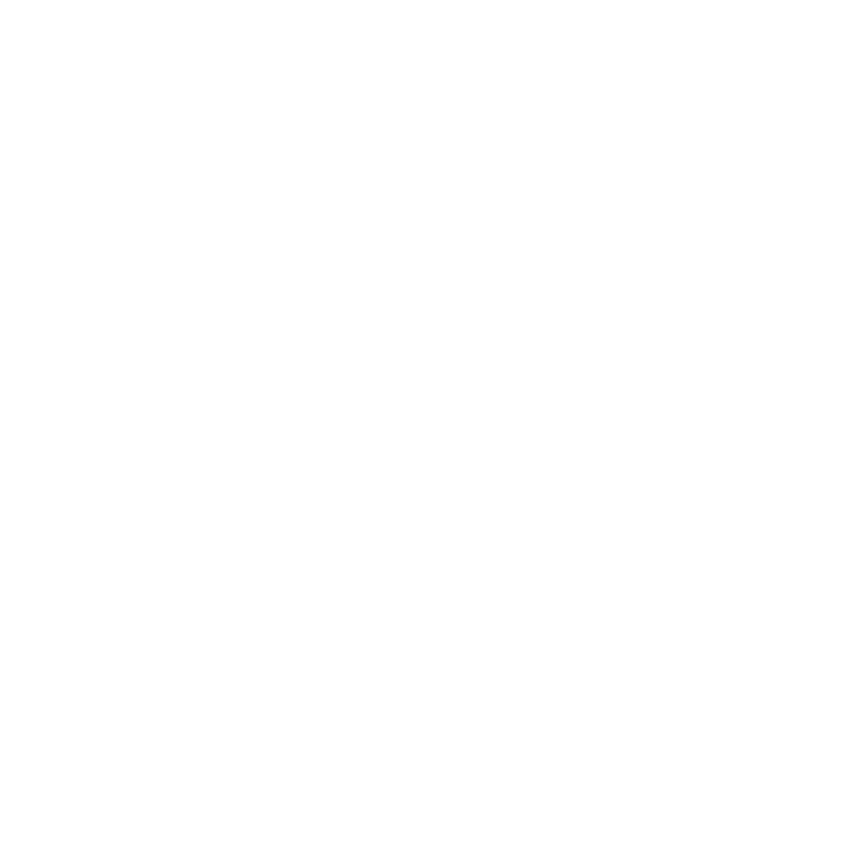

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'

example_primal_node_id = 21

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_border_color, 
               s=50)

plot_node(ax, example_primal_node_id)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c='grey')
    
for edge_id in edge_dict:
    start_node = edge_id[0]
    end_node = edge_id[1]
    start_coords = node_dict[start_node]
    end_coords = node_dict[end_node]
    plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c='blue')

for face in get_auxiliary_dual_faces(example_primal_node_id):
    for i in range(len(face)): #sanity check: len(face) should be 4 always
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])

#### Define function to get coordinates of the boundary dual face corresponding to a boundary primal edge

Points to emphasize:
- the output is not an auxiliary dual face
- by definition, get_boundary_dual_face() only works for a primal edge which lies on a boundary face (i.e. a face which belongs to only one tet).

In [26]:
def get_boundary_dual_face(edge_id):
    
    """
    inputs:  
        - edge id of boundary primal edge (array of int)
    output: 
    - list of coordinates of the nodes of the boundary dual face 
    - corresponding to that primal edge (list of arrays of floats)
    """
    
    boundary_dual_face = []
    boundary_dual_face.append(get_midpoint(edge_nodes = edge_id)) # start at midpoint of edge
    
    # get boundary primal faces which contain that edge, there should be 2
    primal_face_candidates = []
    for primal_face in boundary_dual_edge_dict: # keys of this dict are indeed boundary primal faces
        primal_face_edges = set(itertools.combinations(primal_face, 2)) 
        if {edge_id}.issubset(primal_face_edges):
            primal_face_candidates.append(primal_face)
    
    primal_face_candidates.sort()
    
    primal_face_1 = primal_face_candidates[0]
    primal_face_2 = primal_face_candidates[1]

    boundary_dual_face.append(boundary_dual_edge_dict[primal_face_1]) # boundary dual node of face 1 in tet 1
    
    """
    - If edge belongs to only one tet, then the next vertex is the dual volume of the tet
    - Otherwise, if edge is shared between two or more tets, the next vertices are
    the subloop of interior tet dual nodes 
    """

    # get sequence of all tets the primal edge belongs to, and
    # if needed, reverse the above list so that the first tet in the reversed list matches
    # the tet that primal_face_1 belongs to
    tets = get_dual_face(edge_id)
    
    if face_dict[primal_face_1][0] != tets[0]: # face_dict[primal_face_1] only contains one tet, because primal_face_1 is a boundary face
        tets = np.flip(tets)
    
    # boundary dual face consist of dual nodes of those primal tets
    for tet in tets:
        dual_node = dual_node_dict[tet]
        boundary_dual_face.append(dual_node)
        
    # boundary dual node of face 2 in tet 2
    boundary_dual_face.append(boundary_dual_edge_dict[primal_face_2])
    
    return boundary_dual_face

#### Define function to get all dual faces of a boundary primal node (i.e. a boundary primal node is one that belongs to a boundary primal face).

Note: this function is not used further. 

In [27]:
def get_boundary_dual_faces(node_id):
    
    """
    input: node id of boundary primal node (int)
    output: list of list of coordinates of nodes of the faces  (list of list of arrays of floats)
    """
    
    # get the primal edges that the primal node belongs to 
    # note: this is an inefficient implementation, so need to revise
    # note: this list of primal edges has both boundary primal edges and interior primal edges
    primal_edges = [] 
    for edge_id in edge_dict: 
        if node_id in edge_id: 
            primal_edges.append(edge_id)
    
   # for each of the above primal edges, get the boundary dual face containing the primal node
    boundary_dual_faces = []
    for primal_edge in primal_edges:
        boundary_dual_face = get_boundary_dual_face(edge_id = primal_edge)
        boundary_dual_faces.append(boundary_dual_face)
    
    return boundary_dual_faces

Note: need to fix this for boundary nodes which do not lie in the corner of the primal mesh. Currently, the function does not work because such primal nodes belong to non-boundary primal edges, while get_boundary_dual_face() (which is needed in the implementation of get_boundary_dual_faces()) only works for boundary primal edges.

In [28]:
get_boundary_dual_faces(node_id=2)

[[array([ 0.359375, -0.5     ,  0.359375]),
  array([ 0.25   , -0.5    ,  0.46875]),
  array([ 0.25   , -0.375  ,  0.46875]),
  array([ 0.3125 , -0.3125 ,  0.40625]),
  array([ 0.46875, -0.5    ,  0.25   ])],
 [array([ 0.3125, -0.3125,  0.5   ]),
  array([ 0.25 , -0.375,  0.5  ]),
  array([ 0.25   , -0.375  ,  0.46875]),
  array([ 0.3125 , -0.3125 ,  0.40625]),
  array([ 0.375, -0.25 ,  0.5  ])],
 [array([ 0.5     , -0.359375,  0.359375]),
  array([ 0.5    , -0.46875,  0.25   ]),
  array([ 0.375  , -0.25   ,  0.46875]),
  array([ 0.3125 , -0.3125 ,  0.40625]),
  array([ 0.5    , -0.25   ,  0.46875])],
 [array([ 0.25, -0.5 ,  0.5 ]),
  array([ 0.25   , -0.5    ,  0.46875]),
  array([ 0.25   , -0.375  ,  0.46875]),
  array([ 0.25 , -0.375,  0.5  ])],
 [array([ 0.5 , -0.25,  0.5 ]),
  array([ 0.375, -0.25 ,  0.5  ]),
  array([ 0.375  , -0.25   ,  0.46875]),
  array([ 0.5    , -0.25   ,  0.46875])],
 [array([ 0.5 , -0.5 ,  0.25]),
  array([ 0.46875, -0.5    ,  0.25   ]),
  array([ 0.46875,

#### Create dictionary of the complete set of coordinates of the dual nodes of each dual face (dual faces correspond bijectively with primal edges)

Note: This dictionary contains all the dual faces which correspond to primal edges (which include both regular dual faces and "boundary dual faces"), but it does NOT contain "auxiliary dual faces" because these faces do not correspond with any primal edge. Therefore, for the sake of absolute clarity, we mention here that this dictionary is only "complete" in the sense that it contains the complete set of the dual faces corresponding to primal edges; however, it is NOT a complete dictionary of all the dual faces (because some dual faces do not correspond to primal edges).

In [29]:
complete_coords_dual_face_dict = {}

"""
key: primal edge id (list of array of floats)
value: coords of face (array of floats)
- if the edge belongs to at least one face which is at the boundary, then use get_boundary_dual_face()
- otherwise, get dual face from get_dual_face(), then use dual_node_dict to get coords
- of each dual node of the dual face
"""

def get_complete_coords_dual_face(edge_id):
    
    # determine if the given primal edge is on the boundary, by seeing if
    # it lies in at least one boundary primal face
    edge_on_boundary = False
    
    for boundary_face in boundary_dual_edge_dict: # boundary_dual_edge_dict contains all boundary primal faces
        if set(edge_id).issubset(set(boundary_face)):
            edge_on_boundary = True
            break # stop the search if the edge is a subset of at least one boundary primal face
    
    # get the coords of the dual face, according to whether or not the edge is on the boundary       
    if edge_on_boundary == True:
        # if primal edge is on the boundary, use get_boundary_dual_face which
        complete_coords_dual_face = get_boundary_dual_face(edge_id)
    
    else:
        # if primal edge not on boundary, then dual face is characterized by a closed loop
        # of dual nodes of primal tets, which is given by get_dual_face
        complete_coords_dual_face = []
        for tet in get_dual_face(edge_id):
            complete_coords_dual_face.append(dual_node_dict[tet])
        
    return complete_coords_dual_face

# populate the dict
for edge_id in tqdm_notebook(edge_dict):
    complete_coords_dual_face_dict[edge_id] = get_complete_coords_dual_face(edge_id)

# display the dict
complete_coords_dual_face_dict

  0%|          | 0/186 [00:00<?, ?it/s]

{(21, 24): [array([-0.20214844, -0.5       , -0.04785156]),
  array([-0.27953339, -0.5       , -0.02953339]),
  array([-0.27953339, -0.29727597, -0.02953339]),
  array([-0.21738317, -0.24039667, -0.04424527]),
  array([-0.10107422, -0.5       , -0.07177734])],
 (21, 40): [array([-0.21738317, -0.24039667, -0.04424527]),
  array([-0.17734754, -0.18917681, -0.18493899]),
  array([-0.328125, -0.296875, -0.421875]),
  array([-0.5    , -0.46875, -0.25   ]),
  array([-0.27953339, -0.29727597, -0.02953339])],
 (24, 40): [array([-0.21738317, -0.24039667, -0.04424527]),
  array([-0.2270213 , -0.23345536, -0.03008036]),
  array([-0.28574108, -0.28645833, -0.015625  ]),
  array([-0.27953339, -0.29727597, -0.02953339])],
 (21, 45): [array([-0.21738317, -0.24039667, -0.04424527]),
  array([-0.17734754, -0.18917681, -0.18493899]),
  array([-0.05836734, -0.23880953, -0.19989797]),
  array([-0.10107422, -0.28245199, -0.07177734])],
 (40, 45): [array([-0.21738317, -0.24039667, -0.04424527]),
  array([-0

#### Create dictionary of list of coordinates of the dual faces making up the dual volumes (each dual volume corresponds bijectively to a primal node)

Note that this dictionary is "complete" in the sense that it contains info about the dual volumes corresponding to all of the primal nodes of the primal mesh.

In [30]:
complete_coords_dual_volume_dict = {}

"""
key: primal edge id (list of array of floats)
value: list of coords of faces (array of floats)
- if the node belongs to at least one face which is at the boundary 
- otherwise, all of its faces
"""

#### draft implementation (not used) ####
# def get_complete_coords_dual_volume(node_id):
#     
#     # boundary_dual_edge_dict contains all faces which are at the boundary
#     node_on_boundary = False
#     
#     for boundary_face in boundary_dual_edge_dict:
#         if node_id in boundary_face:
#             node_on_boundary = True
#             break
#             
#     if node_on_boundary == True:
#         complete_coords_dual_faces = get_boundary_dual_faces(node_id)
#     else:
#         complete_coords_dual_faces = []
#         for dual_faces in get_dual_volume(node_id):
#             dual_face_coords = []
#             for node in dual_face:
#                 dual_face_coords.append(dual_node_dict[node])
#             dual_face_coords = np.array(dual_face_coords)
#             complete_coords_dual_faces.append(dual_face_coords)
#         
#     return complete_coords_dual_faces

def get_complete_coords_dual_volume(node_id):
    
    complete_coords_dual_volume = []
    
    # get coords of the dual faces corresponding to each primal edge containing node_id (boundary or interior)
    for edge_id in edge_dict:
        if node_id in edge_id:
            complete_coords_dual_volume.append(complete_coords_dual_face_dict[edge_id])
    
    # get coords of auxiliary dual faces corresponding to each boundary primal edge containing node_id
    auxiliary_faces = []
    for boundary_face in boundary_dual_edge_dict:
        if node_id in boundary_face:
            auxiliary_face = get_auxiliary_dual_face(node_id = node_id, face_id = boundary_face)
            auxiliary_faces.append(auxiliary_face)
    
    # combine lists
    complete_coords_dual_volume.extend(auxiliary_faces)
    
    return complete_coords_dual_volume

# populate dict
from tqdm.notebook import tqdm_notebook
import time

for node_id in tqdm_notebook(node_dict):
    complete_coords_dual_volume_dict[node_id] = get_complete_coords_dual_volume(node_id)

# display dict
complete_coords_dual_volume_dict    

  0%|          | 0/45 [00:00<?, ?it/s]

{1: [[array([-0.32714844, -0.5       ,  0.32714844]),
   array([-0.25      , -0.5       ,  0.40429687]),
   array([-0.40429688, -0.375     ,  0.25      ]),
   array([-0.37402344, -0.34472656,  0.28027344]),
   array([-0.40429688, -0.5       ,  0.25      ])],
  [array([-0.5   , -0.3125,  0.3125]),
   array([-0.5  , -0.375,  0.25 ]),
   array([-0.40429688, -0.375     ,  0.25      ]),
   array([-0.37402344, -0.34472656,  0.28027344]),
   array([-0.5  , -0.25 ,  0.375])],
  [array([-0.359375, -0.359375,  0.5     ]),
   array([-0.25   , -0.46875,  0.5    ]),
   array([-0.46875, -0.25   ,  0.375  ]),
   array([-0.37402344, -0.34472656,  0.28027344]),
   array([-0.46875, -0.25   ,  0.5    ])],
  [array([-0.5 , -0.5 ,  0.25]),
   array([-0.40429688, -0.5       ,  0.25      ]),
   array([-0.40429688, -0.375     ,  0.25      ]),
   array([-0.5  , -0.375,  0.25 ])],
  [array([-0.5 , -0.25,  0.5 ]),
   array([-0.46875, -0.25   ,  0.5    ]),
   array([-0.46875, -0.25   ,  0.375  ]),
   array([-0.5 

#### Example visualization

<IPython.core.display.Javascript object>


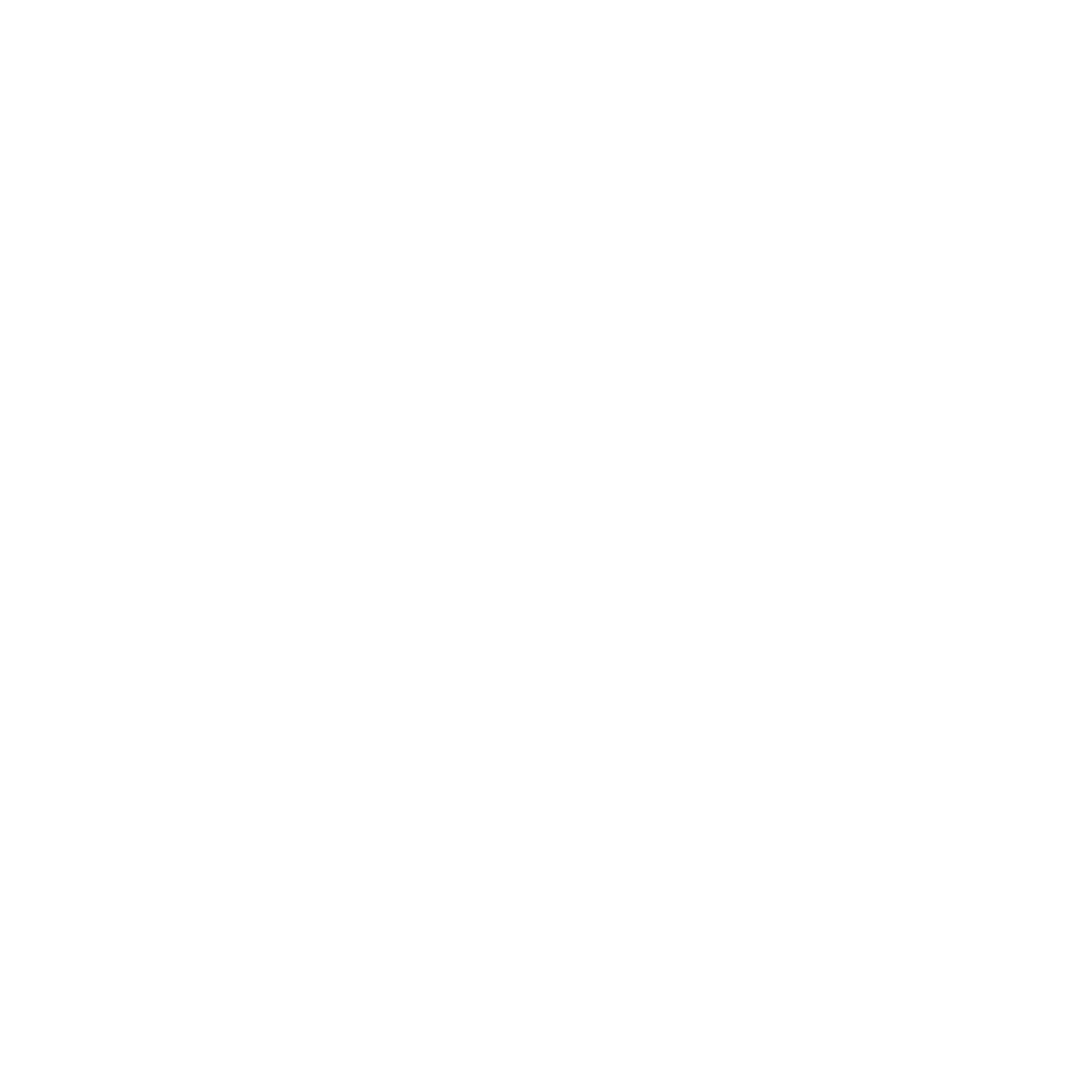

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.axes(projection='3d')

node_id = 21

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c='grey')
    
for edge_id in edge_dict:
    start_node = edge_id[0]
    end_node = edge_id[1]
    start_coords = node_dict[start_node]
    end_coords = node_dict[end_node]
    plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c='blue')

plot_node(ax, node_id)
for face in get_complete_coords_dual_volume(node_id=node_id):
    for i in range(len(face)): 
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])

In [32]:
print("Number of dual faces in the dual volume corresponding to node ", 
      node_id,
      len(get_complete_coords_dual_volume(node_id=node_id))
     )

Number of dual faces in the dual volume corresponding to node  21 13


<IPython.core.display.Javascript object>


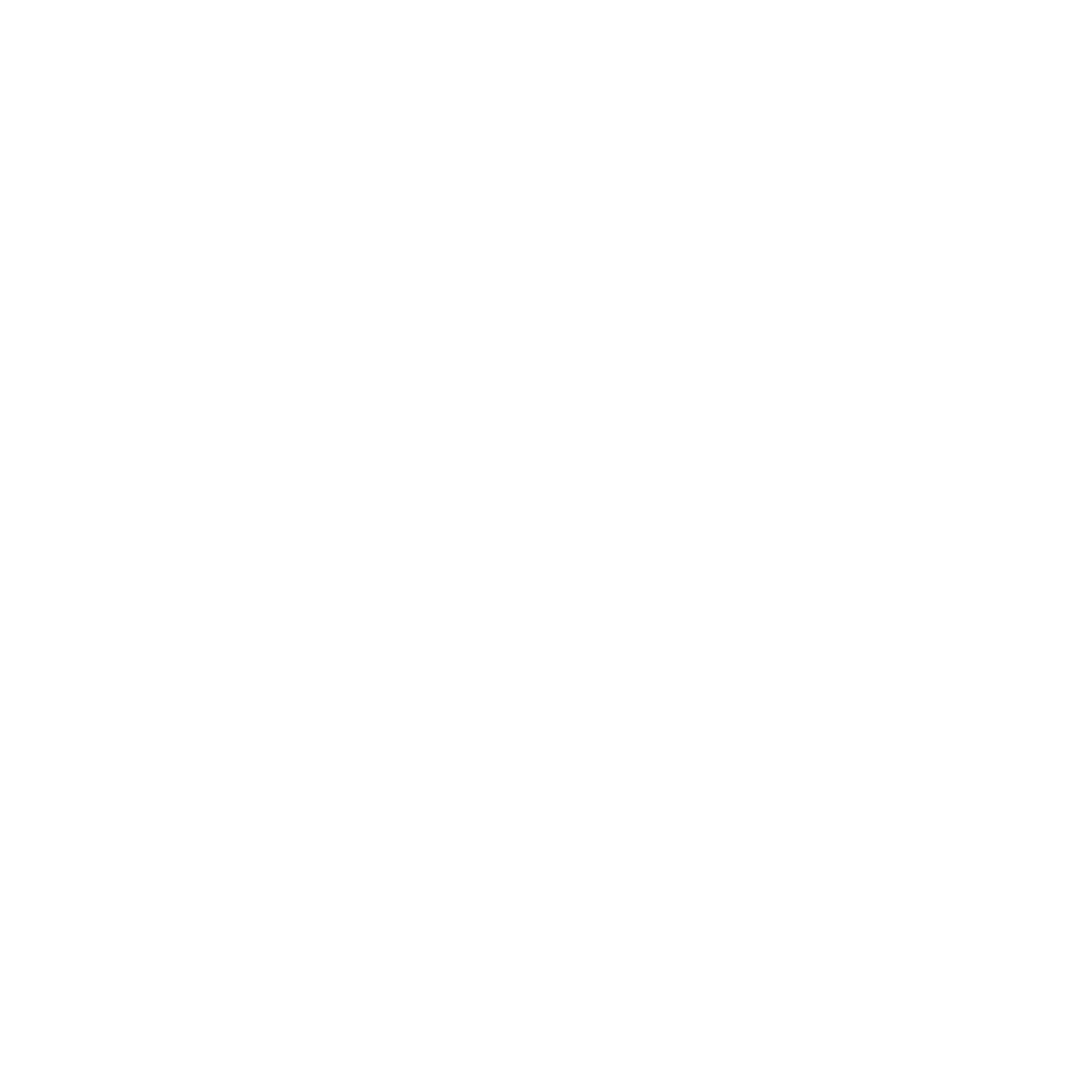

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'
dual_edge_color = '#8A307F'

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, edgecolor = primal_node_border_color, s=50)

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.axes(projection='3d')

node_id = 20

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color, 
              linewidth=1.2)

plot_node(ax, node_id)
    
for edge_id in edge_dict:
    if node_id in edge_id:
        start_node = edge_id[0]
        end_node = edge_id[1]
        start_coords = node_dict[start_node]
        end_coords = node_dict[end_node]
        plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color, linewidth=1.2)

for face in get_complete_coords_dual_volume(node_id=node_id):
    for i in range(len(face)): 
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])

<IPython.core.display.Javascript object>


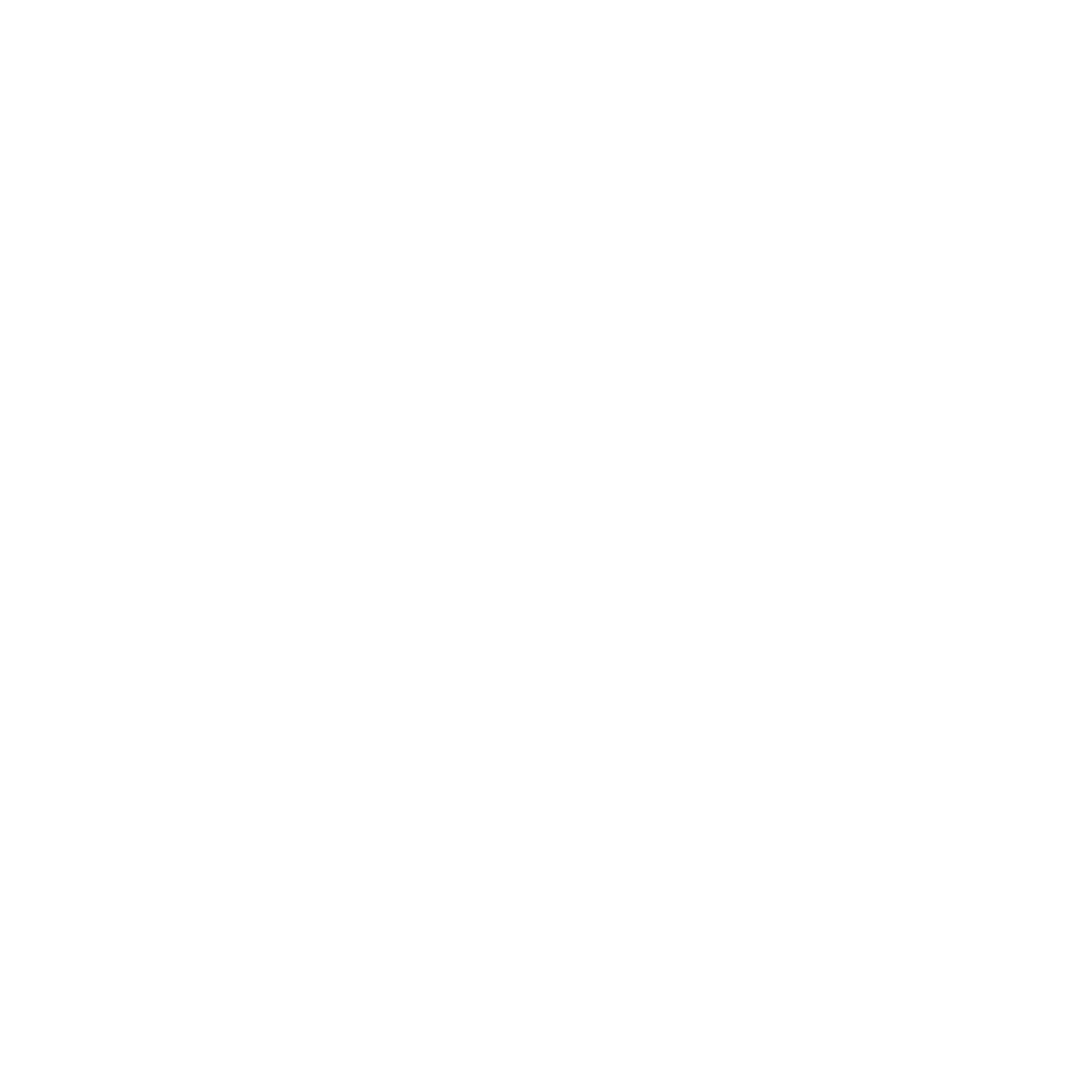

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

primal_node_color = 'mediumpurple'
primal_node_edge_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'
dual_edge_color = '#8A307F'

node_id_1 = 32
node_id_2 = 30

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, edgecolor = primal_node_edge_color, s=50)

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.axes(projection='3d')

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color, 
              linewidth=1.2)

plot_node(ax, node_id_1)
    
for edge_id in edge_dict:
    if node_id_1 in edge_id:
        start_node = edge_id[0]
        end_node = edge_id[1]
        start_coords = node_dict[start_node]
        end_coords = node_dict[end_node]
        plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color, linewidth=1.2)

for face in get_complete_coords_dual_volume(node_id=node_id_1):
    for i in range(len(face)): 
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])

        ###

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color, 
              linewidth=1.2)

plot_node(ax, node_id_2)
    
for edge_id in edge_dict:
    if node_id_2 in edge_id:
        start_node = edge_id[0]
        end_node = edge_id[1]
        start_coords = node_dict[start_node]
        end_coords = node_dict[end_node]
        plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color, linewidth=1.2)

for face in get_complete_coords_dual_volume(node_id=node_id_2):
    for i in range(len(face)): 
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])

#### define function to determine if circumcenter of tetrahedron is inside tetrahedron

- https://everipedia.org/Barycentric_coordinate_system
- circumcenter inside or on boundary of tetrahedron $\iff$ all barycentric coords of circumcenter $\in [0,1]$

In [35]:
def circumcenter_inside_tet(tetrahedron_id):
    
    """
    input:
    - primal tet id (int)
    
    output:
    - whether or not circumcenter is inside the tet, boundary also counts (boolean)
    """
    
    # get primal nodes of tetrahedron
    tet_nodes = tetrahedron_dict[tetrahedron_id]
    
    # get vector of coordinates of primal nodes
    r1 = node_dict[tet_nodes[0]]
    r2 = node_dict[tet_nodes[1]]
    r3 = node_dict[tet_nodes[2]]
    r4 = node_dict[tet_nodes[3]]
    
    # get each component
    x1 = r1[0]
    x2 = r2[0]
    x3 = r3[0]
    x4 = r4[0]
    
    y1 = r1[1]
    y2 = r2[1]
    y3 = r3[1]
    y4 = r4[1]
    
    z1 = r1[2]
    z2 = r2[2]
    z3 = r3[2]
    z4 = r4[2]
    
    # get barycenter of dual node according to formula
    T = np.matrix([
        [x1-x4, x2-x4, x3-x4],
        [y1-y4, y2-y4, y3-y4],
        [z1-z4, z2-z4, z3-z4]
    ])
    
    r = dual_node_dict[tetrahedron_id]
    
    b_coords = np.matmul(np.linalg.inv(T), np.matrix(r-r4).transpose())
    
    # determine if circumcenter inside or outside
    # i.e. circumcenter is outside if barycentric coords are not in the range [0,1]
    circumcenter_is_inside = True
    if b_coords[0] < 0 or b_coords[1] < 0 or b_coords[2] < 0 or b_coords[0] > 1 or b_coords[1] > 1 or b_coords[2] > 1:
        circumcenter_is_inside = False
    
    return circumcenter_is_inside

TO-DO for 8/4:
-check circumcenter inside tet and triangle functions are correct by comparing to gmsh (see the tets and triangles whose circumcenters are outside, then use Gmsh to inspect visually)
-if above is correct, then proceed further with debugging the rest of the code

#### define function to determine if circumcenter of triangle is inside triangle

circumcenter inside or on boundary of triangle $\iff$ each of the 3 angles is at most $\pi/2$ (i.e. triangle is acute)

In [36]:
def circumcenter_inside_triangle(face_id):
    
    """
    input:
    - primal face id (tuple of int)
    
    output:
    - whether or not circumcenter is inside the triangle, boundary also counts (boolean)
    """
    
    circumcenter_inside_triangle = True 
    
    # helper function to get norm of vector
    def norm(vector_coords):
        return np.sqrt(vector_coords[0]**2 + vector_coords[1]**2 + vector_coords[2]**2)
    
    #####################################
    
    # for first node, form the two vectors which originate from that node to each of the other nodes
    vector1 = node_dict[face_id[1]] - node_dict[face_id[0]]
    vector2 = node_dict[face_id[2]] - node_dict[face_id[0]]
    
    # get angle between the two vectors (in radians)
    angle1 = np.arccos(np.dot(vector1, vector2)/(norm(vector1) * norm(vector2))) 
    
    # if angle is over pi/2, then multiplier is -1
    if angle1 > np.pi/2:
        circumcenter_inside_triangle = False 
        return circumcenter_inside_triangle
    
    #####################################

    vector1 = node_dict[face_id[0]] - node_dict[face_id[1]]
    vector2 = node_dict[face_id[2]] - node_dict[face_id[1]]
    
    # get angle between the two vectors (in radians)
    angle1 = np.arccos(np.dot(vector1, vector2)/(norm(vector1) * norm(vector2))) 
    
    # if angle is over pi/2, then multiplier is -1
    if angle1 > np.pi/2:
        circumcenter_inside_triangle = False 
        return circumcenter_inside_triangle
    
    #####################################

    vector1 = node_dict[face_id[1]] - node_dict[face_id[2]]
    vector2 = node_dict[face_id[0]] - node_dict[face_id[2]]
    
    # get angle between the two vectors (in radians)
    angle1 = np.arccos(np.dot(vector1, vector2)/(norm(vector1) * norm(vector2))) 
    
    # if angle is over pi/2, then multiplier is -1
    if angle1 > np.pi/2:
        circumcenter_inside_triangle = False 
        return circumcenter_inside_triangle
    
    return circumcenter_inside_triangle

#### define function to get the area of a subregion of a dual face

In [37]:
def get_subregion_area(midpoint, tet_id, face_1, face_2):

    """
    Calculates the area of the subregion/slice of the dual face.
    The dual face corresponds to the primal edge whose mid-point is midpoint.
    The subregion is identified uniquely with dual_node.
    As discussed previously, the subregion can be described by 4 points: 
    midpoint, the dual node corresponding to tet_id, the circumcenter of face_1, and the circumcenter of face_2.

    Depending on the situation, face_1 and face_2 may be either a boundary face, 
    or an interior face shared between two tets.
    """

    circumcenter_1 = get_triangle_circumcenter(face_id=face_1)
    circumcenter_2 = get_triangle_circumcenter(face_id=face_2)
    
    dual_node = dual_node_dict[tet_id]

    # triangle_a = [midpoint, circumcenter_1, dual_node]
    # triangle_b = [midpoint, dual_node, circumcenter_2]

    # helper function to get distance between two points
    def distance(coords_1, coords_2):
        value = np.sqrt((coords_1[0]-coords_2[0])**2 + (coords_1[1]-coords_2[1])**2 + (coords_1[2]-coords_2[2])**2)
        return value

    # calculate multipliers
    circumcenter_inside_tet_multiplier = 1
    if not circumcenter_inside_tet(tetrahedron_id=tet_id):
        circumcenter_inside_tet_multiplier = -1 #-1

    circumcenter_inside_face_1_multiplier = 1
    if not circumcenter_inside_triangle(face_id=face_1):
        circumcenter_inside_face_1_multiplier = -1 #-1

    circumcenter_inside_face_2_multiplier = 1
    if not circumcenter_inside_triangle(face_id=face_2):
        circumcenter_inside_face_2_multiplier = -1 #-1

    triangle_a_multiplier = circumcenter_inside_tet_multiplier * circumcenter_inside_face_1_multiplier
    triangle_b_multiplier = circumcenter_inside_tet_multiplier * circumcenter_inside_face_2_multiplier

    # calculate areas
    triangle_a_area = triangle_a_multiplier * 0.5 * distance(midpoint, circumcenter_1) * distance(circumcenter_1, dual_node)
    triangle_b_area = triangle_b_multiplier * 0.5 * distance(midpoint, circumcenter_2) * distance(circumcenter_2, dual_node)

    subregion_area = triangle_a_area + triangle_b_area

    return subregion_area   

#### define function to get the dual area of a boundary dual face corresponding to a boundary primal edge

In [38]:
def get_boundary_dual_face_area(edge_id):
    
    """
    input: 
    - edge id of a boundary primal edge (tuple of ints)
    
    output:
    - area of the dual face according to the paper 
    - "Numerical electromagnetic frequency domain analysis with discrete exterior calculus")
    (float) 
    """
    
    dual_face_area = 0
    
    ##########################################################################################
    # This section is similar to get_boundary_dual_face. 
    # However, we modify it somewhat because in the dual face calculation we also
    # need the circumcenters of the primal faces shared by adjacent tets whose
    # dual nodes form part of the boundary dual face.
    
    # midpoint of primal edge is used in all sub-triangle calculations
    mp = get_midpoint(edge_nodes = edge_id)
    
    # get boundary primal faces which contain that edge, there should be 2
    primal_face_candidates = []
    for primal_face in boundary_dual_edge_dict: 
        primal_face_edges = set(itertools.combinations(primal_face, 2)) 
        if {edge_id}.issubset(primal_face_edges):
            primal_face_candidates.append(primal_face)
    
    primal_face_candidates.sort()
    
    primal_face_1 = primal_face_candidates[0]
    primal_face_2 = primal_face_candidates[1]
    
    """
    - If edge belongs to only one tet, then the next vertex is the dual volume of the tet
    - Otherwise, if edge is shared between two or more tets, the next vertices are
    the subloop of interior tet dual nodes 
    """

    # get sequence of all tets the primal edge belongs to, and
    # if needed, reverse the above list so that the first tet in the reversed list matches
    # the tet that primal_face_1 belongs to
    tets = get_dual_face(edge_id)
    
    if face_dict[primal_face_1][0] != tets[0]: # face_dict[primal_face_1] only contains one tet, because primal_face_1 is a boundary face
        tets = np.flip(tets)
    
    ##########################################################################################
    
    ##########################################################################################
    # This section only works if primal edge is on boundary and is shared between two or more tets
    
    # Get the starting subregion, correspnding bijectively to the first dual node (belonging to boundary tet)
    # It is defined by 4 points.
    # The 4 points are: midpoint of primal edge (mp), circumcenter of boundary primal face 1 (cbf1), 
    # dual node of tet 1 (dnt1), and circumcenter of the primal face shared between tet 1 and tet 2 (cpf12)
    # This subregion will be split up into two triangles, whose individual effective areas can be calculated.
    if len(tets) > 1 :

        tet_1 = tets[0]

        tet_1_nodes = set(tetrahedron_dict[tets[0]])
        tet_2_nodes = set(tetrahedron_dict[tets[1]])
        common_face_1_2 = list(tet_1_nodes.intersection(tet_2_nodes))
        common_face_1_2.sort()
        common_face_1_2 = tuple(common_face_1_2)

        dual_face_area +=  get_subregion_area(midpoint=mp, tet_id=tet_1, face_1=primal_face_1, face_2=common_face_1_2)

        # get areas of each of the subregions corresponding to the 2nd through 2nd to last dual nodes
        for i in range(len(tets)-2):

            tet = tets[i+1]

            tet_i_nodes = set(tetrahedron_dict[tets[i]])
            tet_iplus1_nodes = set(tetrahedron_dict[tets[i+1]])
            common_face_i_iplus1 = list(tet_i_nodes.intersection(tet_iplus1_nodes))
            common_face_i_iplus1.sort()
            common_face_i_iplus1 = tuple(common_face_i_iplus1)

            tet_iplus2_nodes = set(tetrahedron_dict[tets[i+2]])
            common_face_iplus1_iplus2 = list(tet_iplus1_nodes.intersection(tet_iplus2_nodes))
            common_face_iplus1_iplus2.sort()
            common_face_iplus1_iplus2 = tuple(common_face_iplus1_iplus2)

            dual_face_area += get_subregion_area(midpoint=mp, 
                                                 tet_id=tet, 
                                                 face_1=common_face_i_iplus1,
                                                 face_2=common_face_iplus1_iplus2)

        # get area of ending subregion corresponding to the last dual node (belonging to boundary tet)
        tet_minus1 = tets[-1]

        tet_minus2_nodes = set(tetrahedron_dict[tets[-2]])
        tet_minus1_nodes = set(tetrahedron_dict[tets[-1]])
        common_face_minus2_minus1 = list(tet_1_nodes.intersection(tet_2_nodes))
        common_face_minus2_minus1.sort()
        common_face_minus2_minus1 = tuple(common_face_minus2_minus1)

        dual_face_area += get_subregion_area(midpoint=mp, tet_id=tet_minus1, face_1=common_face_minus2_minus1, face_2=primal_face_2)
    
    ##########################################################################################
    # this section works if primal edge is at the corner of the primal mesh (it only belongs to one tet),
    # so that len(tets) = 1
    else:
        tet = tets[0]
        dual_face_area +=  get_subregion_area(midpoint=mp, tet_id=tet, face_1=primal_face_1, face_2=primal_face_2)
    ##########################################################################################
    
    return dual_face_area

#### Create dictionary of dual face areas corresponding to boundary primal edges

In [39]:
boundary_dual_face_area_dict = {}

"""
key: edge_id of boundary primal edge (tuple of int)
value: area of the corresponding dual face (float)
"""

boundary_primal_edges = []
for edge_id in edge_dict:
    add = True
    if edge_id in boundary_primal_edges:
        add = False
    for primal_face in boundary_dual_edge_dict: 
        primal_face_edges = set(itertools.combinations(primal_face, 2)) 
        if {edge_id}.issubset(primal_face_edges) and add:
            boundary_primal_edges.append(edge_id)
            break

for boundary_primal_edge in tqdm_notebook(boundary_primal_edges):
    boundary_dual_face_area_dict[boundary_primal_edge] = get_boundary_dual_face_area(edge_id=boundary_primal_edge)
    
boundary_dual_face_area_dict

  0%|          | 0/126 [00:00<?, ?it/s]

{(21, 24): -0.001953570120719599,
 (42, 44): -0.011582812536020282,
 (29, 31): -0.0023252781237926992,
 (25, 26): -0.005469236340428622,
 (38, 40): -0.0594266951502756,
 (33, 35): 0.013610215288312348,
 (22, 23): 0.058456743799489244,
 (35, 36): 0.04855475124042484,
 (41, 42): 0.051281046245892206,
 (27, 28): 0.013753154173368254,
 (23, 24): 0.04810090179422172,
 (12, 21): -0.01520918829323279,
 (12, 40): -0.03814497875367889,
 (12, 24): -0.01151515367068568,
 (13, 29): -0.01428265642975538,
 (13, 31): -0.012386164335073398,
 (13, 27): -0.035467859617612715,
 (15, 25): -0.03239764985270278,
 (15, 33): -0.030603166607381594,
 (15, 26): -0.007963775310725778,
 (41, 43): 0.044122382638502544,
 (10, 23): 0.030746037988308016,
 (10, 42): -0.026005326763886262,
 (10, 22): 0.04739470505749516,
 (43, 44): 0.04867856031141288,
 (34, 36): 0.05792889941148266,
 (21, 22): 0.05060146115088303,
 (30, 32): -0.004790660855985763,
 (33, 34): 0.051416454052403415,
 (39, 40): 0.014993510655598317,
 (29, 

Note it is possible for a dual area to be negative, but the dual volumes later should always be positive with Delaunay mesh generation (is this statement correct?)

#### Define function to get the dual face area corresponding to an interior primal edge

In [40]:
def get_interior_dual_face_area(edge_id):
    
    """
    input: 
    - edge id of an interior primal edge (tuple of ints)
    
    output:
    - area of the dual face according to the paper 
    - "Numerical electromagnetic frequency domain analysis with discrete exterior calculus")
    (float) 
    """
    
    dual_face_area = 0
    
    tets = get_dual_face(edge_id)

    # midpoint of primal edge is used in all sub-triangle calculations
    mp = get_midpoint(edge_nodes = edge_id)
    
    # get area of subregion corresponding to the first dual node
    tet_1 = tets[0]
    
    tet_minus1_nodes = set(tetrahedron_dict[tets[-1]])
    tet_first_nodes = set(tetrahedron_dict[tets[0]])
    common_face_minus1_first = list(tet_first_nodes.intersection(tet_minus1_nodes))
    common_face_minus1_first.sort()
    common_face_minus1_first = tuple(common_face_minus1_first)

    tet_second_nodes = set(tetrahedron_dict[tets[1]])
    common_face_first_second = list(tet_first_nodes.intersection(tet_second_nodes))
    common_face_first_second.sort()
    common_face_first_second = tuple(common_face_first_second)

    dual_face_area += get_subregion_area(midpoint=mp, 
                                         tet_id=tet_1, 
                                         face_1=common_face_minus1_first,
                                         face_2=common_face_first_second)
    
    # get areas of each of the subregions corresponding to the 2nd through 2nd to last dual nodes
    if len(tets) > 2:
        for i in range(len(tets)-2):

            tet = tets[i+1]

            tet_i_nodes = set(tetrahedron_dict[tets[i]])
            tet_iplus1_nodes = set(tetrahedron_dict[tets[i+1]])
            common_face_i_iplus1 = list(tet_i_nodes.intersection(tet_iplus1_nodes))
            common_face_i_iplus1.sort()
            common_face_i_iplus1 = tuple(common_face_i_iplus1)

            tet_iplus2_nodes = set(tetrahedron_dict[tets[i+2]])
            common_face_iplus1_iplus2 = list(tet_iplus1_nodes.intersection(tet_iplus2_nodes))
            common_face_iplus1_iplus2.sort()
            common_face_iplus1_iplus2 = tuple(common_face_iplus1_iplus2)

            dual_face_area += get_subregion_area(midpoint=mp, 
                                                 tet_id=tet, 
                                                 face_1=common_face_i_iplus1,
                                                 face_2=common_face_iplus1_iplus2)

    # get area of subregion corresponding to the last dual node
    tet_minus1 = tets[-1]

    tet_minus2_nodes = set(tetrahedron_dict[tets[-2]])
    tet_minus1_nodes = set(tetrahedron_dict[tets[-1]])
    common_face_minus2_minus1 = list(tet_minus2_nodes.intersection(tet_minus1_nodes))
    common_face_minus2_minus1.sort()
    common_face_minus2_minus1 = tuple(common_face_minus2_minus1)

    tet_first_nodes = set(tetrahedron_dict[tets[0]])
    common_face_minus1_first = list(tet_first_nodes.intersection(tet_minus1_nodes))
    common_face_minus1_first.sort()
    common_face_minus1_first = tuple(common_face_minus1_first)

    dual_face_area += get_subregion_area(midpoint=mp, 
                                         tet_id=tet_minus1, 
                                         face_1=common_face_minus2_minus1,
                                         face_2=common_face_minus1_first)
    
    return dual_face_area

#### Create dictionary of dual face areas corresponding to interior primal edges

In [41]:
interior_dual_face_area_dict = {}

"""
key: edge_id of interior primal edge (tuple of int)
value: area of the corresponding dual face (float)
"""

interior_primal_edges = list(set(edge_dict).difference(set(boundary_primal_edges)))
interior_primal_edges.sort()

for interior_primal_edge in tqdm_notebook(interior_primal_edges):
    interior_dual_face_area_dict[interior_primal_edge] = get_interior_dual_face_area(interior_primal_edge)
    
interior_dual_face_area_dict

  0%|          | 0/60 [00:00<?, ?it/s]

{(21, 34): 0.030944671319132894,
 (21, 40): 0.049700567829852584,
 (21, 45): 0.018174307351493574,
 (22, 34): 0.009620278560724548,
 (22, 36): 0.058697335896204426,
 (22, 42): 0.052113384814240514,
 (22, 45): 0.07420949064605592,
 (23, 30): 0.047248721635034165,
 (23, 42): 0.011707072194928631,
 (23, 44): 0.056146361888819885,
 (23, 45): 0.015621269812799127,
 (24, 30): 0.0065903160619623655,
 (24, 32): 0.04273235255001476,
 (24, 38): -0.0013673871326599623,
 (24, 40): -0.001716322298363598,
 (24, 45): 0.046920769151582595,
 (25, 33): 0.027749247060459687,
 (25, 39): 0.04857180548150678,
 (25, 45): 0.0061024191001572865,
 (26, 33): 0.013208387167423796,
 (26, 35): 0.04074129149678715,
 (26, 41): 0.0559279216347251,
 (26, 43): 0.008092596991700915,
 (26, 45): 0.05896134132607164,
 (27, 29): 0.04666710906959289,
 (27, 31): 0.004709408712308157,
 (27, 43): 0.02998493671170785,
 (27, 45): 0.02976414152824836,
 (28, 31): 0.04255482271352301,
 (28, 37): 0.058319011945741656,
 (28, 39): 0.010

#### Create function to calculate the dual volume corresponding to a primal node

In [42]:
def get_dual_volume_value(node_id):
    
    """
    input: primal node_id (int)
    output: value of corresponding dual volume (float)
    """
    
    dual_volume = 0
    
    # get all the primal edges containing node_id
    edges = []
    for edge_id in edge_dict:
        if node_id in edge_id:
            edges.append(edge_id)
            
    # for each primal edge, get the volume of the conic sub-region
    # each conic sub-region has the dual face as the base,
    # and 1/2 the length of the primal edge as the heigh
    for edge_id in edges:
        
        # obtain the area of the dual face, depending on whether the edge is interior or on the boundary
        if edge_id in boundary_dual_face_area_dict:
            dual_face_area = boundary_dual_face_area_dict[edge_id]
        else:
            dual_face_area = interior_dual_face_area_dict[edge_id]
        
        # calculate the value of the conic sub-region, and add to tally
        cone_volume = 1/6 * dual_face_area * edge_length_dict[edge_id]
    
        dual_volume += cone_volume
    
    return dual_volume

#### Create dictionary of dual volumes corresponding to primal nodes

In [43]:
dual_volume_value_dict = {}

"""
key: primal node id (int)
value: value of corresponding dual volume (float)
"""

for node_id in tqdm_notebook(node_dict):
    dual_volume_value_dict[node_id] = get_dual_volume_value(node_id)
    
dual_volume_value_dict

  0%|          | 0/45 [00:00<?, ?it/s]

{1: 0.009220288391617905,
 2: 0.007997379782840267,
 3: 0.008211315296149595,
 4: 0.007118377606326443,
 5: 0.008761378356242317,
 6: 0.009408971463956927,
 7: 0.007819559589897997,
 8: 0.005307014285446893,
 9: -0.004037746568916977,
 10: 0.0037550337124600324,
 11: -0.006803970644808781,
 12: -0.002929153962317128,
 13: -0.00307096000481924,
 14: -0.004124256717437265,
 15: -0.0032301560459323453,
 16: -0.004680114695881678,
 17: -0.004354430532037392,
 18: -0.004354430532037391,
 19: -0.00435443053203739,
 20: -0.004354430532037392,
 21: 0.010330568110182705,
 22: 0.028763634640556177,
 23: 0.021127357358190407,
 24: 0.01382841652946564,
 25: 0.005833573650263704,
 26: 0.01957193268729355,
 27: 0.013836716710885386,
 28: 0.020307224391573755,
 29: 0.01450999494533963,
 30: 0.017140265366839557,
 31: 0.017798143808195423,
 32: 0.014058641666970101,
 33: 0.013329746907379734,
 34: 0.020170662654321898,
 35: 0.021903856477794394,
 36: 0.021120272523673538,
 37: 0.01626476013715231,
 38

In [44]:
sum(dual_volume_value_dict.values())

0.5074640227586428

In [45]:
all_values_positive = True
for i in dual_volume_value_dict.values():
    if i < 0:
        all_values_positive = False
        break
print('Are all dual volumes positive (which occurs whenever we use the Delaunay mesh algorithm)?\n', all_values_positive)

Are all dual volumes positive (which occurs whenever we use the Delaunay mesh algorithm)?
 False


Sanity check: we usually use Delauney meshing, the default 3D mesh algorithm in Gmsh, and it is known that the resulting dual volumes are always positive. We check that this is indeed the case here.

#### 8/5/2022 Points to investigate for dual volumes

We notice that not all dual volumes are positive in our program, contrary to what should be expected. Here we list a series of reasons this may be the case and/or points of potential interest.
- Use "Mesh.Algorithm = 5" and "Mesh.Algorithm3D = 1" (both corresponding to Delaunay) to generate a mesh in gmsh. So for we have been using "Mesh.Algorithm = 6" (corresponding to Fronotal-Delaunay), which may affect the result.
    - update: this did not work
- Use signed lengths. So far, we have been using unsigned lengths (volumes for dual edges).
    - update: sign of dual volumes do not depend on signed length of dual edges
- Implement the algorithm explicitly as described in the Hirani "Discrete Hodge Star" paper. The sign convention described therein may or may not be the same as the procedure outlined in the Chen paper.
    - update: emailed the authors to clarify
    - update: implementation in progress
- Investigate the sign of dual volumes when we exclude boundary nodes. There may be special conditions required at the boundary that is not satisfied by our mesh as of now.
    - in progress
- Make a well-centered mesh, and see if the sum of the dual volumes is equal to 1.
    - update: not sure how this is possible for gmsh.
- look at pyDEC

#### Other to-do:
- parsing for more general .msh files
- Start Julia code
- organize Notability notes 
- organize qurip_code folder

#### Define helper function to get pyramind volume

In [46]:
def get_pyramid_volume(coords1, coords2, coords3, coords4):
    
    # get coordinates 
    x1 = coords1[0] 
    y1 = coords1[1] 
    z1 = coords1[2]
    
    x2 = coords2[0]
    y2 = coords2[1]
    z2 = coords2[2]
    
    x3 = coords3[0]
    y3 = coords3[1]
    z3 = coords3[2]
    
    x4 = coords4[0]
    y4 = coords4[1]
    z4 = coords4[2]
    
    # use cross-product formula to get volume
    """
    https://keisan.casio.com/has10/SpecExec.cgi?path=05000000.Mathematics/01000600.Space%2520geometry/10000300.Volume%
    2520of%2520a%2520tetrahedron%2520and%2520a%2520parallelepiped/default.xml&charset=utf-8
    """
    volume = 1/6 * (
        (x4-x1)*((y2-y1)*(z3-z1)-(z2-z1)*(y3-y1)) +
        (y4-y1)*((z2-z1)*(x3-x1)-(x2-x1)*(z3-z1)) +
        (z4-z1)*((x2-x1)*(y3-y1)-(y2-y1)*(x3-x1))
    )
    
    return abs(volume)

#### Get dual volumes using the sign convention described in Hirani's "Delaunay Hodge star"

In [47]:
def get_dual_volume_value_hirani(node_id):
    
    """
    - input: primal node id
    - output: value of the dual volume, with the sign convention described in Hirani
    Using a Delunay mesh with one-sided boundary tets, all dual volumes are expected to be positive.
    """
    
    dual_volume_value = 0
    
    # get list of edges containing node_id
    edge_list = []
    for edge_id in edge_dict:
        if node_id in edge_id:
            edge_list.append(edge_id)
        
    # for each edge in above list, get list of faces containing that edge
    for edge_id in edge_list:
        
        face_list = []
        for face_id in face_dict:
            if set(edge_id).issubset(set(face_id)):
                face_list.append(face_id)

        # for each face in above list, get list of tets containing that face
        for face_id in face_list:
            
            tet_list = []
            for tet_id in tetrahedron_dict:
                if set(face_id).issubset(set(tetrahedron_dict[tet_id])):
                    tet_list.append(tet_id)
                
            for tet_id in tet_list:    
                
                # calculate multipliers at each step, lambda = lambda1 * lambda2 * lambda3
                # elementary dual simplex consists of circumcenters of following: 
                # [node_id, edge_id, face_id, tet_it]
                
                #################### calculate lambda1
                mp = get_midpoint(edge_id) # circumcenter of edge
                # vp1 = list(set(edge_id).difference({node_id}))[0] #only 1 element in this set difference
                
                # # determine sign of circumcenter (if we wanted to check that lambda1 = 1)
                # # problem with using just a parameterized line is numerical instability,
                # # so wlog we use the plane that passes through node_id and with normal vector 
                # lambda1 = sum(mp) - node_dict
                # t = (sum(mp) - sum(node_dict[node_id])) / (sum(node_dict[vp1]) - sum(node_dict[node_id]))
                # 
                # # sign of vp1 is always positive according to the parameterized line pointing from node_id 
                # # to vp1, so sufficient to see if is positive (and hence same sign as vp1)
                # 
                # lambda1 = -1
                # if t > 0:
                #     lambda1 = 1
                
                lambda1 = 1
                    
                #################### calculate lambda2 
                vp2 = list(set(face_id).difference(set(edge_id)))[0] 
                face_circumcenter = get_triangle_circumcenter(face_id=face_id)
                
                vector1 = node_dict[vp2] - node_dict[edge_id[0]]
                vector2 = node_dict[vp2] - node_dict[edge_id[1]]
                face_normal = np.cross(vector1, vector2)
                vector3 = node_dict[edge_id[1]] - node_dict[edge_id[0]]
                half_space_plane_normal = np.cross(face_normal, vector3)
                
                # equation of plane passing through edge_id[0] with coords x0, y0, b0
                # and with normal vector "half_space_plane_normal" with components (a,b,c)
                # is: a(x-x0)+b(y-y0)+c(z-z0) = 0
                # Therefore, the half spaces are determined by a(x-x0)+b(y-y0)+c(z-z0) > 0
                # and a(x-x0)+b(y-y0)+c(z-z0) < 0
                
                # determine sign of vp2
                a = half_space_plane_normal[0]
                b = half_space_plane_normal[1]
                c = half_space_plane_normal[2]
                x0 = node_dict[edge_id[0]][0]
                y0 = node_dict[edge_id[0]][1]
                z0 = node_dict[edge_id[0]][2]
                
                vp2_coords = node_dict[vp2]
                
                sign_vp2 = np.sign(a*(vp2_coords[0]-x0) + b*(vp2_coords[1]-y0) + c*(vp2_coords[2]-z0))
                sign_face_circumcenter = np.sign(a*(face_circumcenter[0]-x0) + b*(face_circumcenter[1]-y0) + c*(face_circumcenter[2]-z0))
                
                lambda2 = -1
                if sign_vp2 == sign_face_circumcenter:
                    lambda2 = 1
                
                #################### calculate lambda3 
                # the plane that divide the half-spaces here is just the plane of the face
                # d(x-x0)+e(y-y0)+f(z-z0)
                
                vp3 = list(set(tetrahedron_dict[tet_id]).difference(set(face_id)))[0]
                tet_circumcenter = circumcenter(tet_id)
                
                vp3_coords = node_dict[vp3]
                
                d = face_normal[0]
                e = face_normal[1]
                f = face_normal[2]
                
                sign_vp3 = np.sign(d*(vp3_coords[0]-x0) + e*(vp3_coords[1]-y0) + f*(vp3_coords[2]-z0))
                sign_tet_circumcenter = np.sign(d*(tet_circumcenter[0]-x0) + e*(tet_circumcenter[1]-y0) + f*(tet_circumcenter[2]-z0))
                
                lambda3 = -1
                if sign_vp3 == sign_tet_circumcenter:
                    lambda3 = 1
                
                #################### calculate overall multiplier
                multiplier = lambda1 * lambda2 * lambda3
                
                #################### get pyramid volume and add to dual volume
                # we use 'pyramid' instead of 'tet' to distinguish these elementary dual volumes from the primal tetrahedra
                pyramid_volume = get_pyramid_volume(node_dict[node_id], mp, tet_circumcenter, face_circumcenter)
                dual_volume_value += multiplier * pyramid_volume
    
    return dual_volume_value 

#### Create dictionary of dual volumes corresponding to primal nodes, using the Hirani convention

In [48]:
dual_volume_value_hirani_dict = {}

"""
key: primal node id (int)
value: value of corresponding dual volume, using Hirani's convention (float)
"""

for node_id in tqdm_notebook(node_dict):
    dual_volume_value_hirani_dict[node_id] = get_dual_volume_value_hirani(node_id)
    
dual_volume_value_hirani_dict

  0%|          | 0/45 [00:00<?, ?it/s]

{1: 0.008108159527198502,
 2: 0.006744384765632082,
 3: 0.008506774902363212,
 4: 0.005811055501304007,
 5: 0.007138206689390687,
 6: 0.0060188057634224315,
 7: 0.007454130645116394,
 8: 0.005234580543823524,
 9: 0.010951884156707972,
 10: 0.011944523564066308,
 11: 0.011171552869986008,
 12: 0.011367501347174664,
 13: 0.010877094136273895,
 14: 0.010845857597171325,
 15: 0.011437437949271706,
 16: 0.010390356803028557,
 17: 0.011031466835154668,
 18: 0.011031466835154671,
 19: 0.011031466835154671,
 20: 0.011031466835154668,
 21: 0.02620530889749374,
 22: 0.0339640999477607,
 23: 0.026852519032692798,
 24: 0.03274887725333323,
 25: 0.02508429312367845,
 26: 0.03282076487109479,
 27: 0.025835236339648217,
 28: 0.03158045864404048,
 29: 0.025600428606304165,
 30: 0.03195328255678679,
 31: 0.03138208519036133,
 32: 0.02810852941592155,
 33: 0.02518761844474368,
 34: 0.032139598992878805,
 35: 0.0322096732217964,
 36: 0.029098252606093895,
 37: 0.02713966543465267,
 38: 0.0323964517877556

In [49]:
sum(dual_volume_value_hirani_dict.values())

0.9999999999999999

#### Get dual areas using the sign convention described in Hirani's "Delaunay Hodge star"

In [50]:
def get_face_area(coords1, coords2, coords3):
    
    side1 = coords2 - coords1
    side2 = coords3 - coords1
    side1x = side1[0]
    side1y = side1[1]
    side1z = side1[2]
    side2x = side2[0]
    side2y = side2[1]
    side2z = side2[2]
    area = 0.5 * np.sqrt(
        (side1y*side2z - side1z*side2y)**2 +
        (side1z*side2x - side1x*side2z)**2 +
        (side1x*side2y - side1y*side2x)**2
    )
    return abs(area)

In [51]:
def get_dual_area_hirani(edge_id):
    
    """
    - input: primal edge id
    - output: value of the dual area, with the sign convention described in Hirani
    Using a Delunay mesh with one-sided boundary tets, all dual volumes are expected to be positive.
    """
    
    dual_area = 0
    
    # get list of faces containing edge_id
    face_list = []
    for face_id in face_dict:
        if set(edge_id).issubset(set(face_id)):
            face_list.append(face_id)

    # for each face in above list, get list of tets containing that face
    for face_id in face_list:

        tet_list = []
        for tet_id in tetrahedron_dict:
            if set(face_id).issubset(set(tetrahedron_dict[tet_id])):
                tet_list.append(tet_id)

        for tet_id in tet_list:    

            # calculate multipliers at each step, lambda = lambda2 * lambda3
            # elementary dual simplex consists of circumcenters of following: 
            # [edge_id, face_id, tet_it]
            
            mp = get_midpoint(edge_id)

            #################### calculate lambda2 
            vp2 = list(set(face_id).difference(set(edge_id)))[0] 
            face_circumcenter = get_triangle_circumcenter(face_id=face_id)

            vector1 = node_dict[vp2] - node_dict[edge_id[0]]
            vector2 = node_dict[vp2] - node_dict[edge_id[1]]
            face_normal = np.cross(vector1, vector2)
            vector3 = node_dict[edge_id[1]] - node_dict[edge_id[0]]
            half_space_plane_normal = np.cross(face_normal, vector3)

            a = half_space_plane_normal[0]
            b = half_space_plane_normal[1]
            c = half_space_plane_normal[2]
            x0 = node_dict[edge_id[0]][0]
            y0 = node_dict[edge_id[0]][1]
            z0 = node_dict[edge_id[0]][2]

            vp2_coords = node_dict[vp2]

            sign_vp2 = np.sign(a*(vp2_coords[0]-x0) + b*(vp2_coords[1]-y0) + c*(vp2_coords[2]-z0))
            sign_face_circumcenter = np.sign(a*(face_circumcenter[0]-x0) + b*(face_circumcenter[1]-y0) + c*(face_circumcenter[2]-z0))

            lambda2 = -1
            if sign_vp2 == sign_face_circumcenter:
                lambda2 = 1

            #################### calculate lambda3 

            vp3 = list(set(tetrahedron_dict[tet_id]).difference(set(face_id)))[0]
            tet_circumcenter = circumcenter(tet_id)

            vp3_coords = node_dict[vp3]

            d = face_normal[0]
            e = face_normal[1]
            f = face_normal[2]

            sign_vp3 = np.sign(d*(vp3_coords[0]-x0) + e*(vp3_coords[1]-y0) + f*(vp3_coords[2]-z0))
            sign_tet_circumcenter = np.sign(d*(tet_circumcenter[0]-x0) + e*(tet_circumcenter[1]-y0) + f*(tet_circumcenter[2]-z0))

            lambda3 = -1
            if sign_vp3 == sign_tet_circumcenter:
                lambda3 = 1

            #################### calculate overall multiplier
            multiplier = lambda2 * lambda3

            #################### get elementary dual area and add to dual area
            face_area = get_face_area(mp, tet_circumcenter, face_circumcenter)
            dual_area += multiplier * face_area
    
    return dual_area 

In [52]:
dual_area_hirani_dict = {}

"""
key: primal edge id (int)
value: value of corresponding dual area, using Hirani's convention (float)
"""

for edge_id in tqdm_notebook(edge_dict):
    dual_area_hirani_dict[edge_id] = get_dual_area_hirani(edge_id)
    
dual_area_hirani_dict

  0%|          | 0/186 [00:00<?, ?it/s]

{(21, 24): 0.04327922257066027,
 (21, 40): 0.08832955913928463,
 (24, 40): 0.0015142022681041483,
 (21, 45): 0.01817430735149357,
 (40, 45): 0.02861011600831895,
 (24, 45): 0.06390599427672591,
 (23, 42): -7.958087314130502e-14,
 (23, 44): 0.08442592563622803,
 (42, 44): 0.0584875485150487,
 (23, 45): 0.026078375780516538,
 (42, 45): 0.07253830335177543,
 (44, 45): 0.026022900062958428,
 (27, 29): 0.08189949090514595,
 (27, 31): 0.0013166408488814673,
 (29, 31): 0.046324652294530116,
 (27, 45): 0.02976414152824836,
 (29, 45): 0.02227611771569093,
 (31, 45): 0.06893832210155278,
 (25, 26): 0.051645504791873624,
 (25, 33): 0.08676334599393563,
 (26, 33): 0.0006632104651650402,
 (26, 45): 0.07888932519962302,
 (33, 45): 0.02349283005916645,
 (25, 45): 0.0211288460708632,
 (23, 30): 0.05516328607025664,
 (30, 44): 0.05502876563849715,
 (30, 45): 0.07569791094382029,
 (21, 34): 0.05774039479263559,
 (34, 40): 0.05301784963286687,
 (34, 45): 0.07583453561778462,
 (27, 43): 0.0567259362913017

In [53]:
sum(dual_area_hirani_dict.values())

7.029351542389933

- Now try disk (flat object)
    - decrease thickness systematically (5x, 10x, 100x, ...)
    - want to see where it breaks down
- Try non-Delaunay mesh
- Hard to make completely well-centered mesh since local demands might compete with neighboring demands
- Barycentric dual drawbacks:
    - matrix multi intense
    - hodge star approx decreases accuracy (thus want a highly optimized implementation of the hodge star operator)
        - need to interpolate from neighbouring edges
    - circumcentric dual was used in appendix derivation approx

# Plotting

#### Plot Primal Mesh

<IPython.core.display.Javascript object>


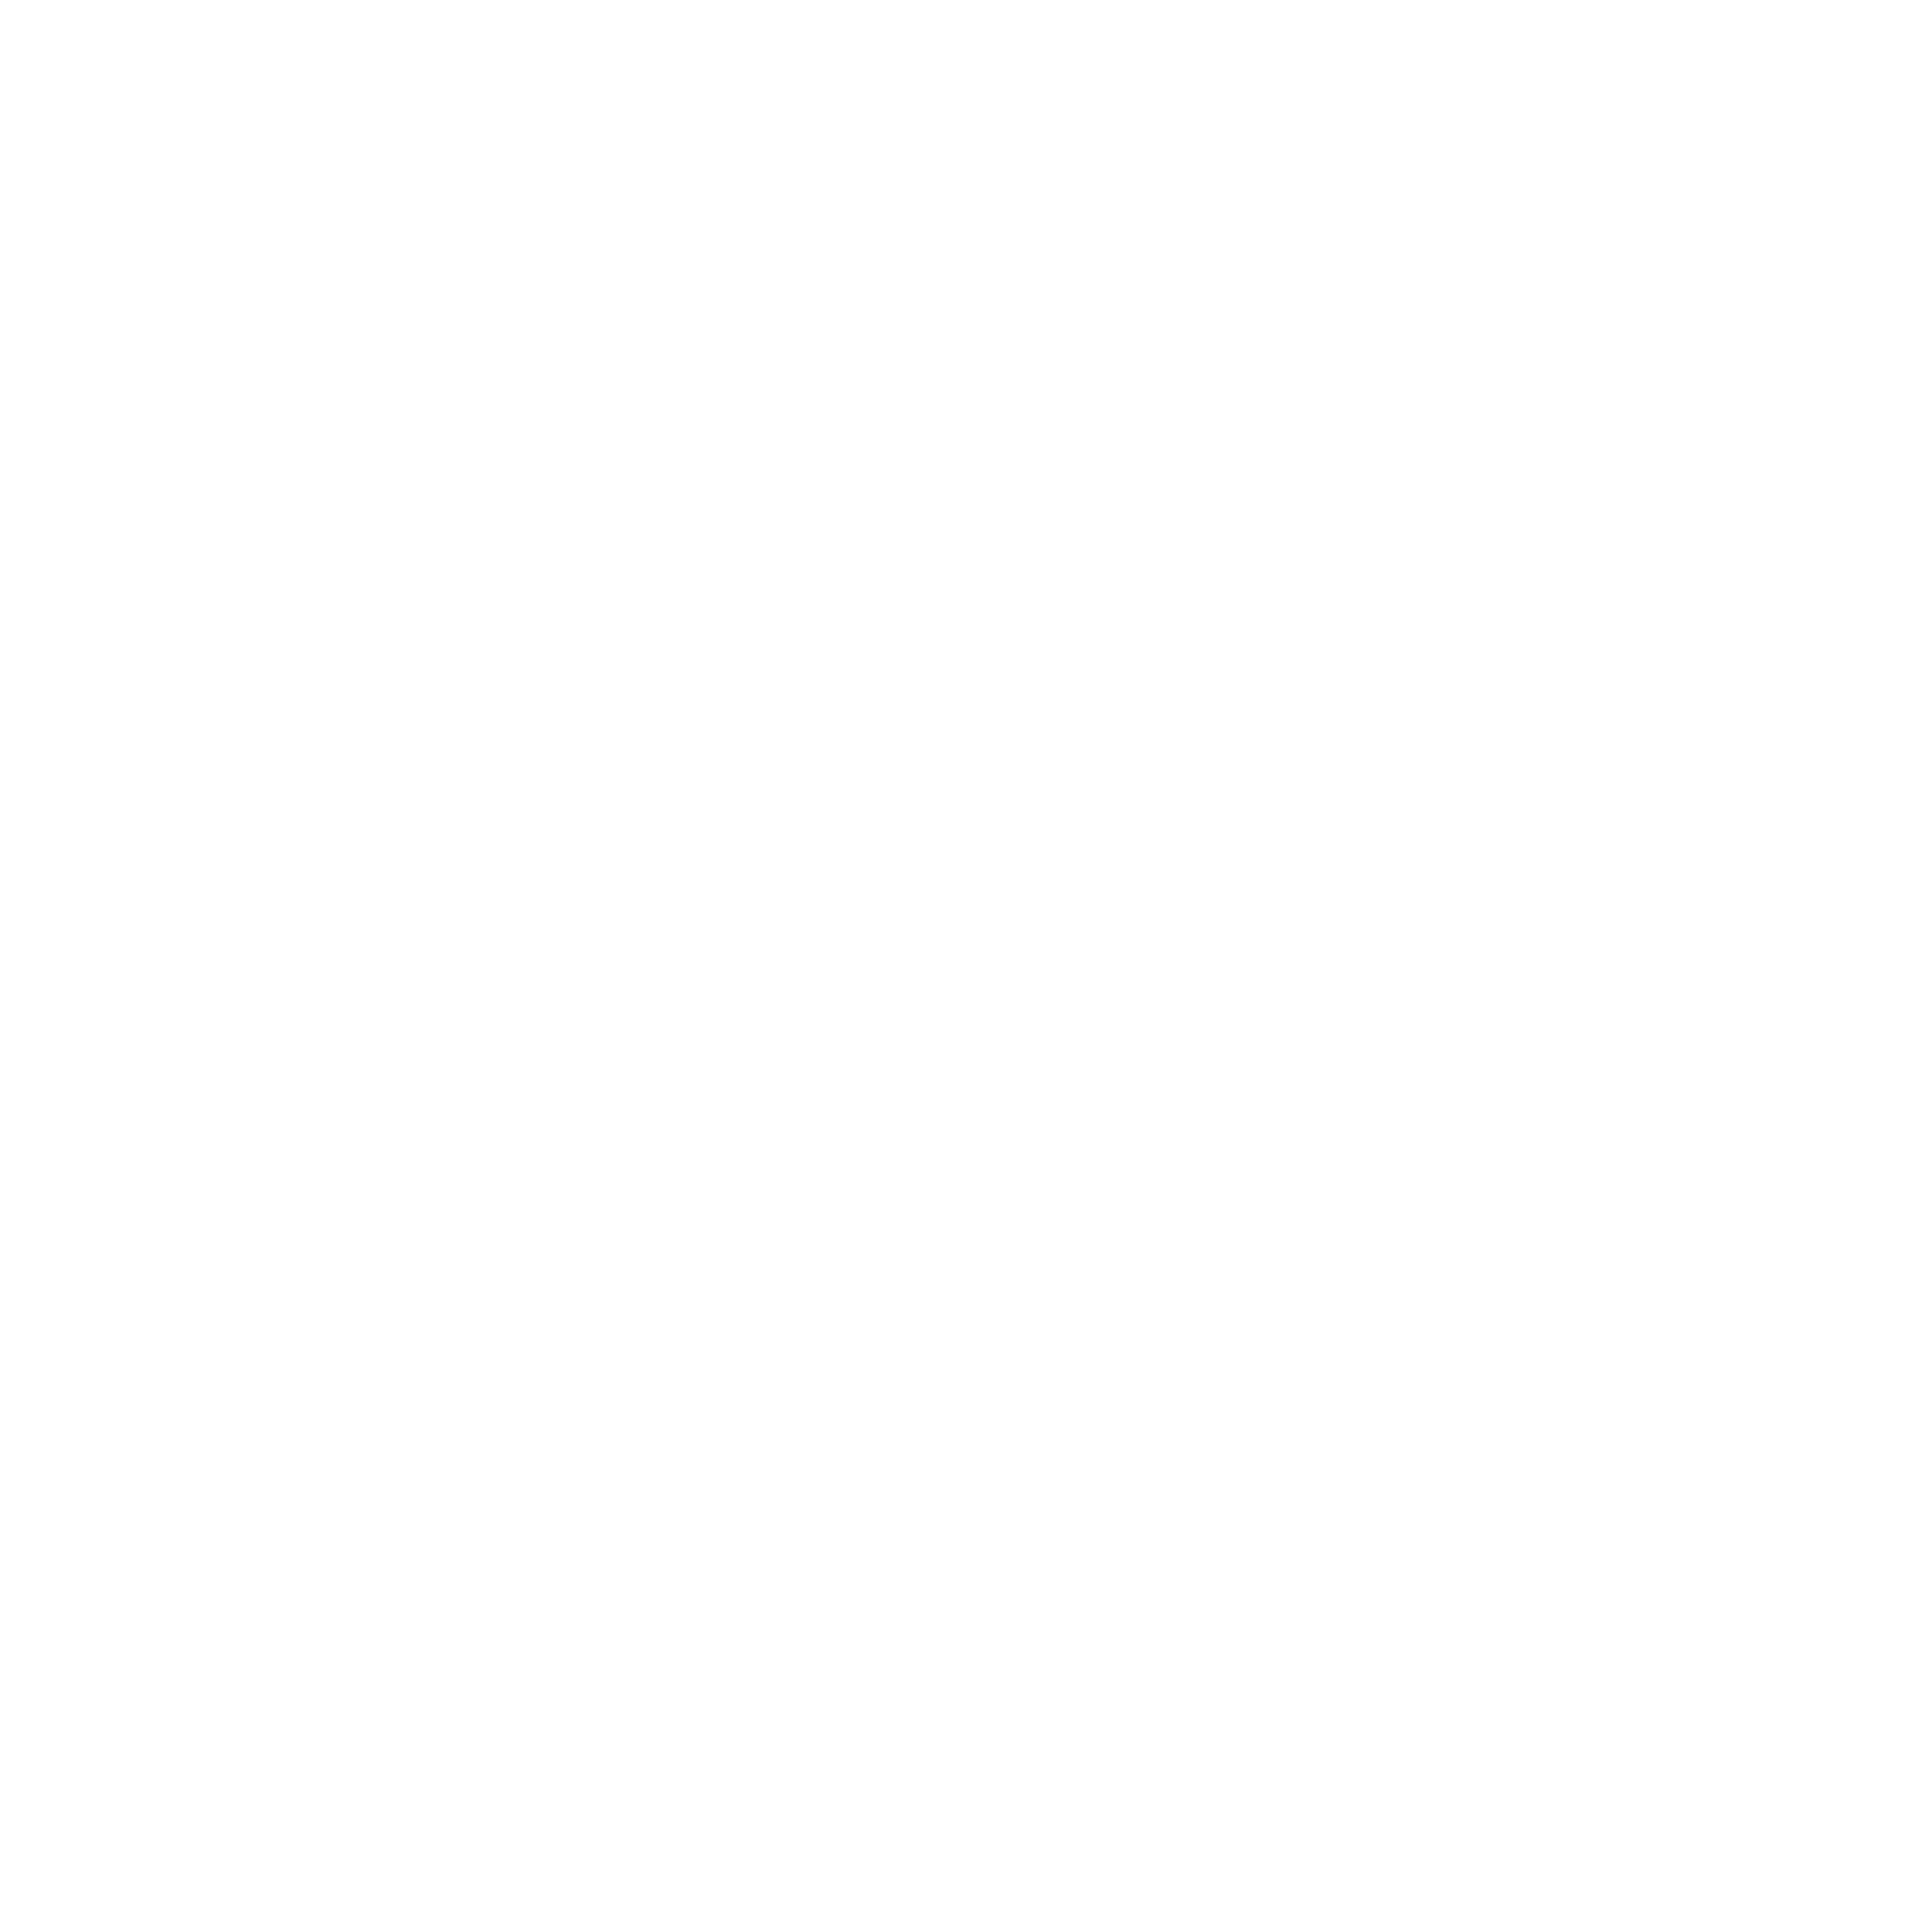

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'
dual_edge_color = '#8A307F'

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_border_color, 
               s=50)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)
    
for node_id in node_dict:
    plot_node(ax, node_id)
    
for edge_id in edge_dict:
    start_node = edge_id[0]
    end_node = edge_id[1]
    start_coords = node_dict[start_node]
    end_coords = node_dict[end_node]
    plot_edge_bycoords(ax, start_coords, end_coords)

import matplotlib.lines as mlines
primal_node_handle = mlines.Line2D([], [], 
                                   color=primal_edge_color, 
                                   markeredgecolor=primal_node_border_color, 
                                   marker='o', 
                                   markersize=13, 
                                   label='primal node')
primal_edge_handle = mlines.Line2D([], [], 
                                   color=primal_edge_color, 
                                   marker='_',
                                   markersize=10, 
                                   label='primal edge')
plt.legend(handles=[primal_node_handle, primal_edge_handle])

#### Plot dual mesh

<IPython.core.display.Javascript object>


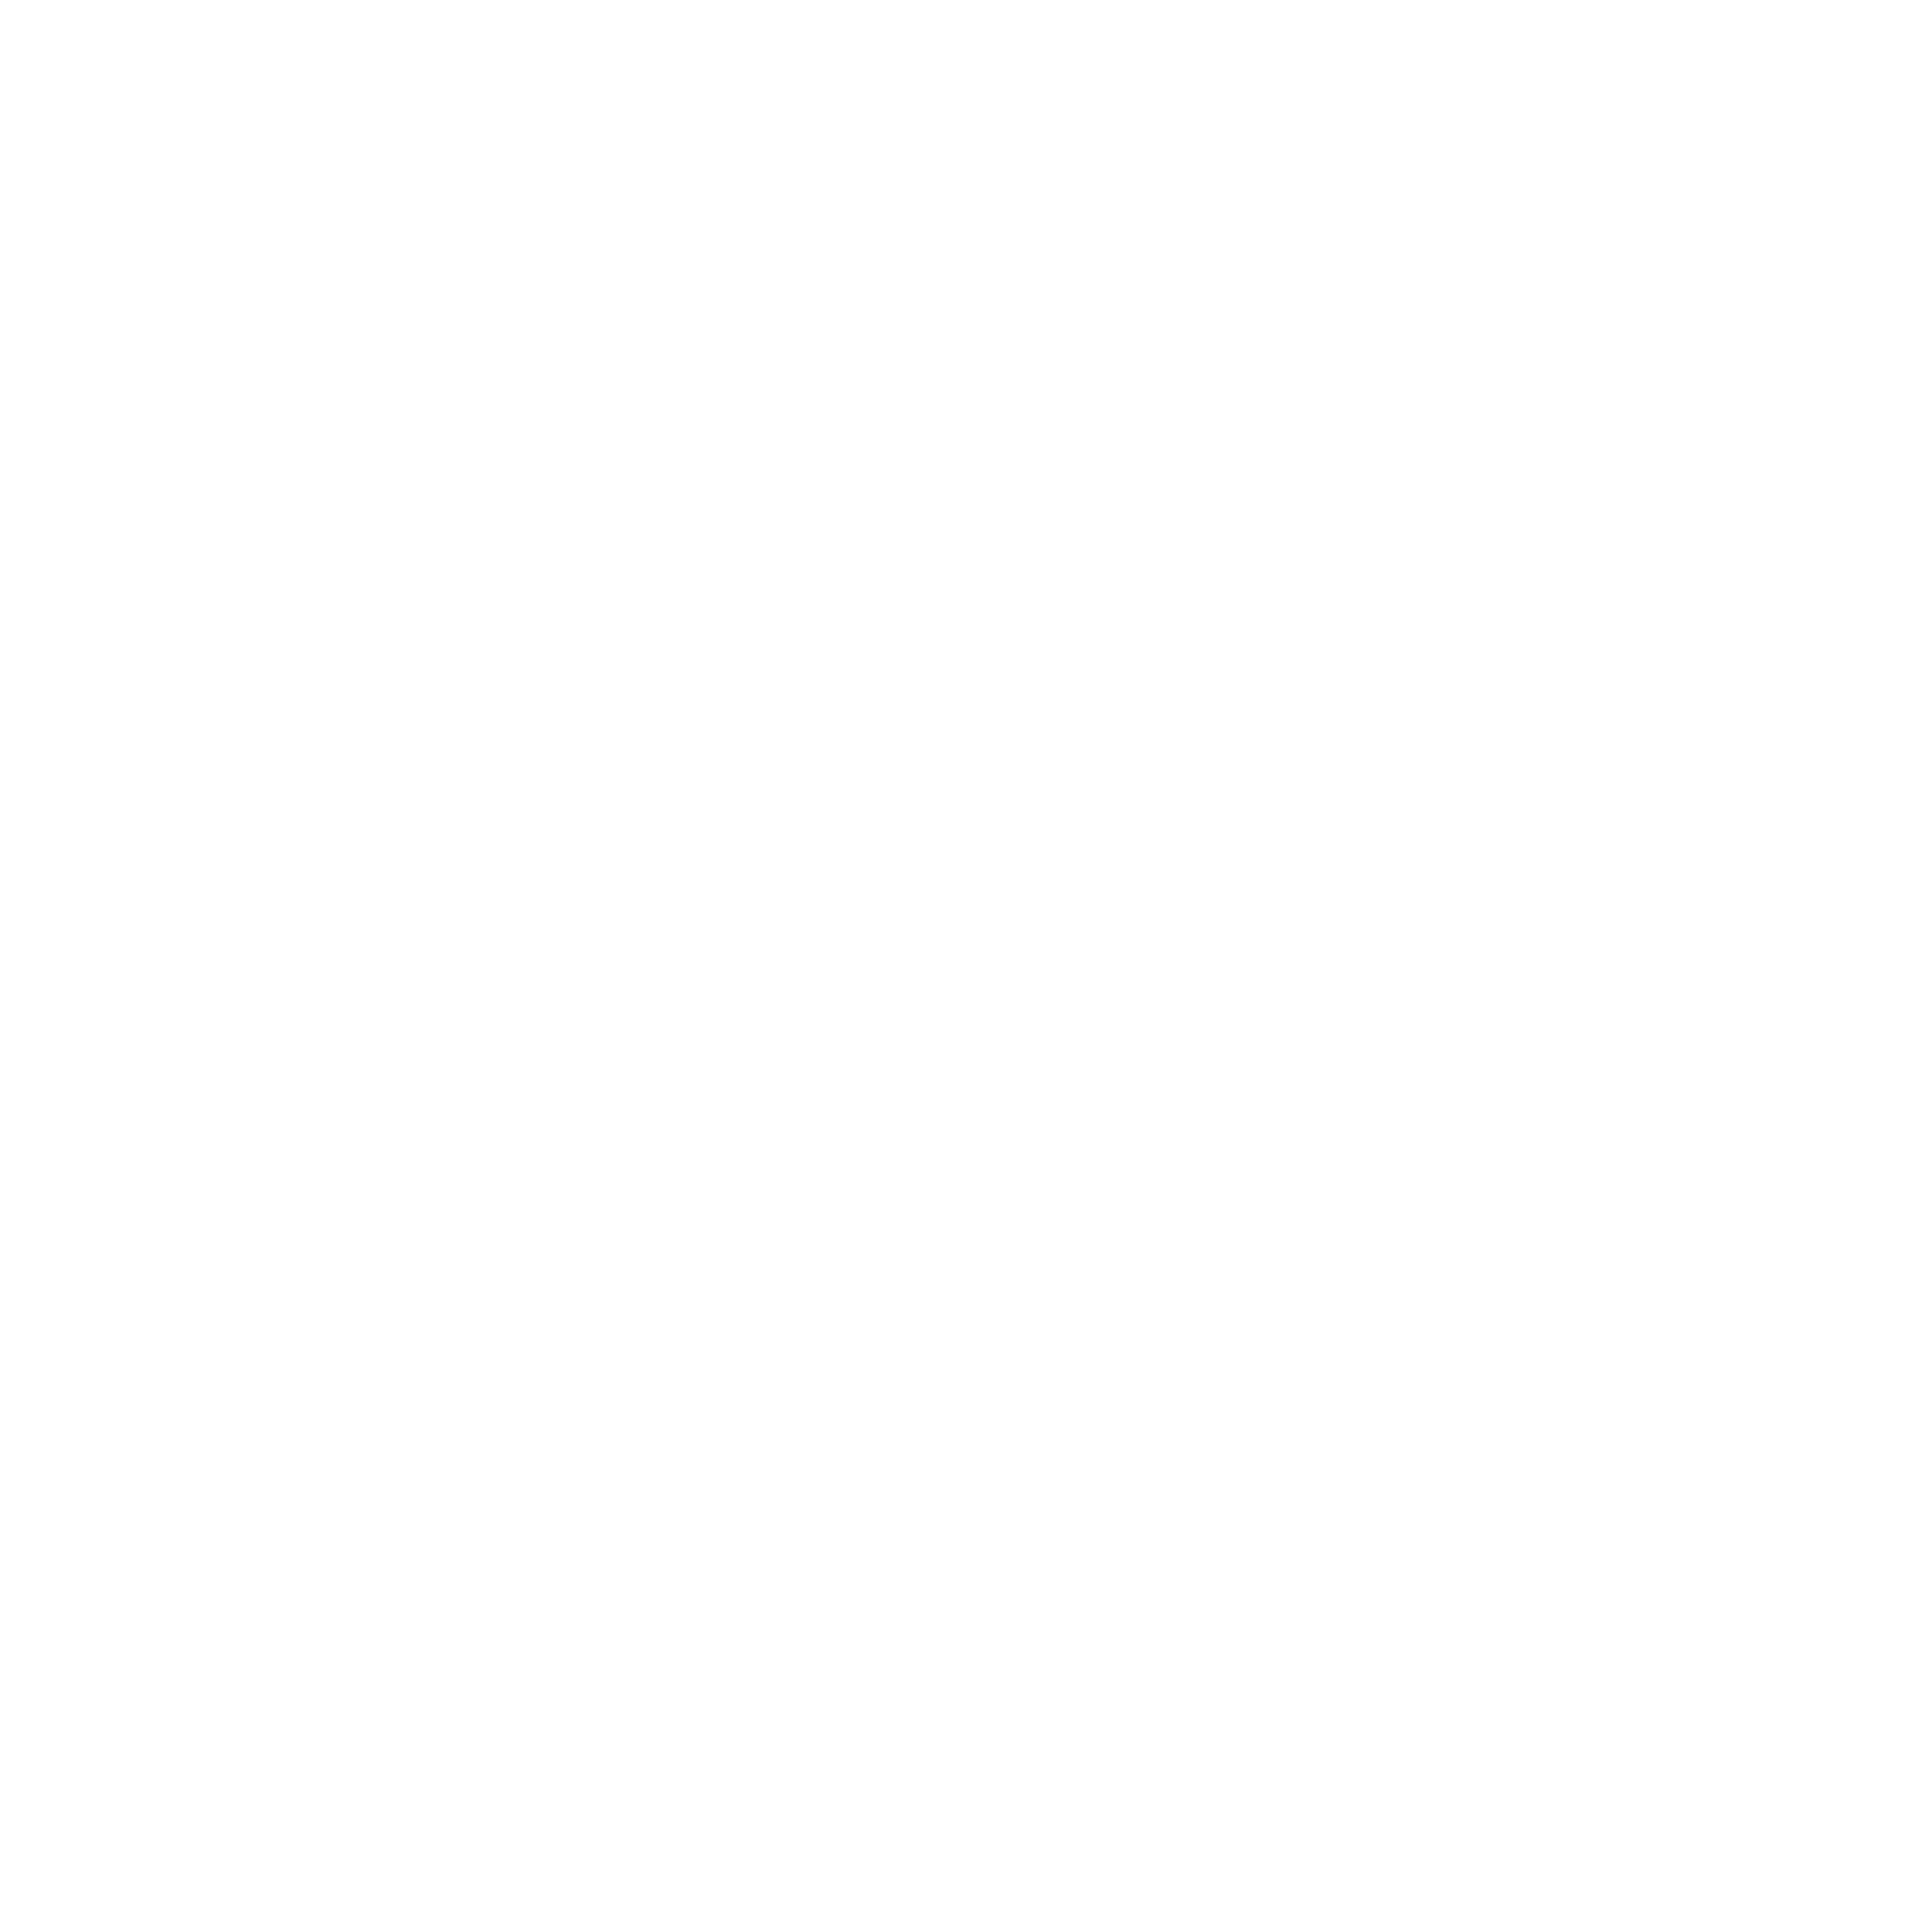

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, 
               edgecolor=dual_node_border_color, 
               s=10, 
               linewidth=0.5)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color,
              linewidth=1.2)
    
for tet_id in dual_node_dict:
    plot_dual_node(ax, dual_node_dict[tet_id])

for primal_edge in complete_coords_dual_face_dict:
    dual_face = complete_coords_dual_face_dict[primal_edge]
    for i in range(len(dual_face)): 
        start = i
        if i == len(dual_face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, dual_face[start], dual_face[end])

for node_id in node_dict:
    for dual_face in get_auxiliary_dual_faces(node_id):
        for i in range(len(face)): 
            start = i
            if i == len(dual_face)-1:
                end = 0
            else:
                end = i+1
            plot_edge_bycoords(ax, dual_face[start], dual_face[end])
            plot_dual_node(ax, dual_face[start])

import matplotlib.lines as mlines
dual_node_handle = mlines.Line2D([], [], 
                                 color=dual_edge_color, 
                                 markeredgecolor=dual_node_border_color, 
                                 marker='o', 
                                 markersize=10, 
                                 label='dual node')
dual_edge_handle = mlines.Line2D([], [], 
                                 color=dual_edge_color, 
                                 marker='_', 
                                 markersize=10, 
                                 label='dual edge')
plt.legend(handles=[dual_node_handle, dual_edge_handle])

#### Create empty figure for legend

<IPython.core.display.Javascript object>


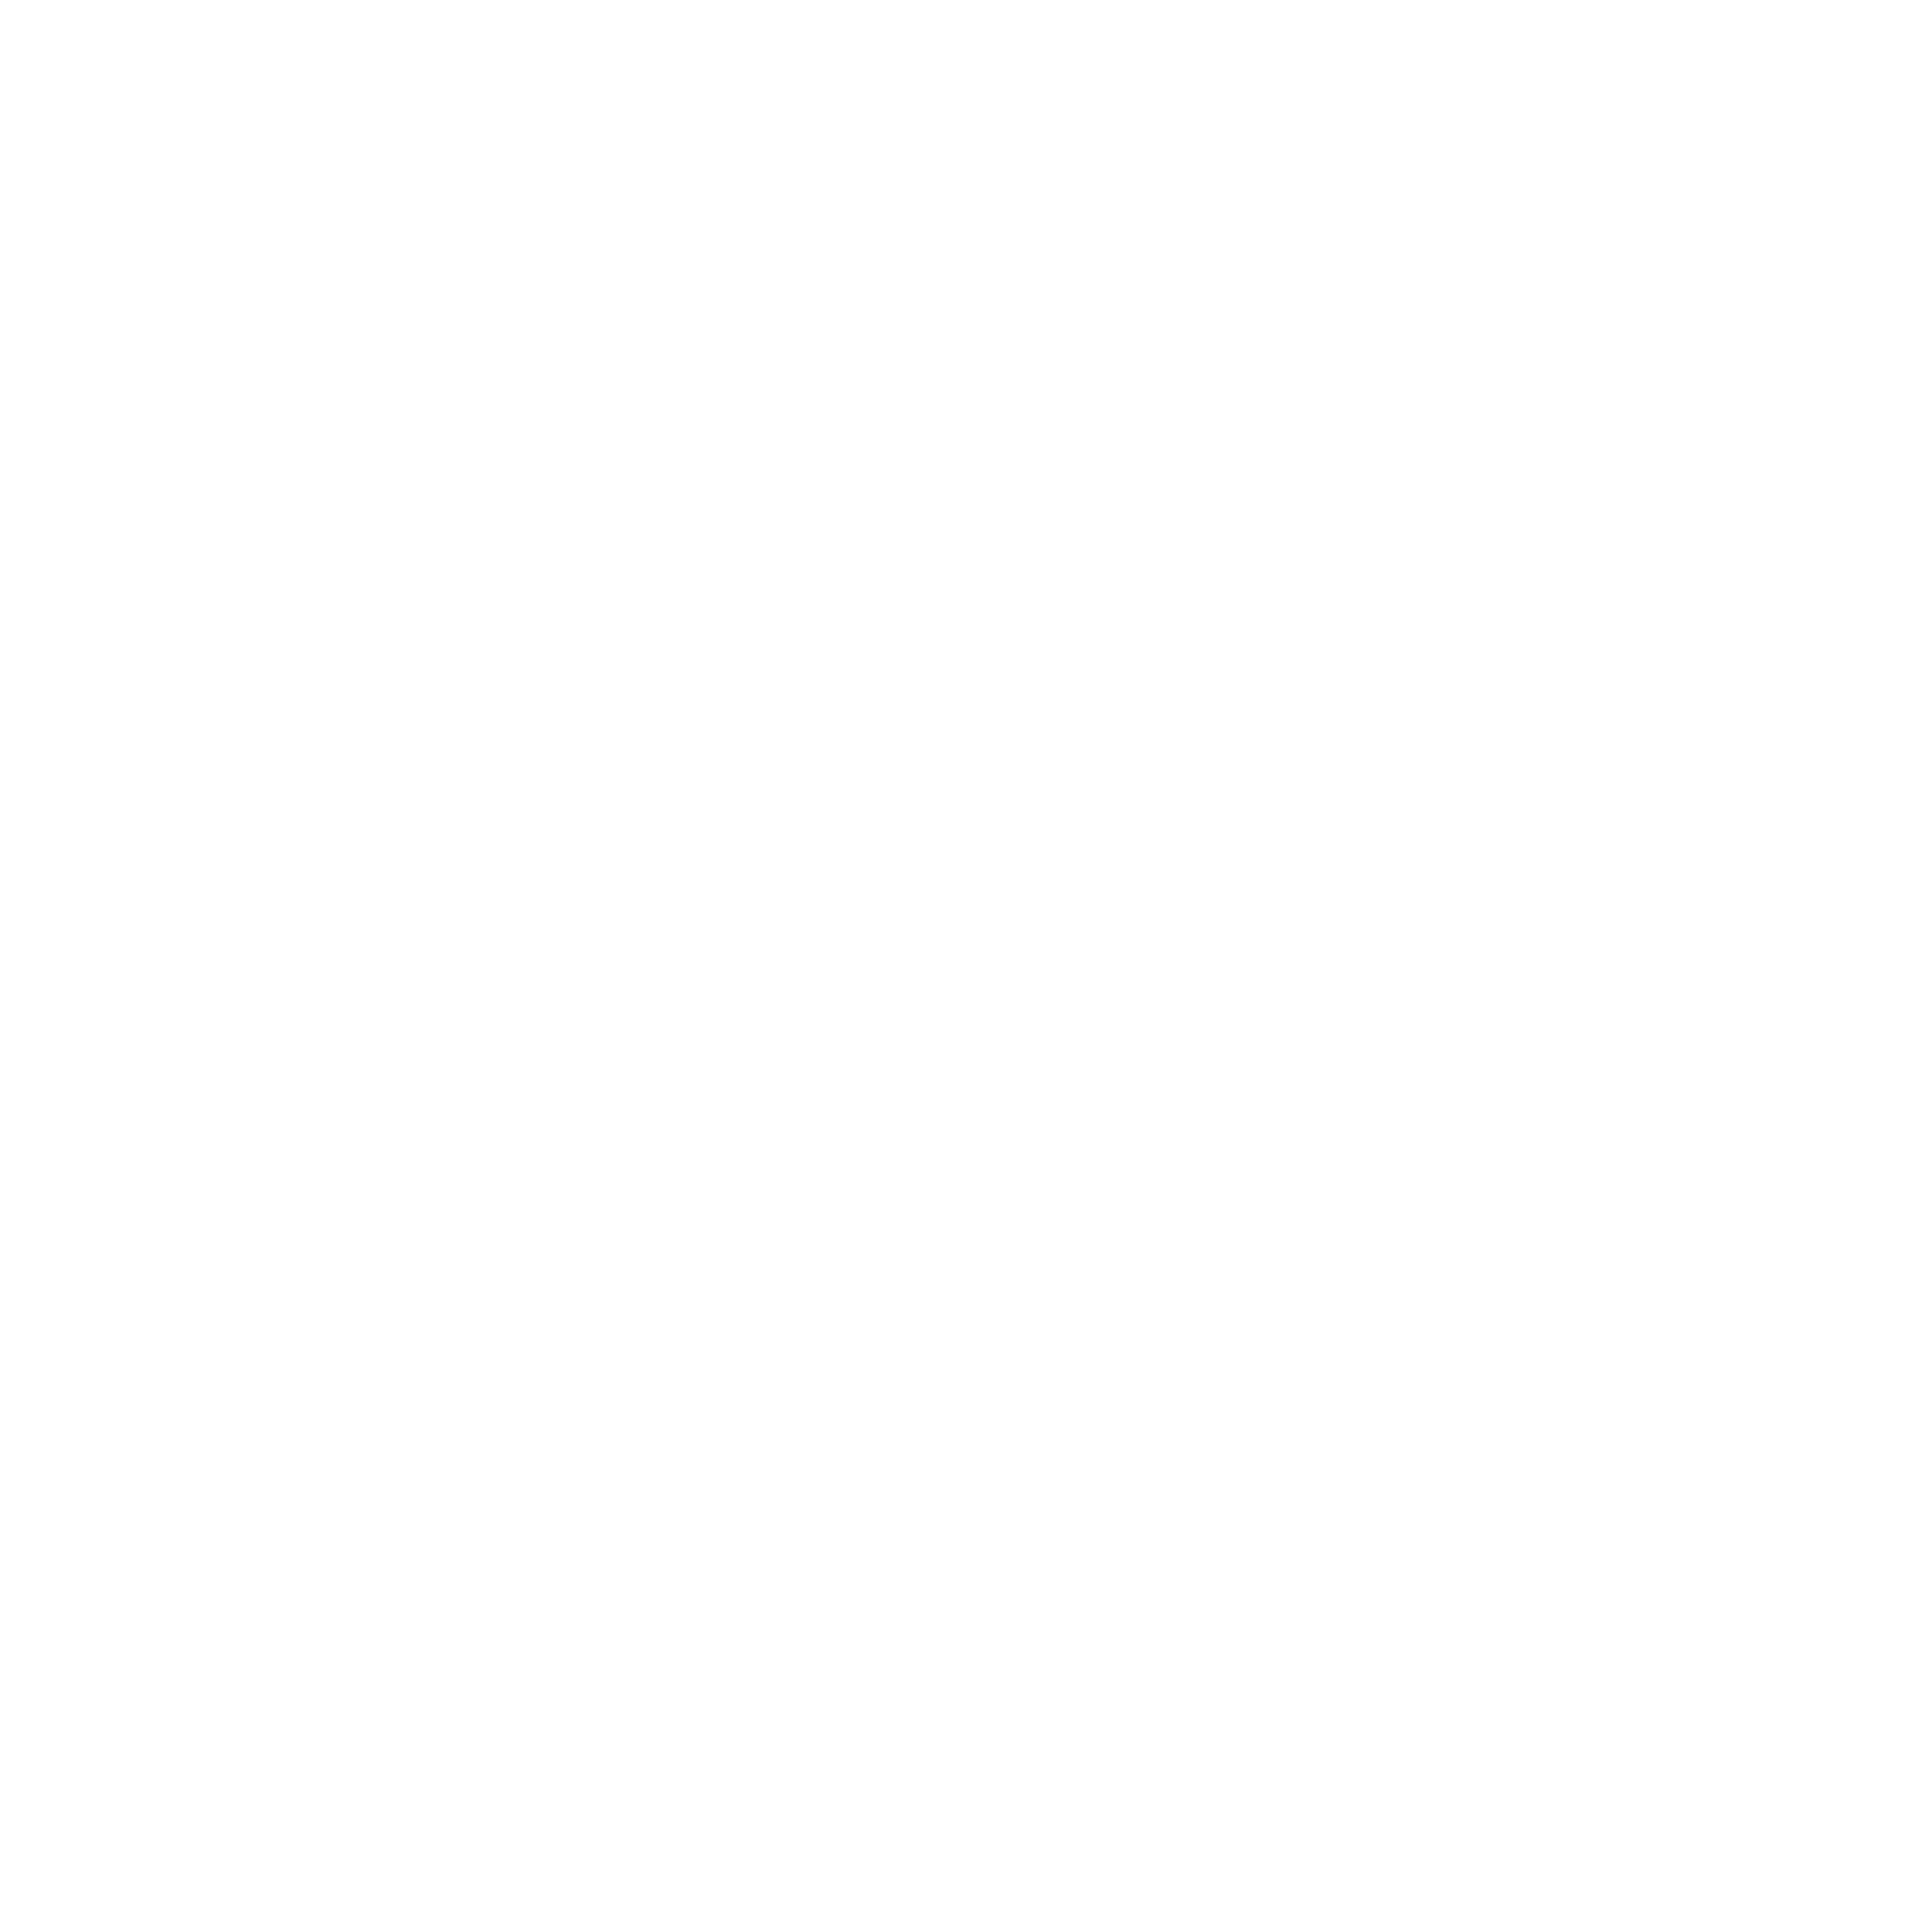

In [56]:
from matplotlib import pyplot as plt

primal_node_handle = mlines.Line2D([], [], 
                                   color=primal_edge_color, 
                                   markeredgecolor=primal_node_border_color, 
                                   marker='o', 
                                   markersize=13, 
                                   label='primal node')
primal_edge_handle = mlines.Line2D([], [], 
                                   color=primal_edge_color, 
                                   marker='_',
                                   markersize=10, 
                                   label='primal edge')
dual_node_handle = mlines.Line2D([], [], 
                                 color=dual_edge_color, 
                                 markeredgecolor=dual_node_border_color, 
                                 marker='o', 
                                 markersize=10, 
                                 label='dual node')
dual_edge_handle = mlines.Line2D([], [], 
                                 color=dual_edge_color, 
                                 marker='_', 
                                 markersize=10, 
                                 label='dual edge')

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
fig.legend(handles=[primal_node_handle, primal_edge_handle, dual_node_handle, dual_edge_handle], prop={'size':15})

#### Plot auxiliary faces for example boundary primal node

<IPython.core.display.Javascript object>


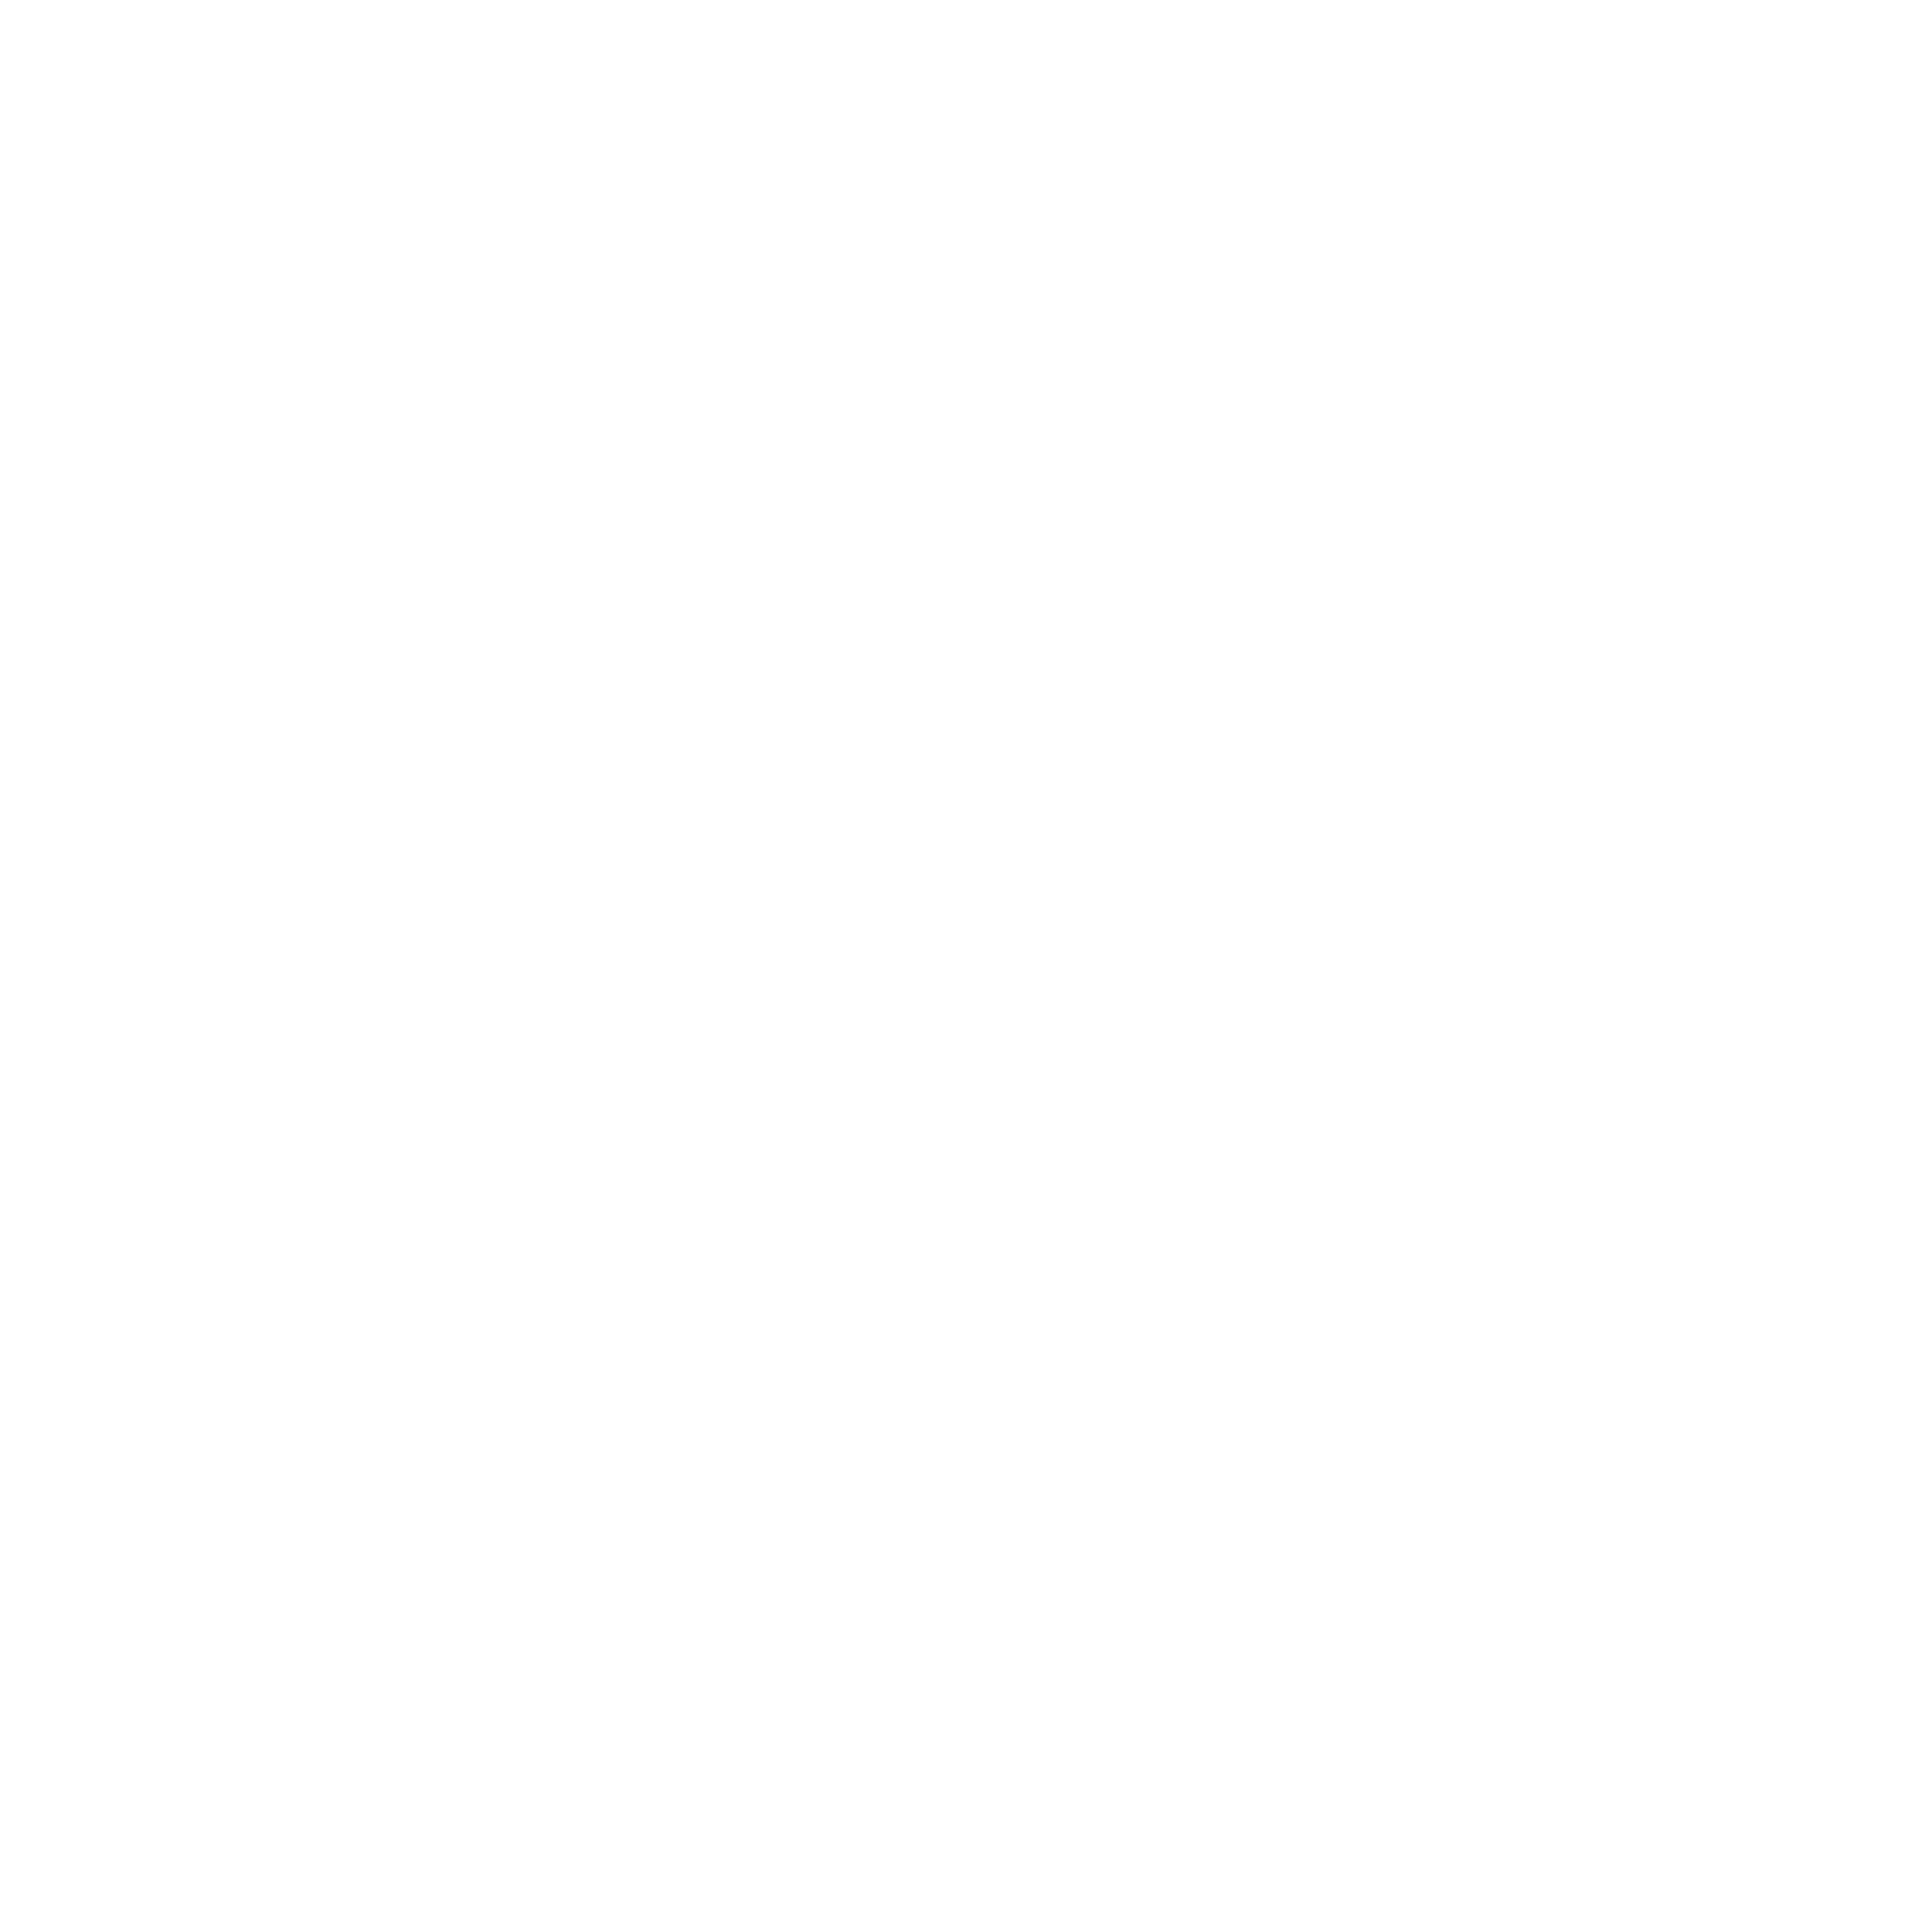

In [57]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

node_id = 4

plot_node(ax, node_id)

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_border_color, 
               s=50)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)
    
for edge_id in edge_dict:
    start_node = edge_id[0]
    end_node = edge_id[1]
    start_coords = node_dict[start_node]
    end_coords = node_dict[end_node]
    plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color,
              linewidth=1.2)
    
def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, 
               edgecolor=dual_node_border_color, 
               s=10, 
               linewidth=0.5)

for face in get_auxiliary_dual_faces(node_id=node_id):
    for i in range(len(face)): #sanity check: len(face) should be 4
        start = i
        if i == len(face)-1:
            end = 0
        else:
            end = i+1
        plot_edge_bycoords(ax, face[start], face[end])
    for dual_node_coords in face:
        plot_dual_node(ax, dual_node_coords)

#### Plot example pair of a primal edge and the corresponding dual face (dotted lines marking the primal tets whose circumcenters form the dual nodes of the dual face)

<IPython.core.display.Javascript object>


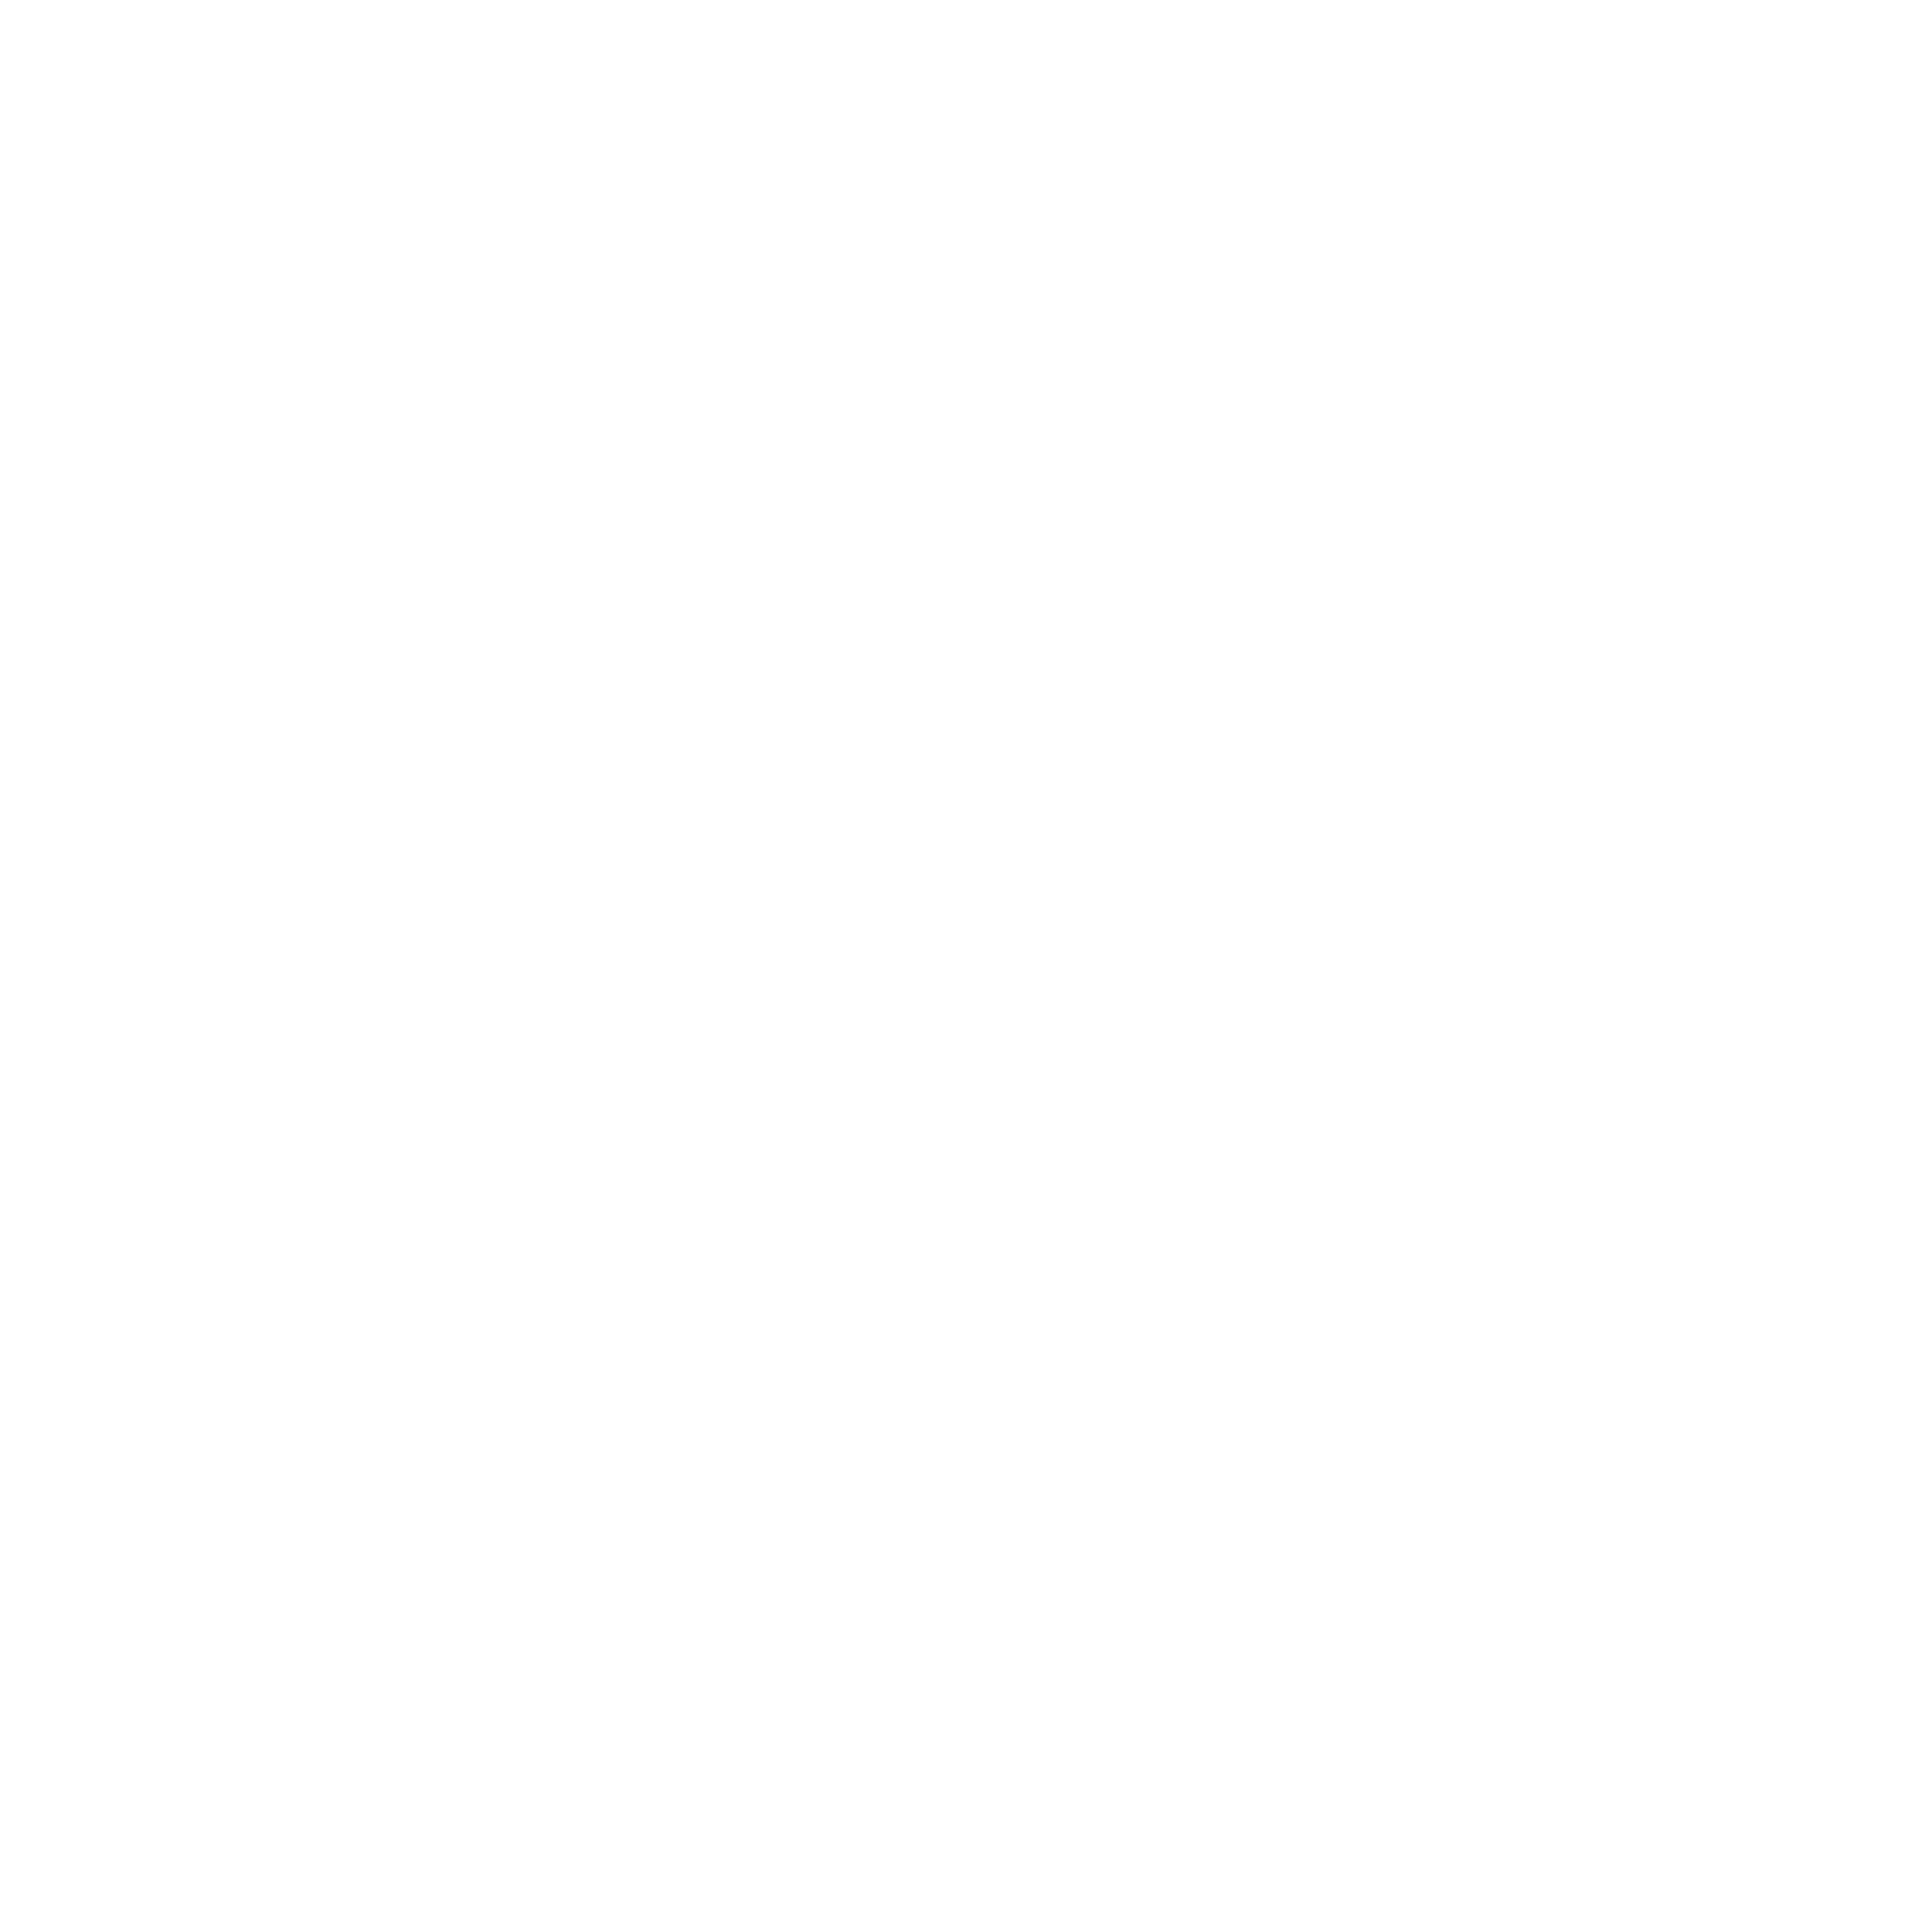

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

edge_id = (34, 45)

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, edgecolor = primal_node_edge_color, s=50)

plot_node(ax, edge_id[0])
plot_node(ax, edge_id[1])

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)

plot_edge_bycoords(ax, node_dict[edge_id[0]], node_dict[edge_id[1]])
    
def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, 
               edgecolor=dual_node_border_color, 
               s=10, 
               linewidth=0.5)

for tet in dual_face_dict[edge_id]:
    dual_node_coords = dual_node_dict[tet]
    plot_dual_node(ax, dual_node_coords)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color,
              linewidth=1.2)

for i in range(len(dual_face_dict[edge_id])):
    start_tet = dual_face_dict[edge_id][i]
    
    if i == len(dual_face_dict[edge_id])-1:
        end_tet = dual_face_dict[edge_id][0]
    else:
        end_tet = dual_face_dict[edge_id][i+1]
    
    plot_edge_bycoords(ax, dual_node_dict[start_tet], dual_node_dict[end_tet])
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=0.7, 
              linestyle=(0,(5,1)))

for tet_id in dual_face_dict[edge_id]:
    faces = list(itertools.combinations(tetrahedron_dict[tet_id], 3)) 
    for face in faces:
        edges = list(itertools.combinations(face, 2))
        for edge in edges:
            plot_edge_bycoords(ax, node_dict[edge[0]], node_dict[edge[1]])

#### Plot example pair of a primal node and the corresponding dual volume

<IPython.core.display.Javascript object>


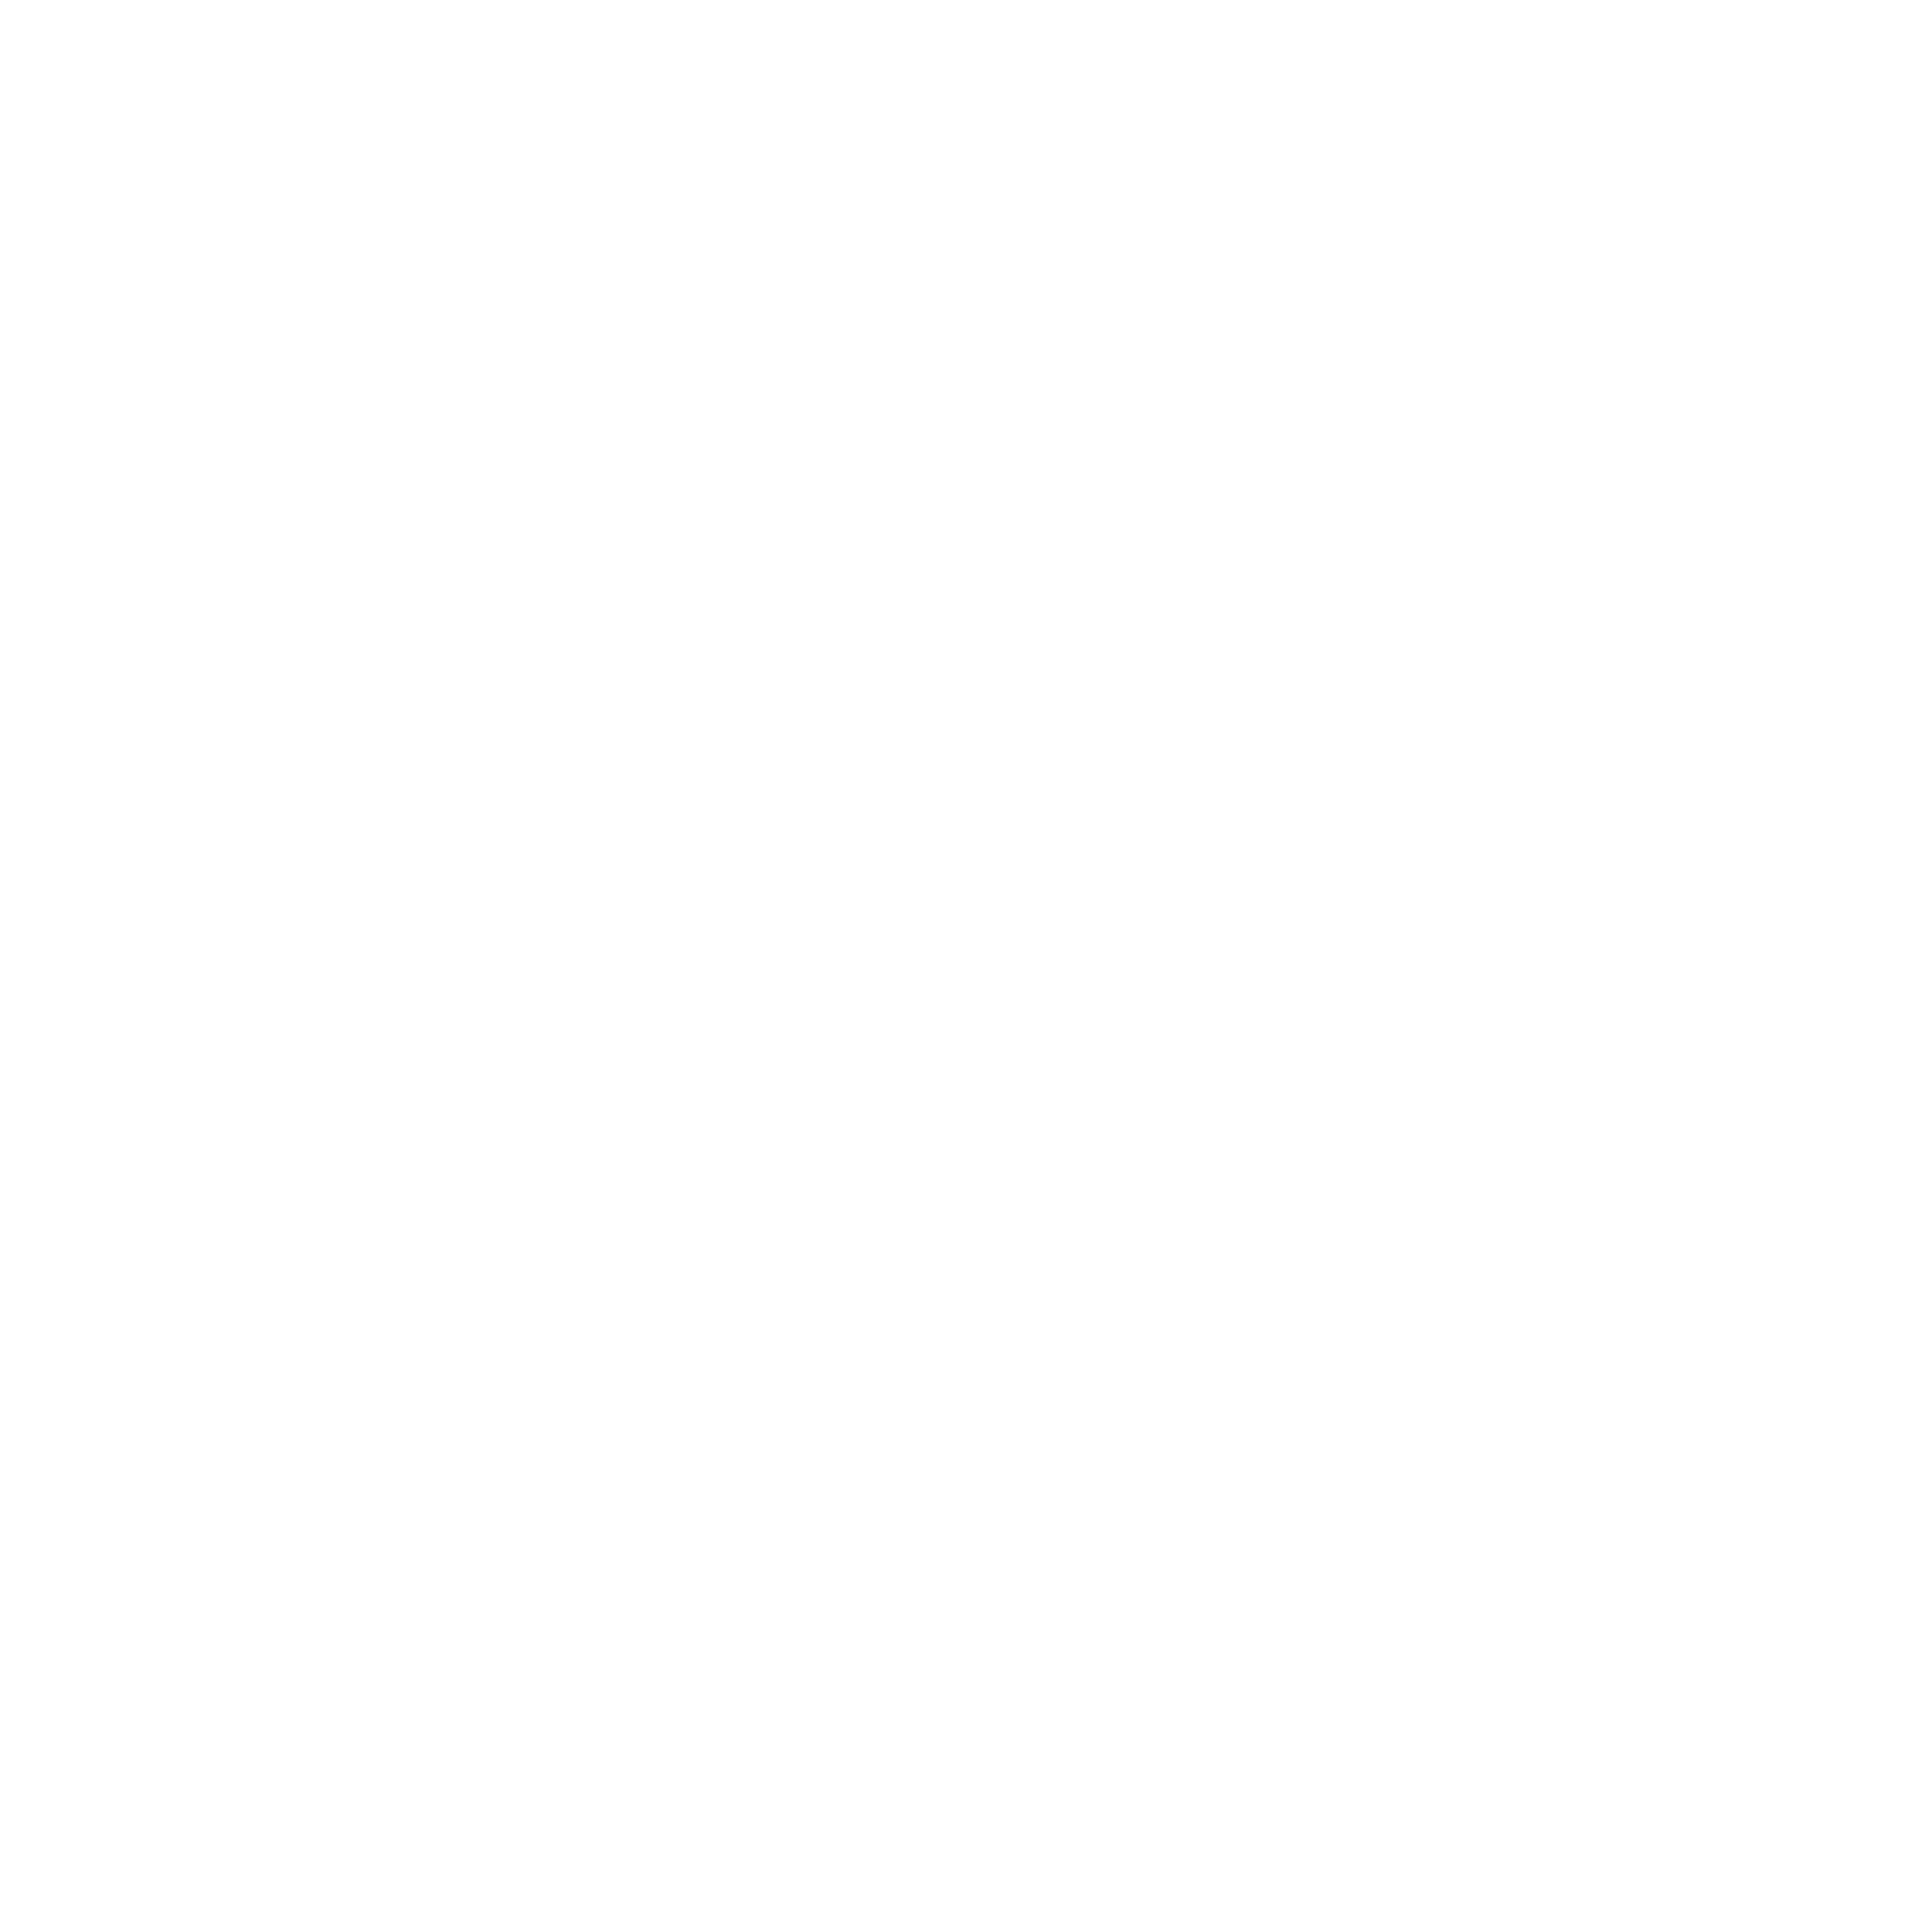

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

node_id = 45

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_border_color, 
               s=50)
    
plot_node(ax, node_id)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_edge_color, 
               s=10)

for edge_id in edge_dict:
    if node_id in edge_id:
        plot_edge_bycoords(ax, node_dict[edge_id[0]], node_dict[edge_id[1]])
        if edge_id[0] != node_id:
            plot_node(ax, edge_id[0])
        if edge_id[1] != node_id:
            plot_node(ax, edge_id[1])
    
def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, 
               edgecolor=dual_node_border_color, 
               s=10, 
               linewidth=0.5)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color,
              linewidth=1.2)

for dual_face in dual_volume_dict[node_id]:
    for i in range(len(dual_face)):
        start_tet = dual_face[i]
        if i == len(dual_face)-1:
            end_tet = dual_face[0]
        else:
            end_tet = dual_face[i+1]
        dual_faces = dual_node_dict[tet]
        
        plot_dual_node(ax, dual_node_dict[start_tet])    
        plot_edge_bycoords(ax, dual_node_dict[start_tet], dual_node_dict[end_tet])

#### Plot example pair of a primal tetrahedron and the corresponding dual node  

<IPython.core.display.Javascript object>


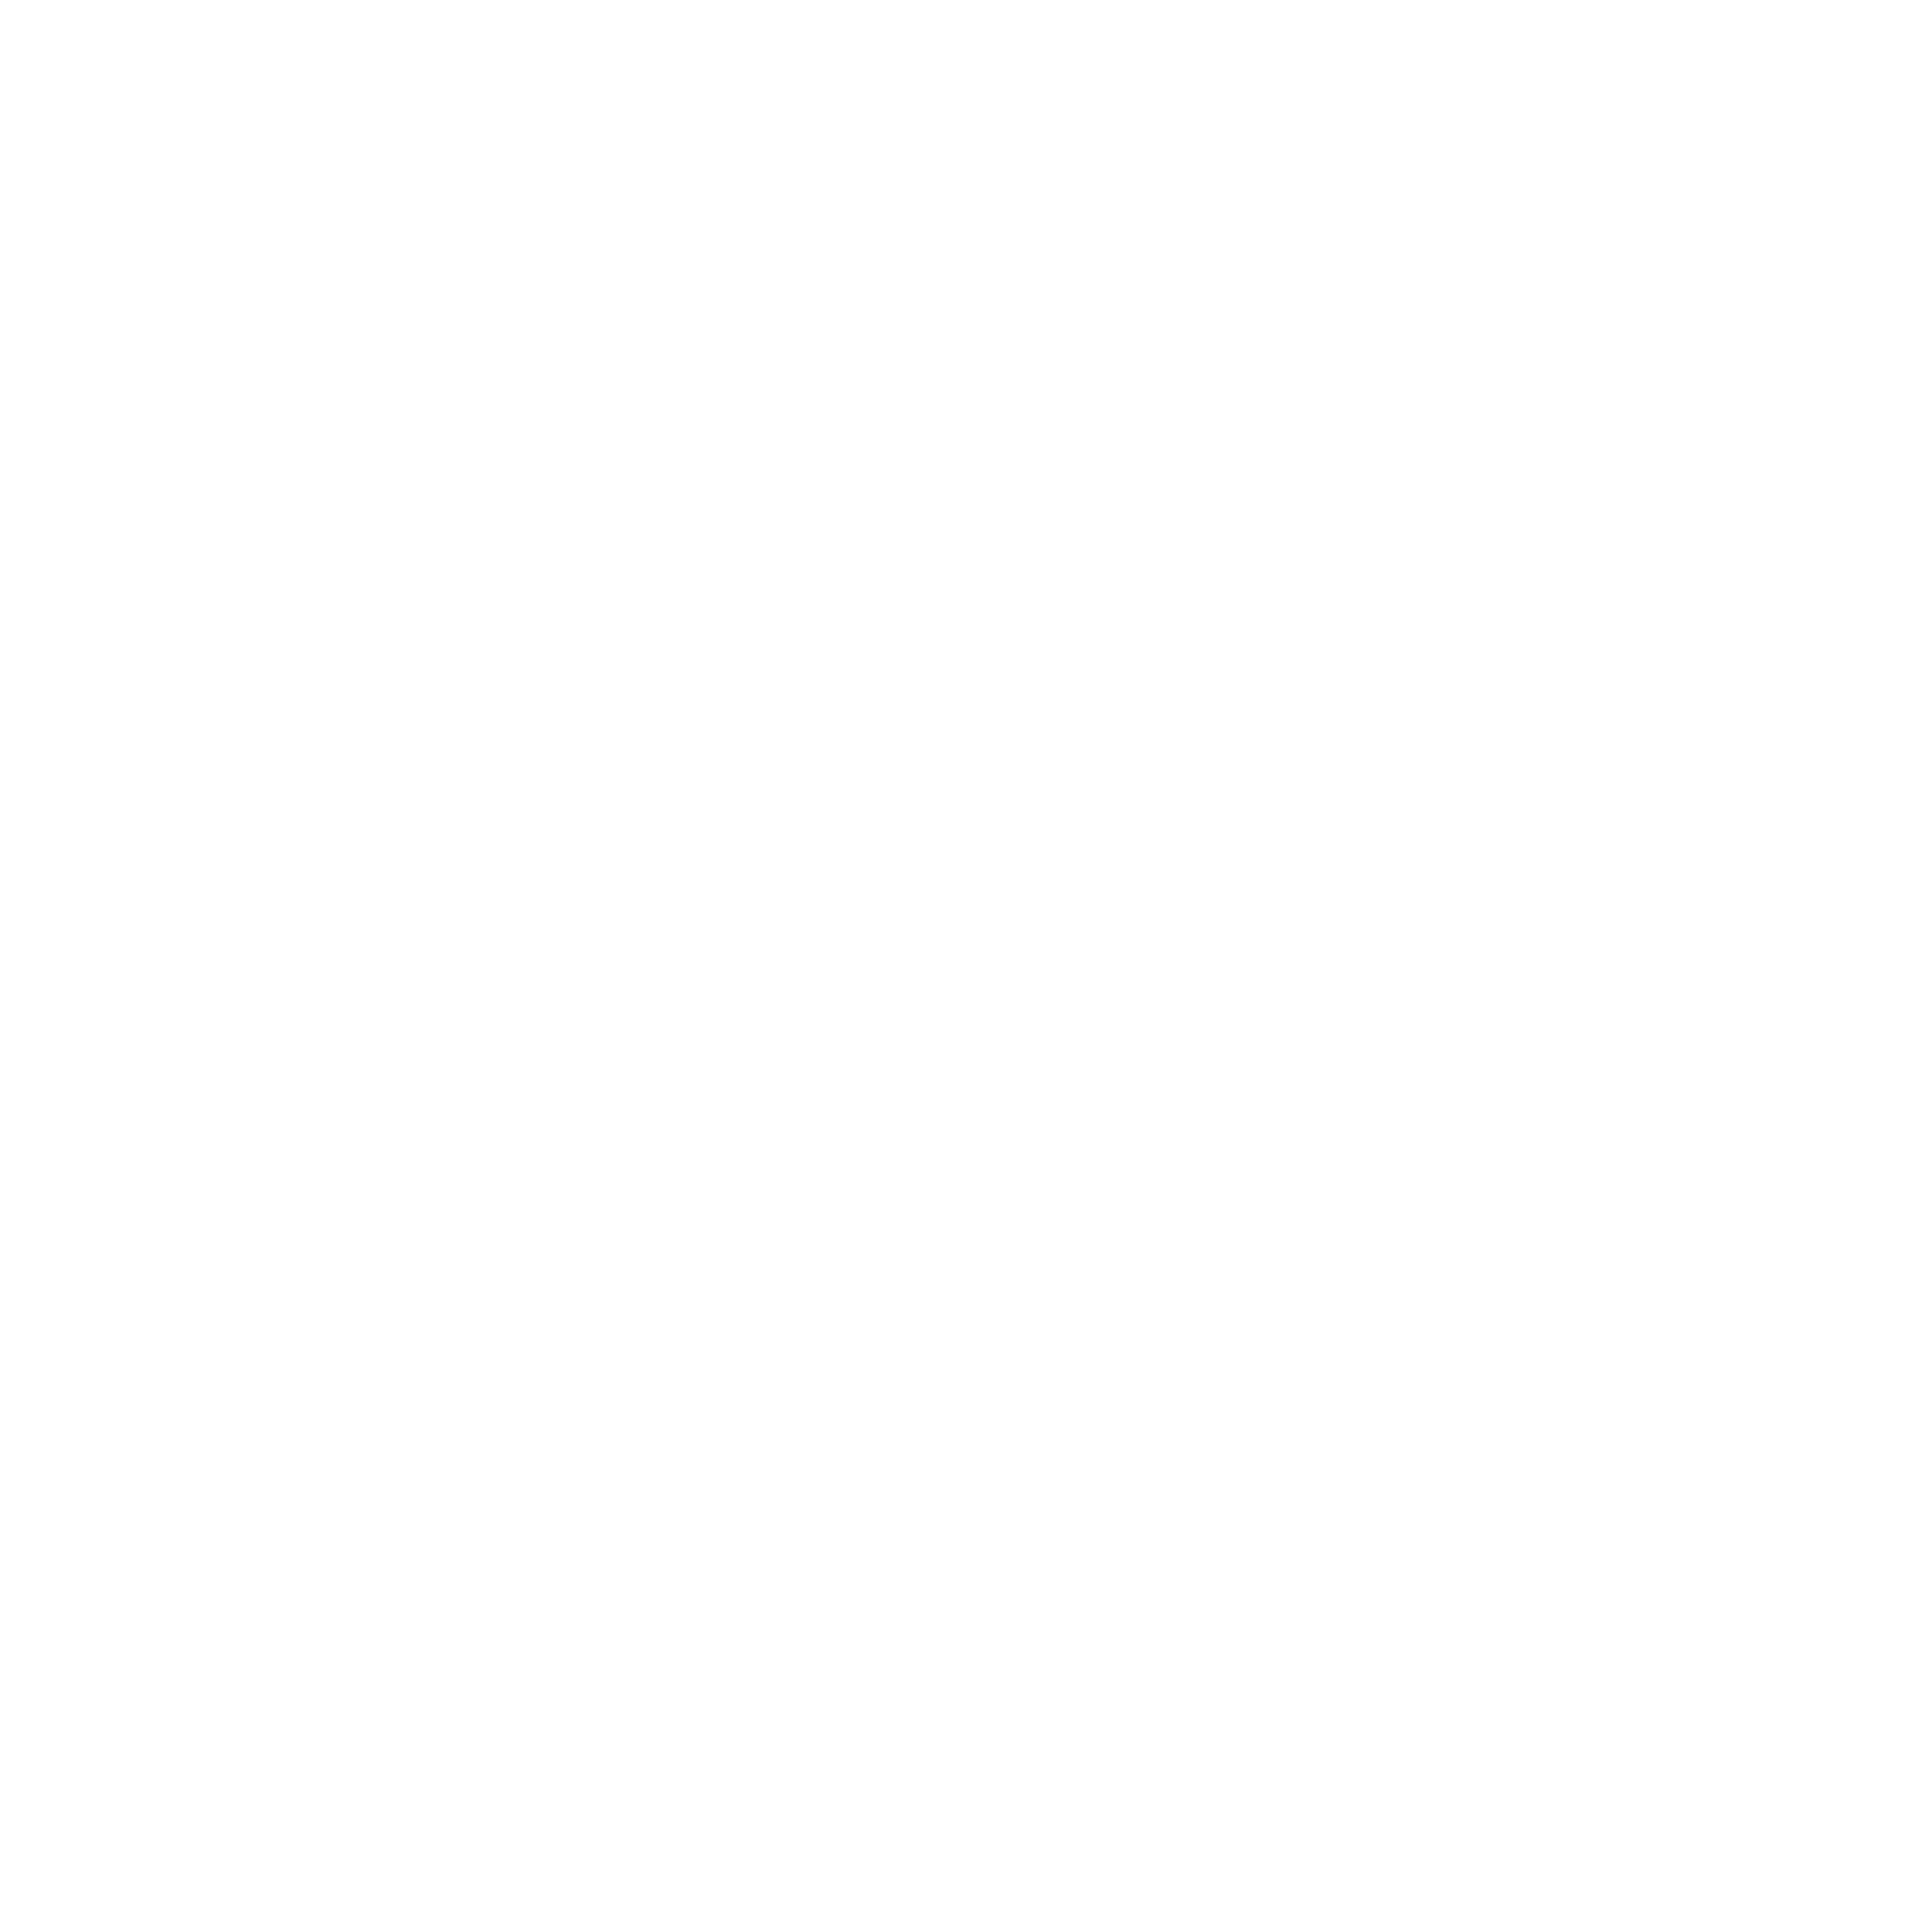

In [60]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

tetrahedron_id = 122

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, edgecolor = primal_node_border_color, s=50)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)

faces = list(itertools.combinations(tetrahedron_dict[tetrahedron_id], 3)) 
for face in faces:
    edges = list(itertools.combinations(face, 2))
    for edge in edges:
        plot_edge_bycoords(ax, node_dict[edge[0]], node_dict[edge[1]])
        plot_node(ax, edge[0])
        plot_node(ax, edge[1])
    
def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, edgecolor = dual_node_border_color, s=10, linewidth=0.5)

plot_dual_node(ax, dual_node_dict[tetrahedron_id])

#### Plot example of a primal face and the corresponding dual edge (dotted lines marking the primal tets whose circumcenters form the dual nodes of the dual edge)

<IPython.core.display.Javascript object>


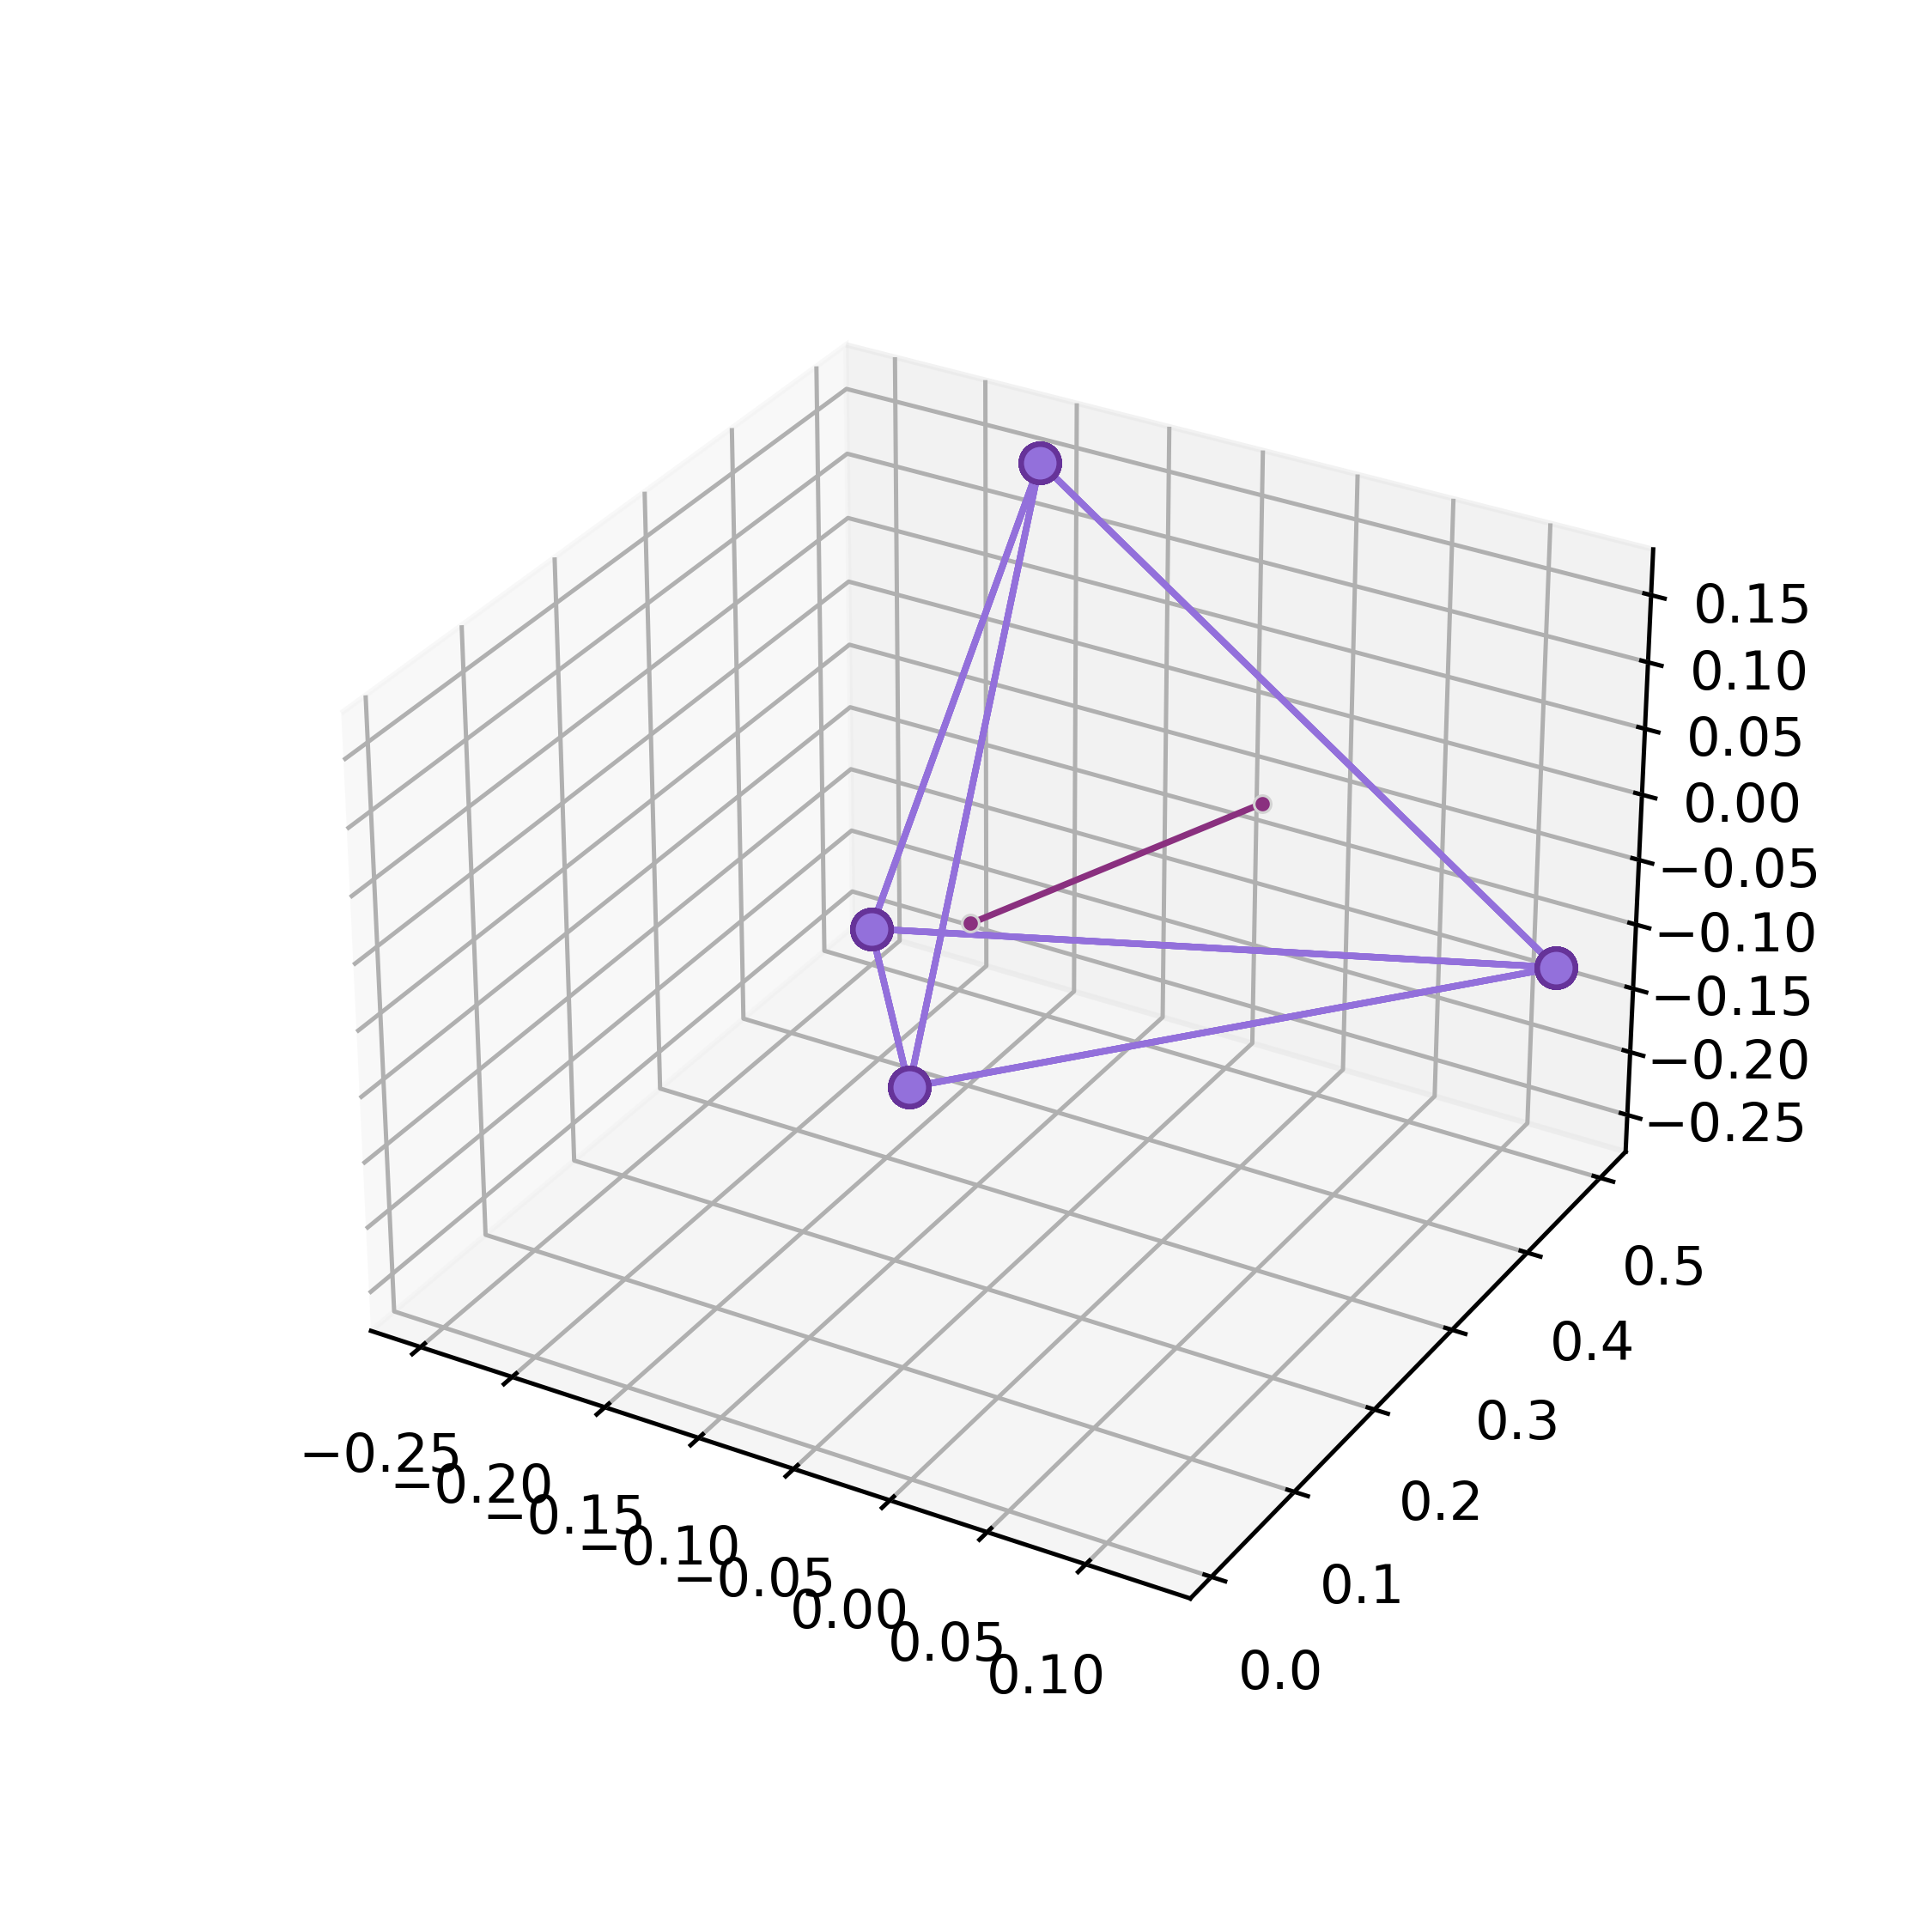

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(dpi=300)
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

primal_node_color = 'mediumpurple'
primal_node_border_color = 'rebeccapurple'
primal_edge_color = 'mediumpurple'

dual_node_color = '#8A307F'
dual_node_border_color = 'lightgray'
dual_edge_color = '#8A307F'

face_id = (26,28,45)
tetrahedron_id_1 = 154
tetrahedron_id_2 = 177

def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], 
               c=primal_node_color, 
               edgecolor=primal_node_border_color, 
               s=50)

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=primal_edge_color,
              linewidth=1.2)

faces = list(itertools.combinations(tetrahedron_dict[tetrahedron_id_1], 3)) 
for face in faces:
    edges = list(itertools.combinations(face, 2))
    for edge in edges:
        plot_edge_bycoords(ax, node_dict[edge[0]], node_dict[edge[1]])
        plot_node(ax, edge[0])
        plot_node(ax, edge[1])
        
faces = list(itertools.combinations(tetrahedron_dict[tetrahedron_id_1], 3)) 
for face in faces:
    edges = list(itertools.combinations(face, 2))
    for edge in edges:
        plot_edge_bycoords(ax, node_dict[edge[0]], node_dict[edge[1]])
        plot_node(ax, edge[0])
        plot_node(ax, edge[1])       
    
def plot_dual_node(ax, dual_node_coords):
    ax.scatter(dual_node_coords[0],
               dual_node_coords[1],
               dual_node_coords[2],
               c=dual_node_color, 
               edgecolor=dual_node_border_color, 
               s=10, 
               linewidth=0.5)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    ax.plot3D([edgestartcoords[0], edgeendcoords[0]], 
              [edgestartcoords[1], edgeendcoords[1]], 
              [edgestartcoords[2], edgeendcoords[2]], 
              c=dual_edge_color,
              linewidth=1.2)

tets = dual_edge_dict[face_id]
start = dual_node_dict[tets[0]]
end = dual_node_dict[tets[1]]
plot_edge_bycoords(ax, start, end)
plot_dual_node(ax, start)
plot_dual_node(ax,end)